#Image segmentation on waterfall plots
\
The following code aims to apply the image segmentation problem to the waterfall plots of a wireless channel.
<br>
Image segmentation is the process to partition a digital image into multiple segments; in this case the code aims to find the portions of the spectrum where a jammer is doing its disturbing activity.
<br>
The dataset in this problem consisted in a collection of waterfall plots (PSD diagrams over time) in which at the end the action of a gaussian noise jammer was applied.
<br>
The model is an autoencoder, trained only trained using the trusted cases (so the empty channel or the case in which there is transmission of some data). The model then tries to reconstruct the input, but being trained only with the trusted cases it will reconstruct with higher MSE the jammed plots.
<br>
The image segmentation goal then is performed by setting a threshold, and classify as anomaly the pixels (or element of a matrix) in which the reconstruction error is higher than that value.

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,Conv2DTranspose, Flatten, Reshape, LeakyReLU, Dropout
from keras.models import Model, Sequential
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import cv2 as cv
from tqdm import tqdm, trange
from matplotlib import image as mpimg

import gc

In [2]:
!pip install -U --no-cache-dir gdown --pre
!pip install --upgrade gdown
import gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#downloading the dataset 
url = "https://drive.google.com/u/0/uc?id=1R_TMHz6tT-rfScMsjxnIQSaG4orX5jQV&export=download"
output = "matrixes.zip"
gdown.download(url, output)
!unzip matrixes.zip


Downloading...
From (uriginal): https://drive.google.com/u/0/uc?id=1R_TMHz6tT-rfScMsjxnIQSaG4orX5jQV&export=download
From (redirected): https://drive.google.com/uc?id=1R_TMHz6tT-rfScMsjxnIQSaG4orX5jQV&export=download&confirm=t&uuid=b00f3e3a-717a-4ed1-8858-055c4ba08753
To: /content/matrixes.zip
100%|██████████| 2.72G/2.72G [00:33<00:00, 80.2MB/s]


Output streaming troncato alle ultime 5000 righe.
  inflating: matrixes/clean/0_8.npy  
  inflating: matrixes/clean/0_10.npy  
  inflating: matrixes/clean/0_16.npy  
  inflating: matrixes/clean/0_24.npy  
  inflating: matrixes/clean/0_28.npy  
  inflating: matrixes/clean/0_38.npy  
  inflating: matrixes/clean/0_40.npy  
  inflating: matrixes/clean/0_42.npy  
  inflating: matrixes/clean/0_48.npy  
  inflating: matrixes/clean/0_62.npy  
  inflating: matrixes/clean/0_70.npy  
  inflating: matrixes/clean/0_72.npy  
  inflating: matrixes/clean/0_78.npy  
  inflating: matrixes/clean/0_80.npy  
  inflating: matrixes/clean/0_83.npy  
  inflating: matrixes/clean/0_87.npy  
  inflating: matrixes/clean/0_88.npy  
  inflating: matrixes/clean/0_93.npy  
  inflating: matrixes/clean/0_104.npy  
  inflating: matrixes/clean/0_105.npy  
  inflating: matrixes/clean/0_106.npy  
  inflating: matrixes/clean/0_107.npy  
  inflating: matrixes/clean/0_114.npy  
  inflating: matrixes/clean/0_116.npy  
  inflati

In [4]:
#name mapping
classes = {0:"clean",1:"jammed"}
mapping={0:0, 1:0, 2:1} ## dictionaries to label the dataset

In [5]:
clean = []
labels_clean =[]
val = []
labels_val =[]
anomalies = []
labels_anomalies =[]
test=[]
labels_test=[]
## empty arrays that will contain the images of the four datasets and the labels of the corresponding images; in this case 0 is a clean channel and 1 is a jammed channel
for folder in tqdm(os.listdir("matrixes")):
    print(folder)
    for mat in tqdm(os.listdir("matrixes/"+folder+"/")):
        if folder == "clean":
            clean.append(np.load("matrixes/"+folder+"/"+mat))
            labels_clean.append(0)
        elif folder == "clean_validation":
            val.append(np.load("matrixes/"+folder+"/"+mat))
            labels_val.append(0)
        elif folder== "jammed_channel":
            anomalies.append(np.load("matrixes/"+folder+"/"+mat))
            labels_anomalies.append(1)
        else:
          test.append(np.load("matrixes/"+folder+"/"+mat))
          labels_test.append(mapping[int(mat[0])])
                   

  0%|          | 0/4 [00:00<?, ?it/s]

jammed_channel



 25%|██▌       | 1/4 [00:00<00:01,  2.65it/s]

clean_validation



 50%|█████     | 2/4 [00:01<00:01,  1.35it/s]

test



 75%|███████▌  | 3/4 [00:01<00:00,  1.67it/s]

clean



100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


During the execution of the code a problem was found: the low energy levels present for example in the sidebands of the channels (10^-14) made difficult to train in an optimal way the neural network, because even after 1000 epochs of training the MSE of the reconstruction was in the order of magnitude of 10^-11, so 1000 more than the some energy levels in the trusted cases, making so the ratio between the reconstruction error of the anomalies and the trusted cases very close to the number 1.
<br>
The problem was solved by applying to each element of the matrix the -log function, which is a monotonic function.

In [6]:
clean = -np.log(np.array(clean)) 
np.save("clean.npy",clean)
del clean
gc.collect()


val = -np.log(np.array(val))
np.save("val.npy",val)
del val
gc.collect()


anomalies = -np.log(np.array(anomalies))
np.save("anomalies.npy",anomalies)
del anomalies
gc.collect()

test=-np.log(np.array(test))
np.save("test.npy", test)
del test
gc.collect()

labels_test=np.array(labels_test)
np.save("labels_test.npy",labels_test)
del labels_test
gc.collect()

## load the datasets in the memory and not in the RAM in order to reduce space complexity

0

In [7]:
clean = np.load("clean.npy",allow_pickle = True, mmap_mode="r")
val = np.load("val.npy",allow_pickle = True, mmap_mode="r")
anomalies = np.load("anomalies.npy",allow_pickle = True, mmap_mode="r")
test = np.load("test.npy",allow_pickle = True, mmap_mode="r")
labels_test=np.load("labels_test.npy",allow_pickle = True, mmap_mode="r")

In [8]:
type(val) ## check

numpy.memmap

The matrixes present in the dataset are waterfall plots. Each column of the matrix reperesent a frequency and each row represent a timestamp.
<br>
In this case to reduce the computational complexity of the problem the waterfall plots are composed by 50 PSDs, with the axis of time that starts in the first row of the matrix and increases with the increasing of the row index.

In [9]:
clean[60].shape ## test only to see if i have an image with the correct size

(50, 1024)

In [10]:
## define our neural network
class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Sequential([
            Conv2D(16, 3, strides=2, padding="valid", activation=keras.layers.LeakyReLU(), input_shape=(50,1024,1)),
            Conv2D(32, 3, strides=2, padding="valid", activation=keras.layers.LeakyReLU()),
            Conv2D(64, 3, strides=2, padding="valid", activation=keras.layers.LeakyReLU()),
            Conv2D(128, 3, strides=2, padding="valid", activation=keras.layers.LeakyReLU()),
            Flatten(),
            Dense(32, activation = keras.layers.LeakyReLU()),
        ])
        self.decoder = Sequential([                            
            Dense(2*63*128, activation=keras.layers.LeakyReLU(),input_shape=self.encoder.output.shape[1:]),
            Reshape((2,63,128)),
            Conv2DTranspose(64, 3, strides=2, padding="valid", activation=keras.layers.LeakyReLU()),
            Conv2DTranspose(32, 3, strides=2, padding="valid", activation=keras.layers.LeakyReLU()),
            Conv2DTranspose(16, 3, strides=2, padding="valid", activation=keras.layers.LeakyReLU()),
            keras.layers.ZeroPadding2D(padding=((1,1),(1,0))),
            Conv2DTranspose(1, 3, strides=2, padding="same", activation=keras.layers.LeakyReLU()),
        ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [11]:
model = AutoEncoder()

model.compile(tf.keras.optimizers.Adam(weight_decay=1e-7), loss="mse")
print(model.encoder.summary())
print(model.decoder.summary())
## print the summary of the autoencoder 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 511, 16)       160       
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 255, 32)       4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 127, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 63, 128)        73856     
                                                                 
 flatten (Flatten)           (None, 16128)             0         
                                                                 
 dense (Dense)               (None, 32)                516128    
                                                                 
Total params: 613,280
Trainable params: 613,280
Non-trai

Printing encoder model:



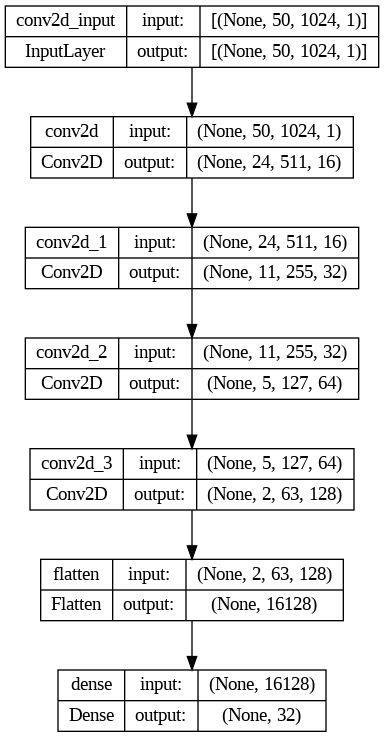

In [12]:
print("Printing encoder model:\n")
tf.keras.utils.plot_model(
    model.encoder,
    to_file="model_encoder.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False,
)

Printing decoder model:



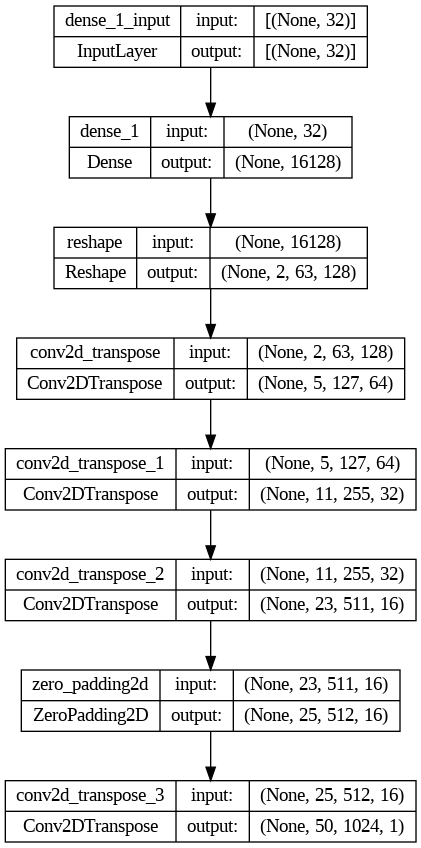

In [13]:
print("Printing decoder model:\n")
tf.keras.utils.plot_model(
    model.decoder,
    to_file="model_decoder.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False,
)

In [14]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7) ## train the network and stop with a patience of 7 monitoring the validation loss
history=model.fit(
        x=clean,
        y=clean,
        batch_size=32,
        epochs=500,
        callbacks=[callback],
        verbose=True,
        validation_data=(val,val), 
        shuffle=True,
    )

Epoch 1/500
125/125 [==============================] - 24s 68ms/step - loss: 108.4647 - val_loss: 43.2041
Epoch 2/500
125/125 [==============================] - 3s 25ms/step - loss: 42.3890 - val_loss: 42.2749
Epoch 3/500
125/125 [==============================] - 3s 25ms/step - loss: 41.9641 - val_loss: 42.4401
Epoch 4/500
125/125 [==============================] - 3s 25ms/step - loss: 41.4796 - val_loss: 41.8651
Epoch 5/500
125/125 [==============================] - 3s 24ms/step - loss: 41.1540 - val_loss: 40.7489
Epoch 6/500
125/125 [==============================] - 3s 24ms/step - loss: 40.5234 - val_loss: 41.1684
Epoch 7/500
125/125 [==============================] - 3s 26ms/step - loss: 40.1207 - val_loss: 40.6032
Epoch 8/500
125/125 [==============================] - 3s 27ms/step - loss: 39.9650 - val_loss: 40.0028
Epoch 9/500
125/125 [==============================] - 4s 34ms/step - loss: 39.6876 - val_loss: 39.5713
Epoch 10/500
125/125 [==============================] - 3s 25m

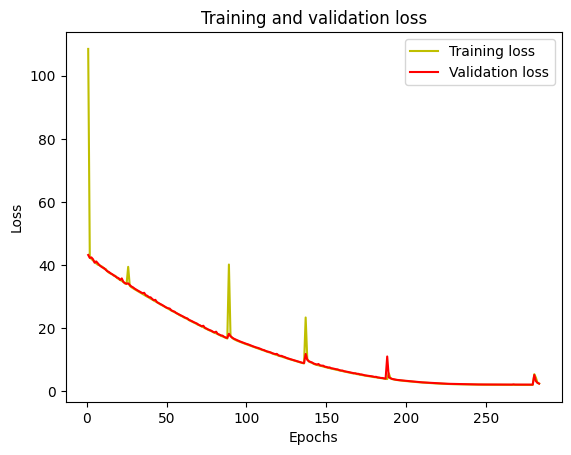

In [15]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
validation_error = model.evaluate(val,val)
anomaly_error = model.evaluate(anomalies,anomalies)
print("Validation error", validation_error)
print("Anomaly error", anomaly_error)
print("The reconstruction error of the jammed channel is ",anomaly_error/validation_error," more than the clean channel" )
## check if the reconstruction error is higher on some anomaly images

19/19 [==============================] - 1s 54ms/step - loss: 18.4423
Validation error 2.479403018951416
Anomaly error 18.442310333251953
The reconstruction error of the jammed channel is  7.438205968246153  more than the clean channel


In [17]:
## functions that computes the mean and the stdv of the reconstruction error
def calc_recon_error(batch_images):

    recon_error_list=[]
    for im in trange(0, batch_images.shape[0]):
        
        img  = batch_images[im]
        img= img.reshape(1,50,1024,1)
        recon_error_list.append(model.evaluate(img,img))
         
    
    average_recon_error = np.mean(np.array(recon_error_list))  
    stdev_recon_error = np.std(np.array(recon_error_list)) 
    maximum= max(recon_error_list) 
    minimum= min(recon_error_list)
    
    return average_recon_error, stdev_recon_error, maximum, minimum

In [18]:
normal_values = calc_recon_error(val)
jammed_values = calc_recon_error(anomalies)
## compute the statistics on the reconstruction error of both cases

  0%|          | 0/1600 [00:00<?, ?it/s]

1/1 [==============================] - 1s 569ms/step - loss: 2.6312


  0%|          | 1/1600 [00:00<17:10,  1.55it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.3725


  0%|          | 3/1600 [00:00<05:55,  4.49it/s]

1/1 [==============================] - 0s 24ms/step - loss: 3.0474


  0%|          | 5/1600 [00:00<03:52,  6.85it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.0183


  0%|          | 7/1600 [00:01<03:01,  8.77it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.6790


  1%|          | 9/1600 [00:01<02:30, 10.60it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9790


  1%|          | 11/1600 [00:01<02:16, 11.64it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.5078


  1%|          | 13/1600 [00:01<02:08, 12.38it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.6572


  1%|          | 15/1600 [00:01<02:01, 13.07it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9776


  1%|          | 17/1600 [00:01<01:55, 13.65it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.6520


  1%|          | 19/1600 [00:01<01:53, 13.94it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.5762


  1%|▏         | 21/1600 [00:02<01:50, 14.31it/s]

1/1 [==============================] - 0s 23ms/step - loss: 3.0207


  1%|▏         | 23/1600 [00:02<01:47, 14.62it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.7141


  2%|▏         | 25/1600 [00:02<01:45, 14.96it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9813


  2%|▏         | 27/1600 [00:02<01:48, 14.56it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.5044


  2%|▏         | 29/1600 [00:02<01:48, 14.49it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9773


  2%|▏         | 31/1600 [00:02<01:47, 14.63it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9885


  2%|▏         | 33/1600 [00:02<01:47, 14.54it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9616


  2%|▏         | 35/1600 [00:02<01:49, 14.27it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9946


  2%|▏         | 37/1600 [00:03<01:48, 14.39it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9799


  2%|▏         | 39/1600 [00:03<01:44, 15.00it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.4066


  3%|▎         | 41/1600 [00:03<01:44, 14.94it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.9568


  3%|▎         | 43/1600 [00:03<01:44, 14.97it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9747


  3%|▎         | 45/1600 [00:03<01:47, 14.51it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.7737


  3%|▎         | 47/1600 [00:03<01:44, 14.91it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1870


  3%|▎         | 49/1600 [00:03<01:50, 14.08it/s]

1/1 [==============================] - 0s 24ms/step - loss: 3.0013


  3%|▎         | 51/1600 [00:04<01:47, 14.43it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9918


  3%|▎         | 53/1600 [00:04<01:48, 14.32it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.3608


  3%|▎         | 55/1600 [00:04<01:46, 14.47it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.3395


  4%|▎         | 57/1600 [00:04<01:45, 14.63it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0297


  4%|▎         | 59/1600 [00:04<01:43, 14.85it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.6948


  4%|▍         | 61/1600 [00:04<01:46, 14.38it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9603


  4%|▍         | 63/1600 [00:04<01:47, 14.33it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.6887


  4%|▍         | 65/1600 [00:05<01:51, 13.78it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0021


  4%|▍         | 67/1600 [00:05<01:47, 14.20it/s]

1/1 [==============================] - 0s 27ms/step - loss: 12.6798


  4%|▍         | 69/1600 [00:05<01:48, 14.14it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0095


  4%|▍         | 71/1600 [00:05<01:46, 14.35it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0054


  5%|▍         | 73/1600 [00:05<01:44, 14.60it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9897


  5%|▍         | 75/1600 [00:05<01:41, 14.98it/s]

1/1 [==============================] - 0s 36ms/step - loss: 4.9700


  5%|▍         | 77/1600 [00:05<01:43, 14.68it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9748


  5%|▍         | 79/1600 [00:06<01:45, 14.44it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9632


  5%|▌         | 81/1600 [00:06<01:43, 14.64it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9753


  5%|▌         | 83/1600 [00:06<01:45, 14.33it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0116


  5%|▌         | 85/1600 [00:06<01:46, 14.29it/s]

1/1 [==============================] - 0s 26ms/step - loss: 4.9131


  5%|▌         | 87/1600 [00:06<01:43, 14.61it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0319


  6%|▌         | 89/1600 [00:06<01:40, 15.03it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.5389


  6%|▌         | 91/1600 [00:06<01:41, 14.90it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9981


  6%|▌         | 93/1600 [00:06<01:41, 14.90it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.5685


  6%|▌         | 95/1600 [00:07<01:40, 15.05it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.0080


  6%|▌         | 97/1600 [00:07<01:40, 14.94it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.4889


  6%|▌         | 99/1600 [00:07<01:41, 14.75it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9512


  6%|▋         | 101/1600 [00:07<01:43, 14.51it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9925


  6%|▋         | 103/1600 [00:07<01:40, 14.94it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9793


  7%|▋         | 105/1600 [00:07<01:37, 15.32it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.4059


  7%|▋         | 107/1600 [00:07<01:37, 15.31it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0045


  7%|▋         | 109/1600 [00:08<01:38, 15.08it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0119


  7%|▋         | 111/1600 [00:08<01:41, 14.66it/s]

1/1 [==============================] - 0s 34ms/step - loss: 1.9739


  7%|▋         | 113/1600 [00:08<01:42, 14.45it/s]

1/1 [==============================] - 0s 49ms/step - loss: 2.5482


  7%|▋         | 115/1600 [00:08<01:57, 12.67it/s]

1/1 [==============================] - 0s 33ms/step - loss: 1.9708


  7%|▋         | 117/1600 [00:08<02:03, 12.04it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9843


  7%|▋         | 119/1600 [00:08<02:09, 11.46it/s]

1/1 [==============================] - 0s 31ms/step - loss: 1.9767


  8%|▊         | 121/1600 [00:09<02:12, 11.13it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.7938


  8%|▊         | 123/1600 [00:09<02:10, 11.31it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.0212


  8%|▊         | 125/1600 [00:09<02:11, 11.20it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.0014


  8%|▊         | 127/1600 [00:09<02:11, 11.23it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9852


  8%|▊         | 129/1600 [00:09<02:13, 11.03it/s]

1/1 [==============================] - 0s 50ms/step - loss: 2.3837


  8%|▊         | 131/1600 [00:09<02:15, 10.80it/s]

1/1 [==============================] - 0s 39ms/step - loss: 1.9621


  8%|▊         | 133/1600 [00:10<02:16, 10.78it/s]

1/1 [==============================] - 0s 36ms/step - loss: 3.5639


  8%|▊         | 135/1600 [00:10<02:15, 10.80it/s]

1/1 [==============================] - 0s 24ms/step - loss: 3.0776


  9%|▊         | 137/1600 [00:10<02:09, 11.31it/s]

1/1 [==============================] - 0s 22ms/step - loss: 2.4049


  9%|▊         | 139/1600 [00:10<01:57, 12.46it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9949


  9%|▉         | 141/1600 [00:10<01:49, 13.33it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9721


  9%|▉         | 143/1600 [00:10<01:44, 13.93it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.7356


  9%|▉         | 145/1600 [00:11<01:44, 13.98it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.7770


  9%|▉         | 147/1600 [00:11<01:39, 14.64it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9928


  9%|▉         | 149/1600 [00:11<01:35, 15.20it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9790


  9%|▉         | 151/1600 [00:11<01:38, 14.70it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0284


 10%|▉         | 153/1600 [00:11<01:39, 14.51it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9862


 10%|▉         | 155/1600 [00:11<01:38, 14.73it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9728


 10%|▉         | 157/1600 [00:11<01:38, 14.61it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.5006


 10%|▉         | 159/1600 [00:11<01:37, 14.72it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.0685


 10%|█         | 161/1600 [00:12<01:38, 14.64it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.6627


 10%|█         | 163/1600 [00:12<01:37, 14.75it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.3401


 10%|█         | 165/1600 [00:12<01:34, 15.25it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.4219


 10%|█         | 167/1600 [00:12<01:34, 15.18it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.0156


 11%|█         | 169/1600 [00:12<01:32, 15.49it/s]

1/1 [==============================] - 0s 22ms/step - loss: 2.6184


 11%|█         | 171/1600 [00:12<01:33, 15.29it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0003


 11%|█         | 173/1600 [00:12<01:31, 15.60it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9690


 11%|█         | 175/1600 [00:13<01:31, 15.62it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9643


 11%|█         | 177/1600 [00:13<01:35, 14.83it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.5497


 11%|█         | 179/1600 [00:13<01:32, 15.36it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9972


 11%|█▏        | 181/1600 [00:13<01:32, 15.34it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0328


 11%|█▏        | 183/1600 [00:13<01:33, 15.14it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0102


 12%|█▏        | 185/1600 [00:13<01:33, 15.08it/s]

1/1 [==============================] - 0s 22ms/step - loss: 1.9965


 12%|█▏        | 187/1600 [00:13<01:31, 15.50it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9808


 12%|█▏        | 189/1600 [00:13<01:34, 15.00it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9823


 12%|█▏        | 191/1600 [00:14<01:39, 14.20it/s]

1/1 [==============================] - 0s 26ms/step - loss: 4.4923


 12%|█▏        | 193/1600 [00:14<01:36, 14.64it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.2413


 12%|█▏        | 195/1600 [00:14<01:32, 15.14it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.5071


 12%|█▏        | 197/1600 [00:14<01:34, 14.91it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.5737


 12%|█▏        | 199/1600 [00:14<01:36, 14.57it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.8856


 13%|█▎        | 201/1600 [00:14<01:35, 14.68it/s]

1/1 [==============================] - 0s 24ms/step - loss: 3.3785


 13%|█▎        | 203/1600 [00:14<01:35, 14.68it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9771


 13%|█▎        | 205/1600 [00:15<01:35, 14.65it/s]

1/1 [==============================] - 0s 31ms/step - loss: 1.9794


 13%|█▎        | 207/1600 [00:15<01:34, 14.77it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9865


 13%|█▎        | 209/1600 [00:15<01:36, 14.41it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9918


 13%|█▎        | 211/1600 [00:15<01:34, 14.66it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.9256


 13%|█▎        | 213/1600 [00:15<01:34, 14.65it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9848


 13%|█▎        | 215/1600 [00:15<01:32, 14.95it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.4784


 14%|█▎        | 217/1600 [00:15<01:32, 14.98it/s]

1/1 [==============================] - 0s 25ms/step - loss: 5.9880


 14%|█▎        | 219/1600 [00:15<01:32, 14.98it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0019


 14%|█▍        | 221/1600 [00:16<01:32, 14.87it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0125


 14%|█▍        | 223/1600 [00:16<01:34, 14.58it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.5456


 14%|█▍        | 225/1600 [00:16<01:35, 14.42it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9809


 14%|█▍        | 227/1600 [00:16<01:35, 14.34it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0055


 14%|█▍        | 229/1600 [00:16<01:34, 14.51it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0262


 14%|█▍        | 231/1600 [00:16<01:34, 14.50it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.9232


 15%|█▍        | 233/1600 [00:16<01:34, 14.47it/s]

1/1 [==============================] - 0s 24ms/step - loss: 4.4223


 15%|█▍        | 235/1600 [00:17<01:30, 15.02it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.2880


 15%|█▍        | 237/1600 [00:17<01:34, 14.47it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9706


 15%|█▍        | 239/1600 [00:17<01:32, 14.66it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0031


 15%|█▌        | 241/1600 [00:17<01:32, 14.65it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9550


 15%|█▌        | 243/1600 [00:17<01:30, 15.08it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9741


 15%|█▌        | 245/1600 [00:17<01:30, 14.90it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0076


 15%|█▌        | 247/1600 [00:17<01:31, 14.76it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9732


 16%|█▌        | 249/1600 [00:18<01:34, 14.30it/s]

1/1 [==============================] - 0s 27ms/step - loss: 3.0056


 16%|█▌        | 251/1600 [00:18<01:35, 14.11it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9953


 16%|█▌        | 253/1600 [00:18<01:32, 14.57it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0164


 16%|█▌        | 255/1600 [00:18<01:35, 14.13it/s]

1/1 [==============================] - 0s 24ms/step - loss: 3.2259


 16%|█▌        | 257/1600 [00:18<01:36, 13.85it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0131


 16%|█▌        | 259/1600 [00:18<01:35, 14.04it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9826


 16%|█▋        | 261/1600 [00:18<01:32, 14.53it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9823


 16%|█▋        | 263/1600 [00:19<01:32, 14.50it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.0074


 17%|█▋        | 265/1600 [00:19<01:32, 14.47it/s]

1/1 [==============================] - 0s 24ms/step - loss: 3.2155


 17%|█▋        | 267/1600 [00:19<01:34, 14.14it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9976


 17%|█▋        | 269/1600 [00:19<01:31, 14.61it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9729


 17%|█▋        | 271/1600 [00:19<01:30, 14.62it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9911


 17%|█▋        | 273/1600 [00:19<01:32, 14.38it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.5092


 17%|█▋        | 275/1600 [00:19<01:31, 14.48it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9956


 17%|█▋        | 277/1600 [00:20<01:34, 14.03it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9838


 17%|█▋        | 279/1600 [00:20<01:30, 14.55it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9732


 18%|█▊        | 281/1600 [00:20<01:35, 13.87it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.4720


 18%|█▊        | 283/1600 [00:20<01:32, 14.28it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.5927


 18%|█▊        | 285/1600 [00:20<01:39, 13.18it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.4588


 18%|█▊        | 287/1600 [00:20<01:46, 12.37it/s]

1/1 [==============================] - 0s 34ms/step - loss: 1.9879


 18%|█▊        | 289/1600 [00:20<01:52, 11.70it/s]

1/1 [==============================] - 0s 37ms/step - loss: 1.9738


 18%|█▊        | 291/1600 [00:21<01:53, 11.50it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.0130


 18%|█▊        | 293/1600 [00:21<01:56, 11.18it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.7096


 18%|█▊        | 295/1600 [00:21<01:56, 11.21it/s]

1/1 [==============================] - 0s 33ms/step - loss: 3.2991


 19%|█▊        | 297/1600 [00:21<01:58, 10.98it/s]

1/1 [==============================] - 0s 32ms/step - loss: 4.6959


 19%|█▊        | 299/1600 [00:21<01:57, 11.06it/s]

1/1 [==============================] - 0s 32ms/step - loss: 5.0780


 19%|█▉        | 301/1600 [00:22<01:58, 10.97it/s]

1/1 [==============================] - 0s 39ms/step - loss: 1.9861


 19%|█▉        | 303/1600 [00:22<01:57, 11.05it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.0249


 19%|█▉        | 305/1600 [00:22<02:00, 10.73it/s]

1/1 [==============================] - 0s 36ms/step - loss: 1.9770


 19%|█▉        | 307/1600 [00:22<01:59, 10.82it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.5194


 19%|█▉        | 309/1600 [00:22<01:56, 11.08it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9942


 19%|█▉        | 311/1600 [00:22<01:48, 11.93it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9894


 20%|█▉        | 313/1600 [00:23<01:44, 12.26it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1711


 20%|█▉        | 315/1600 [00:23<01:39, 12.91it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9629


 20%|█▉        | 317/1600 [00:23<01:36, 13.30it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9849


 20%|█▉        | 319/1600 [00:23<01:31, 13.95it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0163


 20%|██        | 321/1600 [00:23<01:31, 13.98it/s]

1/1 [==============================] - 0s 22ms/step - loss: 1.9933


 20%|██        | 323/1600 [00:23<01:29, 14.27it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.2937


 20%|██        | 325/1600 [00:23<01:28, 14.34it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9850


 20%|██        | 327/1600 [00:24<01:28, 14.39it/s]

1/1 [==============================] - 0s 26ms/step - loss: 4.9787


 21%|██        | 329/1600 [00:24<01:28, 14.35it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9739


 21%|██        | 331/1600 [00:24<01:27, 14.44it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.6779


 21%|██        | 333/1600 [00:24<01:30, 13.97it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9948


 21%|██        | 335/1600 [00:24<01:28, 14.22it/s]

1/1 [==============================] - 0s 23ms/step - loss: 3.8590


 21%|██        | 337/1600 [00:24<01:29, 14.08it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.3703


 21%|██        | 339/1600 [00:24<01:27, 14.35it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9876


 21%|██▏       | 341/1600 [00:25<01:27, 14.35it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.9156


 21%|██▏       | 343/1600 [00:25<01:25, 14.78it/s]

1/1 [==============================] - 0s 36ms/step - loss: 3.1454


 22%|██▏       | 345/1600 [00:25<01:27, 14.39it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9816


 22%|██▏       | 347/1600 [00:25<02:43,  7.66it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9969


 22%|██▏       | 349/1600 [00:26<02:21,  8.82it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9929


 22%|██▏       | 351/1600 [00:26<02:08,  9.70it/s]

1/1 [==============================] - 0s 40ms/step - loss: 1.9812


 22%|██▏       | 353/1600 [00:26<01:59, 10.42it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.8737


 22%|██▏       | 355/1600 [00:26<01:53, 10.99it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9908


 22%|██▏       | 357/1600 [00:26<01:47, 11.58it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9859


 22%|██▏       | 359/1600 [00:26<01:41, 12.25it/s]

1/1 [==============================] - 0s 30ms/step - loss: 3.0674


 23%|██▎       | 361/1600 [00:26<01:38, 12.53it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.7398


 23%|██▎       | 363/1600 [00:27<01:38, 12.56it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.0056


 23%|██▎       | 365/1600 [00:27<01:35, 12.99it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.2314


 23%|██▎       | 367/1600 [00:27<01:34, 13.11it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.4757


 23%|██▎       | 369/1600 [00:27<01:31, 13.45it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9820


 23%|██▎       | 371/1600 [00:27<01:34, 12.95it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0025


 23%|██▎       | 373/1600 [00:27<01:31, 13.47it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9928


 23%|██▎       | 375/1600 [00:27<01:29, 13.64it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.6264


 24%|██▎       | 377/1600 [00:28<01:26, 14.09it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9895


 24%|██▎       | 379/1600 [00:28<01:29, 13.71it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9968


 24%|██▍       | 381/1600 [00:28<01:30, 13.45it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9747


 24%|██▍       | 383/1600 [00:28<01:31, 13.34it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.6940


 24%|██▍       | 385/1600 [00:28<01:27, 13.83it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.5476


 24%|██▍       | 387/1600 [00:28<01:29, 13.52it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9791


 24%|██▍       | 389/1600 [00:28<01:28, 13.76it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9989


 24%|██▍       | 391/1600 [00:29<01:26, 13.95it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.4585


 25%|██▍       | 393/1600 [00:29<01:24, 14.26it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9547


 25%|██▍       | 395/1600 [00:29<01:27, 13.85it/s]

1/1 [==============================] - 0s 27ms/step - loss: 4.4424


 25%|██▍       | 397/1600 [00:29<01:26, 13.94it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0083


 25%|██▍       | 399/1600 [00:29<01:23, 14.42it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.0325


 25%|██▌       | 401/1600 [00:29<01:25, 13.97it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9819


 25%|██▌       | 403/1600 [00:29<01:25, 13.94it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0095


 25%|██▌       | 405/1600 [00:30<01:25, 13.97it/s]

1/1 [==============================] - 0s 24ms/step - loss: 3.1931


 25%|██▌       | 407/1600 [00:30<01:25, 13.97it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0129


 26%|██▌       | 409/1600 [00:30<01:25, 13.99it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9795


 26%|██▌       | 411/1600 [00:30<01:25, 13.83it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.8501


 26%|██▌       | 413/1600 [00:30<01:25, 13.89it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.8465


 26%|██▌       | 415/1600 [00:30<01:24, 13.96it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9673


 26%|██▌       | 417/1600 [00:30<01:24, 13.94it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.4536


 26%|██▌       | 419/1600 [00:31<01:23, 14.14it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9381


 26%|██▋       | 421/1600 [00:31<01:24, 14.00it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.6164


 26%|██▋       | 423/1600 [00:31<01:28, 13.36it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.6399


 27%|██▋       | 425/1600 [00:31<01:25, 13.67it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9707


 27%|██▋       | 427/1600 [00:31<01:28, 13.20it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.4364


 27%|██▋       | 429/1600 [00:31<01:25, 13.65it/s]

1/1 [==============================] - 0s 27ms/step - loss: 7.4520


 27%|██▋       | 431/1600 [00:31<01:23, 14.08it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0032


 27%|██▋       | 433/1600 [00:32<01:21, 14.36it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9779


 27%|██▋       | 435/1600 [00:32<01:21, 14.28it/s]

1/1 [==============================] - 0s 25ms/step - loss: 6.7914


 27%|██▋       | 437/1600 [00:32<01:19, 14.55it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9785


 27%|██▋       | 439/1600 [00:32<01:21, 14.23it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9859


 28%|██▊       | 441/1600 [00:32<01:21, 14.18it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.4702


 28%|██▊       | 443/1600 [00:32<01:27, 13.17it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.5648


 28%|██▊       | 445/1600 [00:33<01:35, 12.09it/s]

1/1 [==============================] - 0s 39ms/step - loss: 1.9583


 28%|██▊       | 447/1600 [00:33<01:43, 11.11it/s]

1/1 [==============================] - 0s 46ms/step - loss: 2.8860


 28%|██▊       | 449/1600 [00:33<01:49, 10.56it/s]

1/1 [==============================] - 0s 34ms/step - loss: 1.9869


 28%|██▊       | 451/1600 [00:33<01:51, 10.34it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.0509


 28%|██▊       | 453/1600 [00:33<01:49, 10.48it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.0024


 28%|██▊       | 455/1600 [00:34<01:48, 10.52it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.0048


 29%|██▊       | 457/1600 [00:34<01:46, 10.71it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.9392


 29%|██▊       | 459/1600 [00:34<01:46, 10.72it/s]

1/1 [==============================] - 0s 37ms/step - loss: 1.9861


 29%|██▉       | 461/1600 [00:34<01:47, 10.56it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.0237


 29%|██▉       | 463/1600 [00:34<01:48, 10.50it/s]

1/1 [==============================] - 0s 35ms/step - loss: 1.9908


 29%|██▉       | 465/1600 [00:35<01:49, 10.34it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.6930


 29%|██▉       | 467/1600 [00:35<01:50, 10.26it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9471


 29%|██▉       | 469/1600 [00:35<01:41, 11.16it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9776


 29%|██▉       | 471/1600 [00:35<01:35, 11.87it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.6925


 30%|██▉       | 473/1600 [00:35<01:31, 12.26it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9957


 30%|██▉       | 475/1600 [00:35<01:31, 12.23it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9607


 30%|██▉       | 477/1600 [00:35<01:27, 12.79it/s]

1/1 [==============================] - 0s 22ms/step - loss: 2.5943


 30%|██▉       | 479/1600 [00:36<01:24, 13.29it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0217


 30%|███       | 481/1600 [00:36<01:22, 13.63it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9753


 30%|███       | 483/1600 [00:36<01:20, 13.82it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9930


 30%|███       | 485/1600 [00:36<01:19, 13.99it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9853


 30%|███       | 487/1600 [00:36<01:20, 13.79it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9832


 31%|███       | 489/1600 [00:36<01:18, 14.20it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.7019


 31%|███       | 491/1600 [00:36<01:18, 14.05it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9896


 31%|███       | 493/1600 [00:37<01:18, 14.14it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9690


 31%|███       | 495/1600 [00:37<01:19, 13.87it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9959


 31%|███       | 497/1600 [00:37<01:17, 14.17it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9725


 31%|███       | 499/1600 [00:37<01:18, 13.99it/s]

1/1 [==============================] - 0s 26ms/step - loss: 3.3146


 31%|███▏      | 501/1600 [00:37<01:19, 13.82it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9909


 31%|███▏      | 503/1600 [00:37<01:17, 14.07it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9867


 32%|███▏      | 505/1600 [00:37<01:16, 14.38it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0252


 32%|███▏      | 507/1600 [00:38<01:16, 14.37it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0048


 32%|███▏      | 509/1600 [00:38<01:15, 14.47it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.6287


 32%|███▏      | 511/1600 [00:38<01:15, 14.41it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.6768


 32%|███▏      | 513/1600 [00:38<01:15, 14.31it/s]

1/1 [==============================] - 0s 22ms/step - loss: 2.0279


 32%|███▏      | 515/1600 [00:38<01:18, 13.88it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9863


 32%|███▏      | 517/1600 [00:38<01:18, 13.84it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.0863


 32%|███▏      | 519/1600 [00:38<01:16, 14.06it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.0100


 33%|███▎      | 521/1600 [00:39<01:15, 14.26it/s]

1/1 [==============================] - 0s 24ms/step - loss: 4.8301


 33%|███▎      | 523/1600 [00:39<01:16, 14.02it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0216


 33%|███▎      | 525/1600 [00:39<01:16, 14.03it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.3280


 33%|███▎      | 527/1600 [00:39<01:15, 14.17it/s]

1/1 [==============================] - 0s 27ms/step - loss: 9.8782


 33%|███▎      | 529/1600 [00:39<01:17, 13.80it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0571


 33%|███▎      | 531/1600 [00:39<01:18, 13.63it/s]

1/1 [==============================] - 0s 27ms/step - loss: 11.2107


 33%|███▎      | 533/1600 [00:39<01:19, 13.46it/s]

1/1 [==============================] - 0s 27ms/step - loss: 4.9263


 33%|███▎      | 535/1600 [00:40<01:17, 13.66it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.4078


 34%|███▎      | 537/1600 [00:40<01:18, 13.61it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.6318


 34%|███▎      | 539/1600 [00:40<01:18, 13.54it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.5655


 34%|███▍      | 541/1600 [00:40<01:18, 13.46it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1965


 34%|███▍      | 543/1600 [00:40<01:17, 13.60it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.3935


 34%|███▍      | 545/1600 [00:40<01:18, 13.49it/s]

1/1 [==============================] - 0s 27ms/step - loss: 5.3342


 34%|███▍      | 547/1600 [00:40<01:17, 13.61it/s]

1/1 [==============================] - 0s 29ms/step - loss: 12.6759


 34%|███▍      | 549/1600 [00:41<01:16, 13.74it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.7071


 34%|███▍      | 551/1600 [00:41<01:14, 14.07it/s]

1/1 [==============================] - 0s 28ms/step - loss: 3.1354


 35%|███▍      | 553/1600 [00:41<01:14, 14.03it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9935


 35%|███▍      | 555/1600 [00:41<01:14, 13.97it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.6253


 35%|███▍      | 557/1600 [00:41<01:14, 14.01it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.7886


 35%|███▍      | 559/1600 [00:41<01:17, 13.49it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.8874


 35%|███▌      | 561/1600 [00:41<01:15, 13.84it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9837


 35%|███▌      | 563/1600 [00:42<01:16, 13.60it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9941


 35%|███▌      | 565/1600 [00:42<01:15, 13.66it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.7684


 35%|███▌      | 567/1600 [00:42<01:13, 13.96it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9834


 36%|███▌      | 569/1600 [00:42<01:14, 13.84it/s]

1/1 [==============================] - 0s 25ms/step - loss: 4.7501


 36%|███▌      | 571/1600 [00:42<01:15, 13.59it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9874


 36%|███▌      | 573/1600 [00:42<01:16, 13.51it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.7556


 36%|███▌      | 575/1600 [00:43<01:15, 13.66it/s]

1/1 [==============================] - 0s 23ms/step - loss: 3.0535


 36%|███▌      | 577/1600 [00:43<01:13, 13.91it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.4268


 36%|███▌      | 579/1600 [00:43<01:13, 13.86it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9568


 36%|███▋      | 581/1600 [00:43<01:11, 14.28it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.0308


 36%|███▋      | 583/1600 [00:43<01:11, 14.14it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.9795


 37%|███▋      | 585/1600 [00:43<01:13, 13.87it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9733


 37%|███▋      | 587/1600 [00:43<01:13, 13.70it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.0025


 37%|███▋      | 589/1600 [00:44<01:14, 13.61it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0091


 37%|███▋      | 591/1600 [00:44<01:10, 14.24it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.8555


 37%|███▋      | 593/1600 [00:44<01:10, 14.21it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9884


 37%|███▋      | 595/1600 [00:44<01:11, 13.99it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0017


 37%|███▋      | 597/1600 [00:44<01:10, 14.15it/s]

1/1 [==============================] - 0s 33ms/step - loss: 1.9865


 37%|███▋      | 599/1600 [00:44<01:11, 14.04it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.5613


 38%|███▊      | 601/1600 [00:44<01:11, 14.03it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.8510


 38%|███▊      | 603/1600 [00:45<01:12, 13.75it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.7738


 38%|███▊      | 605/1600 [00:45<01:12, 13.71it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.5515


 38%|███▊      | 607/1600 [00:45<01:14, 13.36it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.0196


 38%|███▊      | 609/1600 [00:45<01:20, 12.26it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.9135


 38%|███▊      | 611/1600 [00:45<01:23, 11.89it/s]

1/1 [==============================] - 0s 33ms/step - loss: 1.9654


 38%|███▊      | 613/1600 [00:45<01:28, 11.12it/s]

1/1 [==============================] - 0s 33ms/step - loss: 1.9996


 38%|███▊      | 615/1600 [00:46<01:30, 10.89it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.5813


 39%|███▊      | 617/1600 [00:46<01:30, 10.89it/s]

1/1 [==============================] - 0s 35ms/step - loss: 3.8617


 39%|███▊      | 619/1600 [00:46<01:30, 10.79it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.2443


 39%|███▉      | 621/1600 [00:46<01:37, 10.03it/s]

1/1 [==============================] - 0s 38ms/step - loss: 1.9862


 39%|███▉      | 623/1600 [00:46<01:39,  9.86it/s]

1/1 [==============================] - 0s 35ms/step - loss: 3.0572


 39%|███▉      | 625/1600 [00:47<01:35, 10.19it/s]

1/1 [==============================] - 0s 31ms/step - loss: 3.6349


 39%|███▉      | 627/1600 [00:47<01:35, 10.19it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.0891


 39%|███▉      | 629/1600 [00:47<01:36, 10.04it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.0033


 39%|███▉      | 631/1600 [00:47<01:35, 10.16it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9894


 40%|███▉      | 633/1600 [00:47<01:28, 10.98it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9758


 40%|███▉      | 635/1600 [00:47<01:22, 11.65it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9619


 40%|███▉      | 637/1600 [00:48<01:19, 12.10it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.4665


 40%|███▉      | 639/1600 [00:48<01:16, 12.61it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9726


 40%|████      | 641/1600 [00:48<01:14, 12.94it/s]

1/1 [==============================] - 0s 24ms/step - loss: 3.1204


 40%|████      | 643/1600 [00:48<01:12, 13.11it/s]

1/1 [==============================] - 0s 29ms/step - loss: 3.0998


 40%|████      | 645/1600 [00:48<01:11, 13.28it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.5708


 40%|████      | 647/1600 [00:48<01:11, 13.26it/s]

1/1 [==============================] - 0s 31ms/step - loss: 3.1089


 41%|████      | 649/1600 [00:49<01:11, 13.39it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9663


 41%|████      | 651/1600 [00:49<01:09, 13.61it/s]

1/1 [==============================] - 0s 25ms/step - loss: 3.5201


 41%|████      | 653/1600 [00:49<01:09, 13.65it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9861


 41%|████      | 655/1600 [00:49<01:08, 13.89it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9957


 41%|████      | 657/1600 [00:49<01:07, 13.93it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9980


 41%|████      | 659/1600 [00:49<01:08, 13.74it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.0062


 41%|████▏     | 661/1600 [00:49<01:09, 13.48it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.3905


 41%|████▏     | 663/1600 [00:50<01:09, 13.48it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.4319


 42%|████▏     | 665/1600 [00:50<01:07, 13.83it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9789


 42%|████▏     | 667/1600 [00:50<01:06, 13.99it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.6645


 42%|████▏     | 669/1600 [00:50<01:08, 13.56it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.8753


 42%|████▏     | 671/1600 [00:50<01:06, 13.96it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1058


 42%|████▏     | 673/1600 [00:50<01:06, 14.01it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.9969


 42%|████▏     | 675/1600 [00:50<01:07, 13.77it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.7940


 42%|████▏     | 677/1600 [00:51<01:08, 13.53it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9703


 42%|████▏     | 679/1600 [00:51<01:06, 13.86it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.7215


 43%|████▎     | 681/1600 [00:51<01:06, 13.85it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.6649


 43%|████▎     | 683/1600 [00:51<01:04, 14.13it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.6406


 43%|████▎     | 685/1600 [00:51<01:05, 13.89it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.4772


 43%|████▎     | 687/1600 [00:51<01:05, 13.89it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.4206


 43%|████▎     | 689/1600 [00:51<01:07, 13.46it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1347


 43%|████▎     | 691/1600 [00:52<01:07, 13.55it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0213


 43%|████▎     | 693/1600 [00:52<01:07, 13.47it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.2216


 43%|████▎     | 695/1600 [00:52<01:06, 13.62it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9579


 44%|████▎     | 697/1600 [00:52<01:04, 13.90it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.0134


 44%|████▎     | 699/1600 [00:52<01:06, 13.62it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.3596


 44%|████▍     | 701/1600 [00:52<01:06, 13.55it/s]

1/1 [==============================] - 0s 25ms/step - loss: 3.1412


 44%|████▍     | 703/1600 [00:52<01:06, 13.48it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.4401


 44%|████▍     | 705/1600 [00:53<01:04, 13.79it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.4851


 44%|████▍     | 707/1600 [00:53<01:04, 13.78it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.8309


 44%|████▍     | 709/1600 [00:53<01:05, 13.64it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.7103


 44%|████▍     | 711/1600 [00:53<01:05, 13.55it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0041


 45%|████▍     | 713/1600 [00:53<01:04, 13.75it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.9529


 45%|████▍     | 715/1600 [00:53<01:04, 13.70it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.4899


 45%|████▍     | 717/1600 [00:53<01:07, 13.13it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9865


 45%|████▍     | 719/1600 [00:54<01:06, 13.22it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9871


 45%|████▌     | 721/1600 [00:54<01:05, 13.48it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0079


 45%|████▌     | 723/1600 [00:54<01:04, 13.57it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9861


 45%|████▌     | 725/1600 [00:54<01:05, 13.45it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9942


 45%|████▌     | 727/1600 [00:54<01:05, 13.41it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.8094


 46%|████▌     | 729/1600 [00:54<01:05, 13.37it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.0041


 46%|████▌     | 731/1600 [00:55<01:05, 13.31it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9772


 46%|████▌     | 733/1600 [00:55<01:05, 13.21it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9681


 46%|████▌     | 735/1600 [00:55<01:05, 13.26it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.6875


 46%|████▌     | 737/1600 [00:55<01:03, 13.56it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.8253


 46%|████▌     | 739/1600 [00:55<01:02, 13.72it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9793


 46%|████▋     | 741/1600 [00:55<01:01, 13.93it/s]

1/1 [==============================] - 0s 31ms/step - loss: 1.9929


 46%|████▋     | 743/1600 [00:55<01:04, 13.35it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9970


 47%|████▋     | 745/1600 [00:56<01:04, 13.30it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9933


 47%|████▋     | 747/1600 [00:56<01:02, 13.63it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.4811


 47%|████▋     | 749/1600 [00:56<01:04, 13.24it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9726


 47%|████▋     | 751/1600 [00:56<01:03, 13.27it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9371


 47%|████▋     | 753/1600 [00:56<01:04, 13.05it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0142


 47%|████▋     | 755/1600 [00:56<01:03, 13.35it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9879


 47%|████▋     | 757/1600 [00:56<01:02, 13.44it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9641


 47%|████▋     | 759/1600 [00:57<01:04, 13.12it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.9308


 48%|████▊     | 761/1600 [00:57<01:02, 13.33it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9893


 48%|████▊     | 763/1600 [00:57<01:02, 13.39it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0036


 48%|████▊     | 765/1600 [00:57<01:00, 13.79it/s]

1/1 [==============================] - 0s 28ms/step - loss: 5.8475


 48%|████▊     | 767/1600 [00:57<01:01, 13.56it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.9281


 48%|████▊     | 769/1600 [00:57<01:07, 12.39it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.0084


 48%|████▊     | 771/1600 [00:58<01:11, 11.64it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.0030


 48%|████▊     | 773/1600 [00:58<01:13, 11.31it/s]

1/1 [==============================] - 0s 34ms/step - loss: 1.9888


 48%|████▊     | 775/1600 [00:58<01:14, 11.07it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.2943


 49%|████▊     | 777/1600 [00:58<01:14, 11.06it/s]

1/1 [==============================] - 0s 31ms/step - loss: 3.9141


 49%|████▊     | 779/1600 [00:58<01:15, 10.87it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.3196


 49%|████▉     | 781/1600 [00:59<01:16, 10.76it/s]

1/1 [==============================] - 0s 33ms/step - loss: 1.9605


 49%|████▉     | 783/1600 [00:59<01:18, 10.36it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.4740


 49%|████▉     | 785/1600 [00:59<01:18, 10.34it/s]

1/1 [==============================] - 0s 31ms/step - loss: 5.0847


 49%|████▉     | 787/1600 [00:59<01:18, 10.31it/s]

1/1 [==============================] - 0s 32ms/step - loss: 3.1038


 49%|████▉     | 789/1600 [00:59<01:17, 10.49it/s]

1/1 [==============================] - 0s 34ms/step - loss: 3.0300


 49%|████▉     | 791/1600 [01:00<01:18, 10.26it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.6220


 50%|████▉     | 793/1600 [01:00<01:18, 10.22it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9774


 50%|████▉     | 795/1600 [01:00<01:14, 10.85it/s]

1/1 [==============================] - 0s 24ms/step - loss: 3.0615


 50%|████▉     | 797/1600 [01:00<01:09, 11.61it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9728


 50%|████▉     | 799/1600 [01:00<01:06, 12.02it/s]

1/1 [==============================] - 0s 23ms/step - loss: 3.1814


 50%|█████     | 801/1600 [01:00<01:04, 12.39it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9646


 50%|█████     | 803/1600 [01:00<01:01, 13.04it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9674


 50%|█████     | 805/1600 [01:01<01:00, 13.20it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9827


 50%|█████     | 807/1600 [01:01<01:00, 13.18it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.8291


 51%|█████     | 809/1600 [01:01<00:57, 13.65it/s]

1/1 [==============================] - 0s 25ms/step - loss: 5.2824


 51%|█████     | 811/1600 [01:01<00:57, 13.80it/s]

1/1 [==============================] - 0s 22ms/step - loss: 2.8281


 51%|█████     | 813/1600 [01:01<00:56, 14.03it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9891


 51%|█████     | 815/1600 [01:01<00:57, 13.54it/s]

1/1 [==============================] - 0s 28ms/step - loss: 3.3356


 51%|█████     | 817/1600 [01:01<00:58, 13.50it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9846


 51%|█████     | 819/1600 [01:02<00:58, 13.33it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9669


 51%|█████▏    | 821/1600 [01:02<00:58, 13.28it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.5401


 51%|█████▏    | 823/1600 [01:02<00:58, 13.33it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.6600


 52%|█████▏    | 825/1600 [01:02<00:57, 13.47it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.9380


 52%|█████▏    | 827/1600 [01:02<00:59, 12.97it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0035


 52%|█████▏    | 829/1600 [01:02<00:59, 12.88it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.5831


 52%|█████▏    | 831/1600 [01:03<00:59, 12.90it/s]

1/1 [==============================] - 0s 30ms/step - loss: 4.7221


 52%|█████▏    | 833/1600 [01:03<00:59, 12.79it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9964


 52%|█████▏    | 835/1600 [01:03<00:57, 13.23it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.6349


 52%|█████▏    | 837/1600 [01:03<00:57, 13.21it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.5257


 52%|█████▏    | 839/1600 [01:03<00:59, 12.82it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.6277


 53%|█████▎    | 841/1600 [01:03<00:59, 12.73it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.4384


 53%|█████▎    | 843/1600 [01:03<01:00, 12.54it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.7741


 53%|█████▎    | 845/1600 [01:04<01:01, 12.36it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9930


 53%|█████▎    | 847/1600 [01:04<01:03, 11.92it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.0524


 53%|█████▎    | 849/1600 [01:04<00:59, 12.58it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0002


 53%|█████▎    | 851/1600 [01:04<00:58, 12.88it/s]

1/1 [==============================] - 0s 28ms/step - loss: 6.3294


 53%|█████▎    | 853/1600 [01:04<00:56, 13.34it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.4984


 53%|█████▎    | 855/1600 [01:04<00:57, 12.92it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0101


 54%|█████▎    | 857/1600 [01:05<00:56, 13.06it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9839


 54%|█████▎    | 859/1600 [01:05<00:56, 13.17it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.4162


 54%|█████▍    | 861/1600 [01:05<00:55, 13.40it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.1083


 54%|█████▍    | 863/1600 [01:05<00:54, 13.42it/s]

1/1 [==============================] - 0s 31ms/step - loss: 1.9849


 54%|█████▍    | 865/1600 [01:05<00:54, 13.48it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9909


 54%|█████▍    | 867/1600 [01:05<00:53, 13.70it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0283


 54%|█████▍    | 869/1600 [01:05<00:53, 13.70it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.0117


 54%|█████▍    | 871/1600 [01:06<00:54, 13.41it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0586


 55%|█████▍    | 873/1600 [01:06<00:54, 13.40it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0101


 55%|█████▍    | 875/1600 [01:06<00:53, 13.49it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.8742


 55%|█████▍    | 877/1600 [01:06<00:52, 13.83it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.8791


 55%|█████▍    | 879/1600 [01:06<00:53, 13.51it/s]

1/1 [==============================] - 0s 31ms/step - loss: 1.9565


 55%|█████▌    | 881/1600 [01:06<00:54, 13.26it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.6738


 55%|█████▌    | 883/1600 [01:06<00:53, 13.28it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.6622


 55%|█████▌    | 885/1600 [01:07<00:52, 13.56it/s]

1/1 [==============================] - 0s 25ms/step - loss: 3.0563


 55%|█████▌    | 887/1600 [01:07<00:54, 13.11it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9915


 56%|█████▌    | 889/1600 [01:07<00:52, 13.45it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.5962


 56%|█████▌    | 891/1600 [01:07<00:53, 13.34it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.6304


 56%|█████▌    | 893/1600 [01:07<00:51, 13.67it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9889


 56%|█████▌    | 895/1600 [01:07<00:51, 13.62it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.2073


 56%|█████▌    | 897/1600 [01:08<00:51, 13.71it/s]

1/1 [==============================] - 0s 29ms/step - loss: 3.0448


 56%|█████▌    | 899/1600 [01:08<00:51, 13.71it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.8380


 56%|█████▋    | 901/1600 [01:08<00:51, 13.66it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.4010


 56%|█████▋    | 903/1600 [01:08<00:51, 13.45it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9743


 57%|█████▋    | 905/1600 [01:08<00:51, 13.58it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.8006


 57%|█████▋    | 907/1600 [01:08<00:51, 13.42it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.0248


 57%|█████▋    | 909/1600 [01:08<00:51, 13.31it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9630


 57%|█████▋    | 911/1600 [01:09<00:51, 13.42it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.8132


 57%|█████▋    | 913/1600 [01:09<00:52, 13.18it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.6175


 57%|█████▋    | 915/1600 [01:09<00:53, 12.87it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9747


 57%|█████▋    | 917/1600 [01:09<00:52, 13.07it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9542


 57%|█████▋    | 919/1600 [01:09<00:51, 13.10it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9958


 58%|█████▊    | 921/1600 [01:09<00:52, 13.03it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.6074


 58%|█████▊    | 923/1600 [01:09<00:51, 13.20it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0046


 58%|█████▊    | 925/1600 [01:10<00:48, 13.86it/s]

1/1 [==============================] - 0s 28ms/step - loss: 3.3638


 58%|█████▊    | 927/1600 [01:10<00:49, 13.73it/s]

1/1 [==============================] - 0s 40ms/step - loss: 2.0057


 58%|█████▊    | 929/1600 [01:10<00:56, 11.87it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.4844


 58%|█████▊    | 931/1600 [01:10<00:58, 11.36it/s]

1/1 [==============================] - 0s 32ms/step - loss: 3.0949


 58%|█████▊    | 933/1600 [01:10<01:00, 11.07it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.0241


 58%|█████▊    | 935/1600 [01:11<01:01, 10.87it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.9425


 59%|█████▊    | 937/1600 [01:11<01:03, 10.37it/s]

1/1 [==============================] - 0s 32ms/step - loss: 3.1459


 59%|█████▊    | 939/1600 [01:11<01:03, 10.33it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9856


 59%|█████▉    | 941/1600 [01:11<01:03, 10.45it/s]

1/1 [==============================] - 0s 36ms/step - loss: 1.9842


 59%|█████▉    | 943/1600 [01:11<01:02, 10.49it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.6860


 59%|█████▉    | 945/1600 [01:12<01:03, 10.31it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9696


 59%|█████▉    | 947/1600 [01:12<01:05, 10.04it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.0059


 59%|█████▉    | 949/1600 [01:12<01:06,  9.77it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.0095


 59%|█████▉    | 951/1600 [01:12<01:05,  9.94it/s]

1/1 [==============================] - 0s 40ms/step - loss: 2.0174


 60%|█████▉    | 952/1600 [01:12<01:05,  9.85it/s]

1/1 [==============================] - 0s 36ms/step - loss: 1.9890


 60%|█████▉    | 953/1600 [01:12<01:06,  9.72it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9780


 60%|█████▉    | 955/1600 [01:13<00:59, 10.76it/s]

1/1 [==============================] - 0s 25ms/step - loss: 4.4696


 60%|█████▉    | 957/1600 [01:13<00:54, 11.71it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.1974


 60%|█████▉    | 959/1600 [01:13<00:51, 12.47it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9819


 60%|██████    | 961/1600 [01:13<00:51, 12.43it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9907


 60%|██████    | 963/1600 [01:13<00:50, 12.68it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.0056


 60%|██████    | 965/1600 [01:13<00:48, 13.07it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0374


 60%|██████    | 967/1600 [01:13<00:48, 13.07it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9995


 61%|██████    | 969/1600 [01:14<00:48, 12.95it/s]

1/1 [==============================] - 0s 29ms/step - loss: 4.6493


 61%|██████    | 971/1600 [01:14<00:48, 13.07it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.7656


 61%|██████    | 973/1600 [01:14<00:47, 13.29it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9833


 61%|██████    | 975/1600 [01:14<00:46, 13.51it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.7975


 61%|██████    | 977/1600 [01:14<00:46, 13.35it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9847


 61%|██████    | 979/1600 [01:14<00:46, 13.50it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.5443


 61%|██████▏   | 981/1600 [01:14<00:44, 13.83it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.0075


 61%|██████▏   | 983/1600 [01:15<00:44, 13.77it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0053


 62%|██████▏   | 985/1600 [01:15<00:44, 13.78it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.0128


 62%|██████▏   | 987/1600 [01:15<00:45, 13.57it/s]

1/1 [==============================] - 0s 35ms/step - loss: 1.9756


 62%|██████▏   | 989/1600 [01:15<00:47, 12.95it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9974


 62%|██████▏   | 991/1600 [01:15<00:46, 13.03it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0274


 62%|██████▏   | 993/1600 [01:15<00:46, 13.07it/s]

1/1 [==============================] - 0s 22ms/step - loss: 2.0046


 62%|██████▏   | 995/1600 [01:16<00:45, 13.39it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9861


 62%|██████▏   | 997/1600 [01:16<00:44, 13.52it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.3933


 62%|██████▏   | 999/1600 [01:16<00:44, 13.61it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.6410


 63%|██████▎   | 1001/1600 [01:16<00:44, 13.46it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.9248


 63%|██████▎   | 1003/1600 [01:16<00:45, 13.15it/s]

1/1 [==============================] - 0s 27ms/step - loss: 3.3548


 63%|██████▎   | 1005/1600 [01:16<00:43, 13.53it/s]

1/1 [==============================] - 0s 26ms/step - loss: 3.0934


 63%|██████▎   | 1007/1600 [01:16<00:43, 13.62it/s]

1/1 [==============================] - 0s 35ms/step - loss: 1.9825


 63%|██████▎   | 1009/1600 [01:17<00:45, 13.09it/s]

1/1 [==============================] - 0s 25ms/step - loss: 8.5745


 63%|██████▎   | 1011/1600 [01:17<00:45, 12.98it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9854


 63%|██████▎   | 1013/1600 [01:17<00:45, 13.01it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.0124


 63%|██████▎   | 1015/1600 [01:17<00:44, 13.04it/s]

1/1 [==============================] - 0s 23ms/step - loss: 3.4847


 64%|██████▎   | 1017/1600 [01:17<00:44, 13.07it/s]

1/1 [==============================] - 0s 22ms/step - loss: 2.2966


 64%|██████▎   | 1019/1600 [01:17<00:42, 13.67it/s]

1/1 [==============================] - 0s 28ms/step - loss: 4.6716


 64%|██████▍   | 1021/1600 [01:17<00:42, 13.73it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.5351


 64%|██████▍   | 1023/1600 [01:18<00:42, 13.70it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9963


 64%|██████▍   | 1025/1600 [01:18<00:42, 13.50it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9732


 64%|██████▍   | 1027/1600 [01:18<00:42, 13.64it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.1794


 64%|██████▍   | 1029/1600 [01:18<00:41, 13.63it/s]

1/1 [==============================] - 0s 27ms/step - loss: 3.1264


 64%|██████▍   | 1031/1600 [01:18<00:41, 13.61it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0101


 65%|██████▍   | 1033/1600 [01:18<00:41, 13.56it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9878


 65%|██████▍   | 1035/1600 [01:18<00:41, 13.61it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9997


 65%|██████▍   | 1037/1600 [01:19<00:40, 13.99it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0027


 65%|██████▍   | 1039/1600 [01:19<00:40, 14.00it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9931


 65%|██████▌   | 1041/1600 [01:19<00:40, 13.66it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9702


 65%|██████▌   | 1043/1600 [01:19<00:40, 13.70it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.4673


 65%|██████▌   | 1045/1600 [01:19<00:39, 14.00it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9971


 65%|██████▌   | 1047/1600 [01:19<00:39, 14.03it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.5942


 66%|██████▌   | 1049/1600 [01:19<00:39, 13.80it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.3225


 66%|██████▌   | 1051/1600 [01:20<00:39, 13.98it/s]

1/1 [==============================] - 0s 28ms/step - loss: 4.2891


 66%|██████▌   | 1053/1600 [01:20<00:39, 13.82it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.0056


 66%|██████▌   | 1055/1600 [01:20<00:39, 13.82it/s]

1/1 [==============================] - 0s 36ms/step - loss: 1.9855


 66%|██████▌   | 1057/1600 [01:20<00:40, 13.47it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.3262


 66%|██████▌   | 1059/1600 [01:20<00:39, 13.54it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9828


 66%|██████▋   | 1061/1600 [01:20<00:39, 13.74it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.3697


 66%|██████▋   | 1063/1600 [01:21<00:38, 13.79it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.4850


 67%|██████▋   | 1065/1600 [01:21<00:39, 13.53it/s]

1/1 [==============================] - 0s 22ms/step - loss: 2.0157


 67%|██████▋   | 1067/1600 [01:21<00:38, 13.72it/s]

1/1 [==============================] - 0s 24ms/step - loss: 4.4669


 67%|██████▋   | 1069/1600 [01:21<00:38, 13.77it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.0271


 67%|██████▋   | 1071/1600 [01:21<00:38, 13.78it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9953


 67%|██████▋   | 1073/1600 [01:21<00:37, 13.90it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.7850


 67%|██████▋   | 1075/1600 [01:21<00:37, 13.86it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0015


 67%|██████▋   | 1077/1600 [01:22<00:37, 14.09it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.5730


 67%|██████▋   | 1079/1600 [01:22<00:36, 14.11it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.6855


 68%|██████▊   | 1081/1600 [01:22<00:37, 13.85it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.3827


 68%|██████▊   | 1083/1600 [01:22<00:37, 13.71it/s]

1/1 [==============================] - 0s 35ms/step - loss: 1.9918


 68%|██████▊   | 1085/1600 [01:22<00:38, 13.53it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9580


 68%|██████▊   | 1087/1600 [01:22<00:37, 13.72it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.0192


 68%|██████▊   | 1089/1600 [01:22<00:39, 12.83it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.6801


 68%|██████▊   | 1091/1600 [01:23<00:42, 11.90it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.0714


 68%|██████▊   | 1093/1600 [01:23<00:44, 11.51it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.7718


 68%|██████▊   | 1095/1600 [01:23<00:45, 11.22it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.0073


 69%|██████▊   | 1097/1600 [01:23<00:45, 10.96it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.7523


 69%|██████▊   | 1099/1600 [01:23<00:46, 10.80it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.6636


 69%|██████▉   | 1101/1600 [01:24<00:46, 10.77it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9570


 69%|██████▉   | 1103/1600 [01:24<00:46, 10.60it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9499


 69%|██████▉   | 1105/1600 [01:24<00:47, 10.38it/s]

1/1 [==============================] - 0s 43ms/step - loss: 1.9736


 69%|██████▉   | 1107/1600 [01:24<00:49, 10.04it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.5577


 69%|██████▉   | 1109/1600 [01:24<00:49,  9.95it/s]

1/1 [==============================] - 0s 38ms/step - loss: 3.2299


 69%|██████▉   | 1110/1600 [01:24<00:49,  9.92it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.4634


 69%|██████▉   | 1111/1600 [01:25<00:50,  9.71it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.8142


 70%|██████▉   | 1112/1600 [01:25<00:50,  9.62it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.0243


 70%|██████▉   | 1113/1600 [01:25<00:50,  9.71it/s]

1/1 [==============================] - 0s 35ms/step - loss: 1.9893


 70%|██████▉   | 1114/1600 [01:25<00:51,  9.37it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.0078


 70%|██████▉   | 1116/1600 [01:25<00:48, 10.01it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9425


 70%|██████▉   | 1118/1600 [01:25<00:43, 11.17it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.7458


 70%|███████   | 1120/1600 [01:25<00:40, 11.91it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0043


 70%|███████   | 1122/1600 [01:26<00:39, 12.15it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9974


 70%|███████   | 1124/1600 [01:26<00:37, 12.66it/s]

1/1 [==============================] - 0s 28ms/step - loss: 3.0785


 70%|███████   | 1126/1600 [01:26<00:35, 13.24it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.4473


 70%|███████   | 1128/1600 [01:26<00:35, 13.45it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.8956


 71%|███████   | 1130/1600 [01:26<00:35, 13.16it/s]

1/1 [==============================] - 0s 22ms/step - loss: 1.9707


 71%|███████   | 1132/1600 [01:26<00:35, 13.36it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.7647


 71%|███████   | 1134/1600 [01:26<00:34, 13.35it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.6222


 71%|███████   | 1136/1600 [01:27<00:34, 13.33it/s]

1/1 [==============================] - 0s 26ms/step - loss: 3.8181


 71%|███████   | 1138/1600 [01:27<00:35, 13.09it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0420


 71%|███████▏  | 1140/1600 [01:27<00:36, 12.68it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9654


 71%|███████▏  | 1142/1600 [01:27<00:35, 13.08it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9865


 72%|███████▏  | 1144/1600 [01:27<00:34, 13.33it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9768


 72%|███████▏  | 1146/1600 [01:27<00:34, 13.22it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.5370


 72%|███████▏  | 1148/1600 [01:28<00:34, 13.24it/s]

1/1 [==============================] - 0s 23ms/step - loss: 4.0064


 72%|███████▏  | 1150/1600 [01:28<00:33, 13.55it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9975


 72%|███████▏  | 1152/1600 [01:28<00:32, 13.73it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9899


 72%|███████▏  | 1154/1600 [01:28<00:33, 13.32it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0010


 72%|███████▏  | 1156/1600 [01:28<00:33, 13.37it/s]

1/1 [==============================] - 0s 29ms/step - loss: 3.3350


 72%|███████▏  | 1158/1600 [01:28<00:32, 13.52it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0105


 72%|███████▎  | 1160/1600 [01:28<00:33, 13.10it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.0180


 73%|███████▎  | 1162/1600 [01:29<00:32, 13.30it/s]

1/1 [==============================] - 0s 22ms/step - loss: 3.1276


 73%|███████▎  | 1164/1600 [01:29<00:33, 13.05it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9629


 73%|███████▎  | 1166/1600 [01:29<00:32, 13.24it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9864


 73%|███████▎  | 1168/1600 [01:29<00:32, 13.11it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0185


 73%|███████▎  | 1170/1600 [01:29<00:32, 13.37it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9992


 73%|███████▎  | 1172/1600 [01:30<00:55,  7.65it/s]

1/1 [==============================] - 0s 40ms/step - loss: 2.4480


 73%|███████▎  | 1174/1600 [01:30<00:50,  8.44it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.6039


 74%|███████▎  | 1176/1600 [01:30<00:46,  9.16it/s]

1/1 [==============================] - 0s 34ms/step - loss: 13.8132


 74%|███████▎  | 1178/1600 [01:30<00:42,  9.85it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.4179


 74%|███████▍  | 1180/1600 [01:30<00:41, 10.14it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.7668


 74%|███████▍  | 1182/1600 [01:31<00:39, 10.54it/s]

1/1 [==============================] - 0s 35ms/step - loss: 1.9949


 74%|███████▍  | 1184/1600 [01:31<00:38, 10.81it/s]

1/1 [==============================] - 0s 35ms/step - loss: 1.9469


 74%|███████▍  | 1186/1600 [01:31<00:36, 11.20it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.0193


 74%|███████▍  | 1188/1600 [01:31<00:36, 11.18it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.5146


 74%|███████▍  | 1190/1600 [01:31<00:36, 11.38it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9882


 74%|███████▍  | 1192/1600 [01:31<00:35, 11.41it/s]

1/1 [==============================] - 0s 31ms/step - loss: 1.9686


 75%|███████▍  | 1194/1600 [01:32<00:35, 11.44it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.8807


 75%|███████▍  | 1196/1600 [01:32<00:35, 11.27it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.4809


 75%|███████▍  | 1198/1600 [01:32<00:35, 11.34it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.0005


 75%|███████▌  | 1200/1600 [01:32<00:35, 11.31it/s]

1/1 [==============================] - 0s 36ms/step - loss: 1.9515


 75%|███████▌  | 1202/1600 [01:32<00:34, 11.48it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.0053


 75%|███████▌  | 1204/1600 [01:32<00:35, 11.26it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.4281


 75%|███████▌  | 1206/1600 [01:33<00:34, 11.33it/s]

1/1 [==============================] - 0s 35ms/step - loss: 3.5310


 76%|███████▌  | 1208/1600 [01:33<00:33, 11.66it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.3931


 76%|███████▌  | 1210/1600 [01:33<00:33, 11.71it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9757


 76%|███████▌  | 1212/1600 [01:33<00:32, 11.82it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.2830


 76%|███████▌  | 1214/1600 [01:33<00:33, 11.66it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.0097


 76%|███████▌  | 1216/1600 [01:33<00:32, 11.79it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.5661


 76%|███████▌  | 1218/1600 [01:34<00:33, 11.25it/s]

1/1 [==============================] - 0s 33ms/step - loss: 1.9499


 76%|███████▋  | 1220/1600 [01:34<00:34, 10.89it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.0230


 76%|███████▋  | 1222/1600 [01:34<00:34, 10.93it/s]

1/1 [==============================] - 0s 34ms/step - loss: 1.9928


 76%|███████▋  | 1224/1600 [01:34<00:34, 11.05it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.0305


 77%|███████▋  | 1226/1600 [01:34<00:33, 11.05it/s]

1/1 [==============================] - 0s 28ms/step - loss: 3.3418


 77%|███████▋  | 1228/1600 [01:35<00:33, 11.15it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.0125


 77%|███████▋  | 1230/1600 [01:35<00:32, 11.36it/s]

1/1 [==============================] - 0s 35ms/step - loss: 1.9799


 77%|███████▋  | 1232/1600 [01:35<00:32, 11.46it/s]

1/1 [==============================] - 0s 45ms/step - loss: 2.0063


 77%|███████▋  | 1234/1600 [01:35<00:31, 11.54it/s]

1/1 [==============================] - 0s 45ms/step - loss: 2.5799


 77%|███████▋  | 1236/1600 [01:35<00:32, 11.10it/s]

1/1 [==============================] - 0s 42ms/step - loss: 2.0021


 77%|███████▋  | 1238/1600 [01:36<00:35, 10.11it/s]

1/1 [==============================] - 0s 41ms/step - loss: 2.8827


 78%|███████▊  | 1240/1600 [01:36<00:35, 10.06it/s]

1/1 [==============================] - 0s 36ms/step - loss: 3.0516


 78%|███████▊  | 1242/1600 [01:36<00:35, 10.07it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.0208


 78%|███████▊  | 1244/1600 [01:36<00:36,  9.80it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.0071


 78%|███████▊  | 1245/1600 [01:36<00:36,  9.66it/s]

1/1 [==============================] - 0s 46ms/step - loss: 2.0029


 78%|███████▊  | 1247/1600 [01:36<00:36,  9.78it/s]

1/1 [==============================] - 0s 35ms/step - loss: 1.9663


 78%|███████▊  | 1249/1600 [01:37<00:35,  9.96it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.2764


 78%|███████▊  | 1251/1600 [01:37<00:34, 10.13it/s]

1/1 [==============================] - 0s 48ms/step - loss: 1.9595


 78%|███████▊  | 1253/1600 [01:37<00:35,  9.73it/s]

1/1 [==============================] - 0s 54ms/step - loss: 1.9845


 78%|███████▊  | 1254/1600 [01:37<00:37,  9.33it/s]

1/1 [==============================] - 0s 39ms/step - loss: 1.9967


 78%|███████▊  | 1255/1600 [01:37<00:36,  9.37it/s]

1/1 [==============================] - 0s 40ms/step - loss: 1.9545


 79%|███████▊  | 1257/1600 [01:38<00:35,  9.64it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.3686


 79%|███████▊  | 1258/1600 [01:38<00:36,  9.44it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.6123


 79%|███████▊  | 1259/1600 [01:38<00:35,  9.55it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.0144


 79%|███████▉  | 1260/1600 [01:38<00:35,  9.47it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.6901


 79%|███████▉  | 1261/1600 [01:38<00:35,  9.46it/s]

1/1 [==============================] - 0s 25ms/step - loss: 12.1007


 79%|███████▉  | 1263/1600 [01:38<00:31, 10.87it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9707


 79%|███████▉  | 1265/1600 [01:38<00:28, 11.69it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.0031


 79%|███████▉  | 1267/1600 [01:38<00:27, 12.18it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.0022


 79%|███████▉  | 1269/1600 [01:39<00:27, 12.12it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.0036


 79%|███████▉  | 1271/1600 [01:39<00:26, 12.29it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.0042


 80%|███████▉  | 1273/1600 [01:39<00:26, 12.56it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0004


 80%|███████▉  | 1275/1600 [01:39<00:25, 12.96it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.5002


 80%|███████▉  | 1277/1600 [01:39<00:24, 12.97it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.7911


 80%|███████▉  | 1279/1600 [01:39<00:24, 12.94it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.0191


 80%|████████  | 1281/1600 [01:39<00:23, 13.36it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9683


 80%|████████  | 1283/1600 [01:40<00:23, 13.32it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0118


 80%|████████  | 1285/1600 [01:40<00:24, 13.04it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0119


 80%|████████  | 1287/1600 [01:40<00:24, 12.97it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.3946


 81%|████████  | 1289/1600 [01:40<00:24, 12.92it/s]

1/1 [==============================] - 0s 31ms/step - loss: 1.9645


 81%|████████  | 1291/1600 [01:40<00:23, 12.99it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0033


 81%|████████  | 1293/1600 [01:40<00:23, 13.07it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9922


 81%|████████  | 1295/1600 [01:41<00:23, 12.91it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9904


 81%|████████  | 1297/1600 [01:41<00:23, 12.98it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.5602


 81%|████████  | 1299/1600 [01:41<00:22, 13.26it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.5526


 81%|████████▏ | 1301/1600 [01:41<00:23, 13.00it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9749


 81%|████████▏ | 1303/1600 [01:41<00:22, 13.06it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0241


 82%|████████▏ | 1305/1600 [01:41<00:22, 13.30it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1924


 82%|████████▏ | 1307/1600 [01:41<00:22, 13.26it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9815


 82%|████████▏ | 1309/1600 [01:42<00:22, 13.22it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9984


 82%|████████▏ | 1311/1600 [01:42<00:22, 12.90it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.5983


 82%|████████▏ | 1313/1600 [01:42<00:22, 12.97it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.2273


 82%|████████▏ | 1315/1600 [01:42<00:22, 12.87it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9963


 82%|████████▏ | 1317/1600 [01:42<00:21, 13.09it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.8067


 82%|████████▏ | 1319/1600 [01:42<00:21, 12.83it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9794


 83%|████████▎ | 1321/1600 [01:43<00:21, 12.96it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.6327


 83%|████████▎ | 1323/1600 [01:43<00:21, 13.00it/s]

1/1 [==============================] - 0s 31ms/step - loss: 3.8667


 83%|████████▎ | 1325/1600 [01:43<00:21, 13.06it/s]

1/1 [==============================] - 0s 32ms/step - loss: 3.2333


 83%|████████▎ | 1327/1600 [01:43<00:21, 12.96it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9661


 83%|████████▎ | 1329/1600 [01:43<00:20, 13.12it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.6500


 83%|████████▎ | 1331/1600 [01:43<00:20, 13.28it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.5837


 83%|████████▎ | 1333/1600 [01:43<00:20, 13.02it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.6419


 83%|████████▎ | 1335/1600 [01:44<00:19, 13.40it/s]

1/1 [==============================] - 0s 22ms/step - loss: 4.3185


 84%|████████▎ | 1337/1600 [01:44<00:20, 13.12it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.8303


 84%|████████▎ | 1339/1600 [01:44<00:19, 13.19it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.8948


 84%|████████▍ | 1341/1600 [01:44<00:21, 12.17it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.7702


 84%|████████▍ | 1343/1600 [01:44<00:20, 12.37it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.3334


 84%|████████▍ | 1345/1600 [01:44<00:20, 12.63it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9708


 84%|████████▍ | 1347/1600 [01:45<00:19, 12.81it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.8952


 84%|████████▍ | 1349/1600 [01:45<00:19, 13.02it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9873


 84%|████████▍ | 1351/1600 [01:45<00:19, 12.95it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1057


 85%|████████▍ | 1353/1600 [01:45<00:19, 12.79it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9834


 85%|████████▍ | 1355/1600 [01:45<00:19, 12.82it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9944


 85%|████████▍ | 1357/1600 [01:45<00:18, 12.83it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.0143


 85%|████████▍ | 1359/1600 [01:45<00:18, 12.90it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.6162


 85%|████████▌ | 1361/1600 [01:46<00:18, 12.97it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.0039


 85%|████████▌ | 1363/1600 [01:46<00:18, 12.80it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0046


 85%|████████▌ | 1365/1600 [01:46<00:18, 12.66it/s]

1/1 [==============================] - 0s 35ms/step - loss: 1.9882


 85%|████████▌ | 1367/1600 [01:46<00:18, 12.66it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9994


 86%|████████▌ | 1369/1600 [01:46<00:18, 12.60it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0135


 86%|████████▌ | 1371/1600 [01:46<00:17, 12.90it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9891


 86%|████████▌ | 1373/1600 [01:47<00:17, 12.95it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9954


 86%|████████▌ | 1375/1600 [01:47<00:17, 12.92it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9939


 86%|████████▌ | 1377/1600 [01:47<00:16, 13.13it/s]

1/1 [==============================] - 0s 24ms/step - loss: 3.0382


 86%|████████▌ | 1379/1600 [01:47<00:16, 13.13it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.2397


 86%|████████▋ | 1381/1600 [01:47<00:16, 13.26it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.5135


 86%|████████▋ | 1383/1600 [01:47<00:16, 13.10it/s]

1/1 [==============================] - 0s 30ms/step - loss: 5.0533


 87%|████████▋ | 1385/1600 [01:47<00:16, 13.12it/s]

1/1 [==============================] - 0s 28ms/step - loss: 3.3464


 87%|████████▋ | 1387/1600 [01:48<00:16, 13.21it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0087


 87%|████████▋ | 1389/1600 [01:48<00:16, 12.76it/s]

1/1 [==============================] - 0s 40ms/step - loss: 4.3062


 87%|████████▋ | 1391/1600 [01:48<00:17, 12.26it/s]

1/1 [==============================] - 0s 35ms/step - loss: 1.9848


 87%|████████▋ | 1393/1600 [01:48<00:18, 11.33it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.0101


 87%|████████▋ | 1395/1600 [01:48<00:19, 10.71it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.0034


 87%|████████▋ | 1397/1600 [01:49<00:19, 10.50it/s]

1/1 [==============================] - 0s 36ms/step - loss: 1.9925


 87%|████████▋ | 1399/1600 [01:49<00:20,  9.90it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9525


 88%|████████▊ | 1401/1600 [01:49<00:19, 10.14it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.6285


 88%|████████▊ | 1403/1600 [01:49<00:19, 10.29it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9483


 88%|████████▊ | 1405/1600 [01:49<00:19, 10.24it/s]

1/1 [==============================] - 0s 32ms/step - loss: 3.9213


 88%|████████▊ | 1407/1600 [01:50<00:19, 10.13it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.0120


 88%|████████▊ | 1409/1600 [01:50<00:18, 10.12it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.7872


 88%|████████▊ | 1411/1600 [01:50<00:18, 10.08it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.0227


 88%|████████▊ | 1413/1600 [01:50<00:18, 10.05it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.6723


 88%|████████▊ | 1415/1600 [01:50<00:18, 10.16it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.1068


 89%|████████▊ | 1417/1600 [01:51<00:18, 10.00it/s]

1/1 [==============================] - 0s 42ms/step - loss: 2.4704


 89%|████████▊ | 1419/1600 [01:51<00:18,  9.92it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.4938


 89%|████████▉ | 1421/1600 [01:51<00:16, 10.53it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.5903


 89%|████████▉ | 1423/1600 [01:51<00:15, 11.17it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9961


 89%|████████▉ | 1425/1600 [01:51<00:14, 11.73it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.9119


 89%|████████▉ | 1427/1600 [01:51<00:14, 11.68it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9576


 89%|████████▉ | 1429/1600 [01:52<00:14, 12.00it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0037


 89%|████████▉ | 1431/1600 [01:52<00:13, 12.15it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.0179


 90%|████████▉ | 1433/1600 [01:52<00:13, 11.96it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0407


 90%|████████▉ | 1435/1600 [01:52<00:13, 12.35it/s]

1/1 [==============================] - 0s 22ms/step - loss: 2.3547


 90%|████████▉ | 1437/1600 [01:52<00:12, 12.80it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9987


 90%|████████▉ | 1439/1600 [01:52<00:12, 12.78it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.4952


 90%|█████████ | 1441/1600 [01:53<00:12, 12.63it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.9795


 90%|█████████ | 1443/1600 [01:53<00:12, 12.77it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.0294


 90%|█████████ | 1445/1600 [01:53<00:12, 12.77it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.0148


 90%|█████████ | 1447/1600 [01:53<00:12, 12.46it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9750


 91%|█████████ | 1449/1600 [01:53<00:12, 12.26it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9569


 91%|█████████ | 1451/1600 [01:53<00:11, 12.47it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0099


 91%|█████████ | 1453/1600 [01:53<00:11, 12.66it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0123


 91%|█████████ | 1455/1600 [01:54<00:11, 12.66it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.4399


 91%|█████████ | 1457/1600 [01:54<00:11, 12.67it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9977


 91%|█████████ | 1459/1600 [01:54<00:11, 12.69it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.0061


 91%|█████████▏| 1461/1600 [01:54<00:10, 12.73it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9725


 91%|█████████▏| 1463/1600 [01:54<00:10, 12.84it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.1789


 92%|█████████▏| 1465/1600 [01:54<00:10, 12.81it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9540


 92%|█████████▏| 1467/1600 [01:55<00:10, 12.88it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0302


 92%|█████████▏| 1469/1600 [01:55<00:10, 12.85it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.0721


 92%|█████████▏| 1471/1600 [01:55<00:09, 12.91it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.7080


 92%|█████████▏| 1473/1600 [01:55<00:10, 12.63it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.0147


 92%|█████████▏| 1475/1600 [01:55<00:09, 12.82it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.0052


 92%|█████████▏| 1477/1600 [01:55<00:09, 12.75it/s]

1/1 [==============================] - 0s 24ms/step - loss: 6.5690


 92%|█████████▏| 1479/1600 [01:56<00:09, 12.91it/s]

1/1 [==============================] - 0s 26ms/step - loss: 3.2462


 93%|█████████▎| 1481/1600 [01:56<00:09, 13.11it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0207


 93%|█████████▎| 1483/1600 [01:56<00:09, 12.94it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.0290


 93%|█████████▎| 1485/1600 [01:56<00:08, 12.98it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0022


 93%|█████████▎| 1487/1600 [01:56<00:08, 13.10it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9988


 93%|█████████▎| 1489/1600 [01:56<00:08, 13.31it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9922


 93%|█████████▎| 1491/1600 [01:56<00:08, 13.04it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.6349


 93%|█████████▎| 1493/1600 [01:57<00:08, 13.05it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0287


 93%|█████████▎| 1495/1600 [01:57<00:08, 12.99it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9838


 94%|█████████▎| 1497/1600 [01:57<00:07, 13.01it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9894


 94%|█████████▎| 1499/1600 [01:57<00:07, 12.68it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9787


 94%|█████████▍| 1501/1600 [01:57<00:07, 12.82it/s]

1/1 [==============================] - 0s 22ms/step - loss: 2.4045


 94%|█████████▍| 1503/1600 [01:57<00:07, 13.00it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.6424


 94%|█████████▍| 1505/1600 [01:58<00:07, 13.24it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9692


 94%|█████████▍| 1507/1600 [01:58<00:07, 13.04it/s]

1/1 [==============================] - 0s 22ms/step - loss: 2.8540


 94%|█████████▍| 1509/1600 [01:58<00:06, 13.24it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9900


 94%|█████████▍| 1511/1600 [01:58<00:06, 13.31it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9740


 95%|█████████▍| 1513/1600 [01:58<00:06, 12.64it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.5102


 95%|█████████▍| 1515/1600 [01:58<00:06, 12.57it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.8298


 95%|█████████▍| 1517/1600 [01:58<00:06, 12.60it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9645


 95%|█████████▍| 1519/1600 [01:59<00:06, 12.79it/s]

1/1 [==============================] - 0s 22ms/step - loss: 2.0359


 95%|█████████▌| 1521/1600 [01:59<00:06, 13.04it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9857


 95%|█████████▌| 1523/1600 [01:59<00:05, 13.03it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9889


 95%|█████████▌| 1525/1600 [01:59<00:05, 13.03it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.0108


 95%|█████████▌| 1527/1600 [01:59<00:05, 13.46it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.2358


 96%|█████████▌| 1529/1600 [01:59<00:05, 13.49it/s]

1/1 [==============================] - 0s 31ms/step - loss: 1.9752


 96%|█████████▌| 1531/1600 [02:00<00:05, 13.11it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9853


 96%|█████████▌| 1533/1600 [02:00<00:05, 12.72it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9960


 96%|█████████▌| 1535/1600 [02:00<00:04, 13.02it/s]

1/1 [==============================] - 0s 22ms/step - loss: 2.0394


 96%|█████████▌| 1537/1600 [02:00<00:04, 12.87it/s]

1/1 [==============================] - 0s 26ms/step - loss: 6.6523


 96%|█████████▌| 1539/1600 [02:00<00:04, 12.71it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.0012


 96%|█████████▋| 1541/1600 [02:00<00:04, 12.70it/s]

1/1 [==============================] - 0s 29ms/step - loss: 3.1693


 96%|█████████▋| 1543/1600 [02:00<00:04, 13.07it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9875


 97%|█████████▋| 1545/1600 [02:01<00:04, 12.94it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9823


 97%|█████████▋| 1547/1600 [02:01<00:04, 12.91it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.0810


 97%|█████████▋| 1549/1600 [02:01<00:04, 12.21it/s]

1/1 [==============================] - 0s 42ms/step - loss: 4.5640


 97%|█████████▋| 1551/1600 [02:01<00:04, 10.89it/s]

1/1 [==============================] - 0s 46ms/step - loss: 2.5826


 97%|█████████▋| 1553/1600 [02:01<00:04, 10.25it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.0000


 97%|█████████▋| 1555/1600 [02:02<00:04, 10.25it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.0107


 97%|█████████▋| 1557/1600 [02:02<00:04, 10.23it/s]

1/1 [==============================] - 0s 33ms/step - loss: 1.9708


 97%|█████████▋| 1559/1600 [02:02<00:04,  9.91it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.3773


 98%|█████████▊| 1561/1600 [02:02<00:03,  9.87it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.9439


 98%|█████████▊| 1562/1600 [02:02<00:03,  9.87it/s]

1/1 [==============================] - 0s 49ms/step - loss: 2.6916


 98%|█████████▊| 1563/1600 [02:02<00:04,  9.23it/s]

1/1 [==============================] - 0s 34ms/step - loss: 3.1095


 98%|█████████▊| 1564/1600 [02:03<00:03,  9.03it/s]

1/1 [==============================] - 0s 36ms/step - loss: 1.9831


 98%|█████████▊| 1565/1600 [02:03<00:03,  8.90it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.6578


 98%|█████████▊| 1566/1600 [02:03<00:03,  9.10it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.4829


 98%|█████████▊| 1567/1600 [02:03<00:03,  9.18it/s]

1/1 [==============================] - 0s 53ms/step - loss: 2.5939


 98%|█████████▊| 1568/1600 [02:03<00:03,  8.55it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.5302


 98%|█████████▊| 1569/1600 [02:03<00:03,  8.63it/s]

1/1 [==============================] - 0s 35ms/step - loss: 1.9957


 98%|█████████▊| 1571/1600 [02:03<00:03,  9.15it/s]

1/1 [==============================] - 0s 36ms/step - loss: 1.9818


 98%|█████████▊| 1573/1600 [02:04<00:02,  9.45it/s]

1/1 [==============================] - 0s 50ms/step - loss: 2.4820


 98%|█████████▊| 1575/1600 [02:04<00:02,  9.65it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.4783


 98%|█████████▊| 1576/1600 [02:04<00:02,  9.62it/s]

1/1 [==============================] - 0s 31ms/step - loss: 1.9762


 99%|█████████▊| 1578/1600 [02:04<00:02, 10.45it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0101


 99%|█████████▉| 1580/1600 [02:04<00:01, 11.29it/s]

1/1 [==============================] - 0s 35ms/step - loss: 1.9978


 99%|█████████▉| 1582/1600 [02:04<00:01, 11.55it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.0306


 99%|█████████▉| 1584/1600 [02:05<00:01, 11.52it/s]

1/1 [==============================] - 0s 24ms/step - loss: 3.1563


 99%|█████████▉| 1586/1600 [02:05<00:01, 12.06it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9703


 99%|█████████▉| 1588/1600 [02:05<00:00, 12.07it/s]

1/1 [==============================] - 0s 22ms/step - loss: 2.0060


 99%|█████████▉| 1590/1600 [02:05<00:00, 12.43it/s]

1/1 [==============================] - 0s 21ms/step - loss: 2.4475


100%|█████████▉| 1592/1600 [02:05<00:00, 12.89it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9721


100%|█████████▉| 1594/1600 [02:05<00:00, 12.84it/s]

1/1 [==============================] - 0s 29ms/step - loss: 4.2292


100%|█████████▉| 1596/1600 [02:05<00:00, 12.57it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9464


100%|█████████▉| 1598/1600 [02:06<00:00, 12.78it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9966


  0%|          | 0/600 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step - loss: 16.3510


  0%|          | 2/600 [00:00<00:47, 12.58it/s]

1/1 [==============================] - 0s 23ms/step - loss: 19.8702


  1%|          | 4/600 [00:00<00:47, 12.44it/s]

1/1 [==============================] - 0s 23ms/step - loss: 17.4480


  1%|          | 6/600 [00:00<00:45, 12.98it/s]

1/1 [==============================] - 0s 30ms/step - loss: 18.1350


  1%|▏         | 8/600 [00:00<00:47, 12.58it/s]

1/1 [==============================] - 0s 23ms/step - loss: 16.9543


  2%|▏         | 10/600 [00:00<00:45, 12.87it/s]

1/1 [==============================] - 0s 24ms/step - loss: 19.1542


  2%|▏         | 12/600 [00:00<00:46, 12.70it/s]

1/1 [==============================] - 0s 31ms/step - loss: 21.5449


  2%|▏         | 14/600 [00:01<00:45, 12.91it/s]

1/1 [==============================] - 0s 24ms/step - loss: 18.3964


  3%|▎         | 16/600 [00:01<00:46, 12.69it/s]

1/1 [==============================] - 0s 36ms/step - loss: 18.7510


  3%|▎         | 18/600 [00:01<00:46, 12.53it/s]

1/1 [==============================] - 0s 23ms/step - loss: 17.3271


  3%|▎         | 20/600 [00:01<00:46, 12.54it/s]

1/1 [==============================] - 0s 30ms/step - loss: 17.3121


  4%|▎         | 22/600 [00:01<00:45, 12.71it/s]

1/1 [==============================] - 0s 23ms/step - loss: 19.0226


  4%|▍         | 24/600 [00:01<00:44, 13.04it/s]

1/1 [==============================] - 0s 32ms/step - loss: 17.0209


  4%|▍         | 26/600 [00:02<00:44, 12.90it/s]

1/1 [==============================] - 0s 29ms/step - loss: 17.5396


  5%|▍         | 28/600 [00:02<00:43, 13.01it/s]

1/1 [==============================] - 0s 25ms/step - loss: 20.1230


  5%|▌         | 30/600 [00:02<00:44, 12.75it/s]

1/1 [==============================] - 0s 22ms/step - loss: 19.6675


  5%|▌         | 32/600 [00:02<00:43, 12.94it/s]

1/1 [==============================] - 0s 28ms/step - loss: 21.1985


  6%|▌         | 34/600 [00:02<00:43, 12.93it/s]

1/1 [==============================] - 0s 29ms/step - loss: 16.8657


  6%|▌         | 36/600 [00:02<00:45, 12.49it/s]

1/1 [==============================] - 0s 30ms/step - loss: 18.0318


  6%|▋         | 38/600 [00:02<00:44, 12.56it/s]

1/1 [==============================] - 0s 28ms/step - loss: 19.9618


  7%|▋         | 40/600 [00:03<00:44, 12.67it/s]

1/1 [==============================] - 0s 24ms/step - loss: 20.1441


  7%|▋         | 42/600 [00:03<00:43, 12.79it/s]

1/1 [==============================] - 0s 24ms/step - loss: 18.2289


  7%|▋         | 44/600 [00:03<00:43, 12.91it/s]

1/1 [==============================] - 0s 23ms/step - loss: 18.4522


  8%|▊         | 46/600 [00:03<00:42, 12.92it/s]

1/1 [==============================] - 0s 27ms/step - loss: 20.5747


  8%|▊         | 48/600 [00:03<00:42, 13.09it/s]

1/1 [==============================] - 0s 29ms/step - loss: 19.5209


  8%|▊         | 50/600 [00:03<00:41, 13.25it/s]

1/1 [==============================] - 0s 24ms/step - loss: 19.8297


  9%|▊         | 52/600 [00:04<00:40, 13.43it/s]

1/1 [==============================] - 0s 24ms/step - loss: 19.6668


  9%|▉         | 54/600 [00:04<00:41, 13.15it/s]

1/1 [==============================] - 0s 28ms/step - loss: 17.7225


  9%|▉         | 56/600 [00:04<00:42, 12.91it/s]

1/1 [==============================] - 0s 27ms/step - loss: 15.5866


 10%|▉         | 58/600 [00:04<00:41, 13.13it/s]

1/1 [==============================] - 0s 30ms/step - loss: 16.5813


 10%|█         | 60/600 [00:04<00:41, 13.06it/s]

1/1 [==============================] - 0s 27ms/step - loss: 16.3189


 10%|█         | 62/600 [00:04<00:41, 13.03it/s]

1/1 [==============================] - 0s 24ms/step - loss: 18.2243


 11%|█         | 64/600 [00:04<00:40, 13.35it/s]

1/1 [==============================] - 0s 30ms/step - loss: 13.7468


 11%|█         | 66/600 [00:05<00:40, 13.31it/s]

1/1 [==============================] - 0s 23ms/step - loss: 17.7979


 11%|█▏        | 68/600 [00:05<00:40, 13.17it/s]

1/1 [==============================] - 0s 26ms/step - loss: 20.9168


 12%|█▏        | 70/600 [00:05<00:40, 13.05it/s]

1/1 [==============================] - 0s 28ms/step - loss: 22.4598


 12%|█▏        | 72/600 [00:05<00:40, 13.17it/s]

1/1 [==============================] - 0s 24ms/step - loss: 11.7690


 12%|█▏        | 74/600 [00:05<00:39, 13.30it/s]

1/1 [==============================] - 0s 23ms/step - loss: 18.7011


 13%|█▎        | 76/600 [00:05<00:39, 13.23it/s]

1/1 [==============================] - 0s 32ms/step - loss: 15.7285


 13%|█▎        | 78/600 [00:06<00:40, 12.84it/s]

1/1 [==============================] - 0s 29ms/step - loss: 17.7037


 13%|█▎        | 80/600 [00:06<00:41, 12.67it/s]

1/1 [==============================] - 0s 30ms/step - loss: 20.1659


 14%|█▎        | 82/600 [00:06<00:40, 12.86it/s]

1/1 [==============================] - 0s 28ms/step - loss: 17.5059


 14%|█▍        | 84/600 [00:06<00:39, 13.14it/s]

1/1 [==============================] - 0s 31ms/step - loss: 15.3009


 14%|█▍        | 86/600 [00:06<00:39, 13.10it/s]

1/1 [==============================] - 0s 28ms/step - loss: 18.0566


 15%|█▍        | 88/600 [00:06<00:39, 12.95it/s]

1/1 [==============================] - 0s 25ms/step - loss: 15.8902


 15%|█▌        | 90/600 [00:06<00:38, 13.11it/s]

1/1 [==============================] - 0s 22ms/step - loss: 17.9821


 15%|█▌        | 92/600 [00:07<00:37, 13.47it/s]

1/1 [==============================] - 0s 23ms/step - loss: 19.6957


 16%|█▌        | 94/600 [00:07<00:38, 13.01it/s]

1/1 [==============================] - 0s 24ms/step - loss: 16.9666


 16%|█▌        | 96/600 [00:07<00:38, 13.10it/s]

1/1 [==============================] - 0s 24ms/step - loss: 19.3629


 16%|█▋        | 98/600 [00:07<00:38, 13.15it/s]

1/1 [==============================] - 0s 28ms/step - loss: 19.0287


 17%|█▋        | 100/600 [00:07<00:38, 13.02it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.1709


 17%|█▋        | 102/600 [00:07<00:39, 12.59it/s]

1/1 [==============================] - 0s 22ms/step - loss: 16.0389


 17%|█▋        | 104/600 [00:08<00:38, 12.76it/s]

1/1 [==============================] - 0s 45ms/step - loss: 17.8769


 18%|█▊        | 106/600 [00:08<00:40, 12.05it/s]

1/1 [==============================] - 0s 34ms/step - loss: 16.4677


 18%|█▊        | 108/600 [00:08<00:42, 11.50it/s]

1/1 [==============================] - 0s 36ms/step - loss: 18.4845


 18%|█▊        | 110/600 [00:08<00:45, 10.87it/s]

1/1 [==============================] - 0s 32ms/step - loss: 19.5602


 19%|█▊        | 112/600 [00:08<00:46, 10.50it/s]

1/1 [==============================] - 0s 34ms/step - loss: 15.4679


 19%|█▉        | 114/600 [00:09<00:47, 10.32it/s]

1/1 [==============================] - 0s 44ms/step - loss: 15.8756


 19%|█▉        | 116/600 [00:09<00:48,  9.96it/s]

1/1 [==============================] - 0s 35ms/step - loss: 18.1386


 20%|█▉        | 118/600 [00:09<00:50,  9.60it/s]

1/1 [==============================] - 0s 50ms/step - loss: 18.3651


 20%|█▉        | 119/600 [00:09<00:51,  9.26it/s]

1/1 [==============================] - 0s 33ms/step - loss: 17.0027


 20%|██        | 120/600 [00:09<00:53,  9.05it/s]

1/1 [==============================] - 0s 50ms/step - loss: 18.0159


 20%|██        | 121/600 [00:09<00:54,  8.87it/s]

1/1 [==============================] - 0s 46ms/step - loss: 18.9773


 20%|██        | 123/600 [00:10<00:50,  9.46it/s]

1/1 [==============================] - 0s 32ms/step - loss: 20.3360


 21%|██        | 124/600 [00:10<00:50,  9.47it/s]

1/1 [==============================] - 0s 46ms/step - loss: 16.8004


 21%|██        | 126/600 [00:10<00:50,  9.32it/s]

1/1 [==============================] - 0s 34ms/step - loss: 13.3479


 21%|██        | 127/600 [00:10<00:50,  9.41it/s]

1/1 [==============================] - 0s 34ms/step - loss: 20.2735


 21%|██▏       | 128/600 [00:10<00:50,  9.26it/s]

1/1 [==============================] - 0s 32ms/step - loss: 17.2888


 22%|██▏       | 129/600 [00:10<00:50,  9.32it/s]

1/1 [==============================] - 0s 50ms/step - loss: 17.1774


 22%|██▏       | 130/600 [00:10<00:51,  9.11it/s]

1/1 [==============================] - 0s 32ms/step - loss: 21.2943


 22%|██▏       | 131/600 [00:10<00:50,  9.31it/s]

1/1 [==============================] - 0s 33ms/step - loss: 12.4707


 22%|██▏       | 132/600 [00:11<00:49,  9.38it/s]

1/1 [==============================] - 0s 40ms/step - loss: 19.7065


 22%|██▏       | 133/600 [00:11<00:50,  9.24it/s]

1/1 [==============================] - 0s 25ms/step - loss: 18.6880


 22%|██▏       | 134/600 [00:11<00:50,  9.20it/s]

1/1 [==============================] - 0s 23ms/step - loss: 19.6597


 23%|██▎       | 136/600 [00:11<00:43, 10.68it/s]

1/1 [==============================] - 0s 24ms/step - loss: 18.1757


 23%|██▎       | 138/600 [00:11<00:40, 11.54it/s]

1/1 [==============================] - 0s 24ms/step - loss: 17.9998


 23%|██▎       | 140/600 [00:11<00:38, 12.02it/s]

1/1 [==============================] - 0s 24ms/step - loss: 19.5526


 24%|██▎       | 142/600 [00:11<00:37, 12.29it/s]

1/1 [==============================] - 0s 31ms/step - loss: 19.4951


 24%|██▍       | 144/600 [00:11<00:37, 12.31it/s]

1/1 [==============================] - 0s 27ms/step - loss: 16.6045


 24%|██▍       | 146/600 [00:12<00:37, 12.19it/s]

1/1 [==============================] - 0s 27ms/step - loss: 15.8662


 25%|██▍       | 148/600 [00:12<00:36, 12.53it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.8060


 25%|██▌       | 150/600 [00:12<00:34, 12.90it/s]

1/1 [==============================] - 0s 32ms/step - loss: 21.6811


 25%|██▌       | 152/600 [00:12<00:35, 12.66it/s]

1/1 [==============================] - 0s 29ms/step - loss: 18.9241


 26%|██▌       | 154/600 [00:12<00:35, 12.70it/s]

1/1 [==============================] - 0s 25ms/step - loss: 15.2046


 26%|██▌       | 156/600 [00:12<00:36, 12.26it/s]

1/1 [==============================] - 0s 27ms/step - loss: 18.6893


 26%|██▋       | 158/600 [00:13<00:35, 12.29it/s]

1/1 [==============================] - 0s 23ms/step - loss: 19.0333


 27%|██▋       | 160/600 [00:13<00:35, 12.29it/s]

1/1 [==============================] - 0s 25ms/step - loss: 17.9680


 27%|██▋       | 162/600 [00:13<00:34, 12.62it/s]

1/1 [==============================] - 0s 25ms/step - loss: 19.2023


 27%|██▋       | 164/600 [00:13<00:34, 12.54it/s]

1/1 [==============================] - 0s 24ms/step - loss: 20.1559


 28%|██▊       | 166/600 [00:13<00:33, 12.89it/s]

1/1 [==============================] - 0s 23ms/step - loss: 17.4375


 28%|██▊       | 168/600 [00:13<00:34, 12.58it/s]

1/1 [==============================] - 0s 28ms/step - loss: 18.3477


 28%|██▊       | 170/600 [00:14<00:33, 12.66it/s]

1/1 [==============================] - 0s 22ms/step - loss: 20.9471


 29%|██▊       | 172/600 [00:14<00:33, 12.79it/s]

1/1 [==============================] - 0s 22ms/step - loss: 18.6637


 29%|██▉       | 174/600 [00:14<00:33, 12.78it/s]

1/1 [==============================] - 0s 29ms/step - loss: 19.3846


 29%|██▉       | 176/600 [00:14<00:34, 12.45it/s]

1/1 [==============================] - 0s 29ms/step - loss: 19.1249


 30%|██▉       | 178/600 [00:14<00:32, 12.80it/s]

1/1 [==============================] - 0s 29ms/step - loss: 17.2480


 30%|███       | 180/600 [00:14<00:32, 12.83it/s]

1/1 [==============================] - 0s 23ms/step - loss: 19.1640


 30%|███       | 182/600 [00:14<00:31, 13.13it/s]

1/1 [==============================] - 0s 29ms/step - loss: 19.9545


 31%|███       | 184/600 [00:15<00:31, 13.01it/s]

1/1 [==============================] - 0s 29ms/step - loss: 19.0656


 31%|███       | 186/600 [00:15<00:31, 13.04it/s]

1/1 [==============================] - 0s 32ms/step - loss: 17.8708


 31%|███▏      | 188/600 [00:15<00:31, 13.03it/s]

1/1 [==============================] - 0s 25ms/step - loss: 17.0874


 32%|███▏      | 190/600 [00:15<00:30, 13.30it/s]

1/1 [==============================] - 0s 30ms/step - loss: 17.7423


 32%|███▏      | 192/600 [00:15<00:31, 13.05it/s]

1/1 [==============================] - 0s 28ms/step - loss: 21.6166


 32%|███▏      | 194/600 [00:15<00:30, 13.13it/s]

1/1 [==============================] - 0s 29ms/step - loss: 17.6342


 33%|███▎      | 196/600 [00:16<00:31, 13.03it/s]

1/1 [==============================] - 0s 25ms/step - loss: 21.3060


 33%|███▎      | 198/600 [00:16<00:30, 13.30it/s]

1/1 [==============================] - 0s 25ms/step - loss: 18.2696


 33%|███▎      | 200/600 [00:16<00:31, 12.87it/s]

1/1 [==============================] - 0s 22ms/step - loss: 19.6645


 34%|███▎      | 202/600 [00:16<00:30, 13.02it/s]

1/1 [==============================] - 0s 22ms/step - loss: 16.6748


 34%|███▍      | 204/600 [00:16<00:29, 13.32it/s]

1/1 [==============================] - 0s 22ms/step - loss: 19.7008


 34%|███▍      | 206/600 [00:16<00:29, 13.19it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.3071


 35%|███▍      | 208/600 [00:16<00:30, 12.90it/s]

1/1 [==============================] - 0s 24ms/step - loss: 18.7520


 35%|███▌      | 210/600 [00:17<00:29, 13.01it/s]

1/1 [==============================] - 0s 21ms/step - loss: 17.0215


 35%|███▌      | 212/600 [00:17<00:29, 13.18it/s]

1/1 [==============================] - 0s 23ms/step - loss: 17.5594


 36%|███▌      | 214/600 [00:17<00:29, 13.22it/s]

1/1 [==============================] - 0s 26ms/step - loss: 15.9295


 36%|███▌      | 216/600 [00:17<00:29, 12.91it/s]

1/1 [==============================] - 0s 29ms/step - loss: 18.7995


 36%|███▋      | 218/600 [00:17<00:29, 13.10it/s]

1/1 [==============================] - 0s 31ms/step - loss: 19.0224


 37%|███▋      | 220/600 [00:17<00:29, 13.05it/s]

1/1 [==============================] - 0s 23ms/step - loss: 18.3022


 37%|███▋      | 222/600 [00:18<00:28, 13.11it/s]

1/1 [==============================] - 0s 27ms/step - loss: 15.5518


 37%|███▋      | 224/600 [00:18<00:28, 13.01it/s]

1/1 [==============================] - 0s 30ms/step - loss: 20.5980


 38%|███▊      | 226/600 [00:18<00:28, 12.96it/s]

1/1 [==============================] - 0s 23ms/step - loss: 18.7381


 38%|███▊      | 228/600 [00:18<00:28, 13.16it/s]

1/1 [==============================] - 0s 25ms/step - loss: 18.9671


 38%|███▊      | 230/600 [00:18<00:27, 13.33it/s]

1/1 [==============================] - 0s 25ms/step - loss: 18.6818


 39%|███▊      | 232/600 [00:18<00:28, 12.91it/s]

1/1 [==============================] - 0s 29ms/step - loss: 18.4272


 39%|███▉      | 234/600 [00:18<00:27, 13.07it/s]

1/1 [==============================] - 0s 23ms/step - loss: 17.8621


 39%|███▉      | 236/600 [00:19<00:27, 13.06it/s]

1/1 [==============================] - 0s 28ms/step - loss: 20.8550


 40%|███▉      | 238/600 [00:19<00:28, 12.87it/s]

1/1 [==============================] - 0s 23ms/step - loss: 18.3295


 40%|████      | 240/600 [00:19<00:27, 13.09it/s]

1/1 [==============================] - 0s 28ms/step - loss: 20.0782


 40%|████      | 242/600 [00:19<00:27, 12.84it/s]

1/1 [==============================] - 0s 27ms/step - loss: 15.6176


 41%|████      | 244/600 [00:19<00:27, 12.96it/s]

1/1 [==============================] - 0s 25ms/step - loss: 19.5291


 41%|████      | 246/600 [00:19<00:27, 12.96it/s]

1/1 [==============================] - 0s 27ms/step - loss: 18.0950


 41%|████▏     | 248/600 [00:20<00:27, 12.99it/s]

1/1 [==============================] - 0s 26ms/step - loss: 21.6706


 42%|████▏     | 250/600 [00:20<00:27, 12.81it/s]

1/1 [==============================] - 0s 25ms/step - loss: 16.7940


 42%|████▏     | 252/600 [00:20<00:26, 12.93it/s]

1/1 [==============================] - 0s 28ms/step - loss: 17.3656


 42%|████▏     | 254/600 [00:20<00:26, 12.85it/s]

1/1 [==============================] - 0s 28ms/step - loss: 18.1765


 43%|████▎     | 256/600 [00:20<00:26, 12.92it/s]

1/1 [==============================] - 0s 31ms/step - loss: 18.9935


 43%|████▎     | 258/600 [00:20<00:26, 12.72it/s]

1/1 [==============================] - 0s 24ms/step - loss: 17.5364


 43%|████▎     | 260/600 [00:20<00:26, 12.80it/s]

1/1 [==============================] - 0s 25ms/step - loss: 20.1281


 44%|████▎     | 262/600 [00:21<00:26, 12.78it/s]

1/1 [==============================] - 0s 40ms/step - loss: 17.4217


 44%|████▍     | 264/600 [00:21<00:28, 11.79it/s]

1/1 [==============================] - 0s 51ms/step - loss: 18.1415


 44%|████▍     | 266/600 [00:21<00:32, 10.34it/s]

1/1 [==============================] - 0s 37ms/step - loss: 21.3091


 45%|████▍     | 268/600 [00:21<00:33,  9.87it/s]

1/1 [==============================] - 0s 40ms/step - loss: 18.8828


 45%|████▌     | 270/600 [00:22<00:33,  9.87it/s]

1/1 [==============================] - 0s 32ms/step - loss: 18.1102


 45%|████▌     | 272/600 [00:22<00:32, 10.08it/s]

1/1 [==============================] - 0s 52ms/step - loss: 18.8431


 46%|████▌     | 274/600 [00:22<00:33,  9.79it/s]

1/1 [==============================] - 0s 31ms/step - loss: 18.9862


 46%|████▌     | 276/600 [00:22<00:31, 10.21it/s]

1/1 [==============================] - 0s 35ms/step - loss: 16.8972


 46%|████▋     | 278/600 [00:22<00:31, 10.07it/s]

1/1 [==============================] - 0s 32ms/step - loss: 20.8243


 47%|████▋     | 280/600 [00:22<00:31, 10.21it/s]

1/1 [==============================] - 0s 33ms/step - loss: 16.9494


 47%|████▋     | 282/600 [00:23<00:31, 10.04it/s]

1/1 [==============================] - 0s 34ms/step - loss: 20.1073


 47%|████▋     | 284/600 [00:23<00:31,  9.94it/s]

1/1 [==============================] - 0s 49ms/step - loss: 20.8534


 48%|████▊     | 285/600 [00:23<00:32,  9.70it/s]

1/1 [==============================] - 0s 42ms/step - loss: 20.2168


 48%|████▊     | 286/600 [00:23<00:33,  9.45it/s]

1/1 [==============================] - 0s 32ms/step - loss: 16.7227


 48%|████▊     | 288/600 [00:23<00:32,  9.72it/s]

1/1 [==============================] - 0s 34ms/step - loss: 20.8025


 48%|████▊     | 290/600 [00:24<00:31,  9.77it/s]

1/1 [==============================] - 0s 36ms/step - loss: 17.4813


 48%|████▊     | 291/600 [00:24<00:31,  9.71it/s]

1/1 [==============================] - 0s 41ms/step - loss: 18.2502


 49%|████▊     | 292/600 [00:24<00:31,  9.64it/s]

1/1 [==============================] - 0s 42ms/step - loss: 20.4154


 49%|████▉     | 293/600 [00:24<00:32,  9.57it/s]

1/1 [==============================] - 0s 42ms/step - loss: 19.0303


 49%|████▉     | 294/600 [00:24<00:31,  9.65it/s]

1/1 [==============================] - 0s 29ms/step - loss: 20.9213


 49%|████▉     | 296/600 [00:24<00:28, 10.73it/s]

1/1 [==============================] - 0s 30ms/step - loss: 18.7240


 50%|████▉     | 298/600 [00:24<00:27, 11.16it/s]

1/1 [==============================] - 0s 25ms/step - loss: 19.7728


 50%|█████     | 300/600 [00:24<00:26, 11.53it/s]

1/1 [==============================] - 0s 22ms/step - loss: 18.6807


 50%|█████     | 302/600 [00:25<00:24, 12.08it/s]

1/1 [==============================] - 0s 25ms/step - loss: 20.4828


 51%|█████     | 304/600 [00:25<00:24, 12.23it/s]

1/1 [==============================] - 0s 24ms/step - loss: 21.3734


 51%|█████     | 306/600 [00:25<00:23, 12.38it/s]

1/1 [==============================] - 0s 25ms/step - loss: 21.0905


 51%|█████▏    | 308/600 [00:25<00:23, 12.62it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.7340


 52%|█████▏    | 310/600 [00:25<00:22, 12.63it/s]

1/1 [==============================] - 0s 32ms/step - loss: 16.8681


 52%|█████▏    | 312/600 [00:25<00:23, 12.37it/s]

1/1 [==============================] - 0s 33ms/step - loss: 17.7233


 52%|█████▏    | 314/600 [00:26<00:22, 12.48it/s]

1/1 [==============================] - 0s 31ms/step - loss: 17.7474


 53%|█████▎    | 316/600 [00:26<00:22, 12.43it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.4606


 53%|█████▎    | 318/600 [00:26<00:22, 12.58it/s]

1/1 [==============================] - 0s 33ms/step - loss: 15.6372


 53%|█████▎    | 320/600 [00:26<00:22, 12.33it/s]

1/1 [==============================] - 0s 30ms/step - loss: 13.6393


 54%|█████▎    | 322/600 [00:26<00:22, 12.36it/s]

1/1 [==============================] - 0s 24ms/step - loss: 19.3364


 54%|█████▍    | 324/600 [00:26<00:22, 12.36it/s]

1/1 [==============================] - 0s 24ms/step - loss: 18.2312


 54%|█████▍    | 326/600 [00:27<00:21, 12.59it/s]

1/1 [==============================] - 0s 24ms/step - loss: 18.6208


 55%|█████▍    | 328/600 [00:27<00:21, 12.60it/s]

1/1 [==============================] - 0s 26ms/step - loss: 14.3919


 55%|█████▌    | 330/600 [00:27<00:21, 12.29it/s]

1/1 [==============================] - 0s 24ms/step - loss: 17.7227


 55%|█████▌    | 332/600 [00:27<00:21, 12.62it/s]

1/1 [==============================] - 0s 31ms/step - loss: 12.3431


 56%|█████▌    | 334/600 [00:27<00:21, 12.52it/s]

1/1 [==============================] - 0s 28ms/step - loss: 17.9121


 56%|█████▌    | 336/600 [00:27<00:20, 12.58it/s]

1/1 [==============================] - 0s 33ms/step - loss: 18.6139


 56%|█████▋    | 338/600 [00:27<00:21, 12.36it/s]

1/1 [==============================] - 0s 24ms/step - loss: 17.7799


 57%|█████▋    | 340/600 [00:28<00:20, 12.62it/s]

1/1 [==============================] - 0s 33ms/step - loss: 18.7128


 57%|█████▋    | 342/600 [00:28<00:21, 12.20it/s]

1/1 [==============================] - 0s 25ms/step - loss: 18.2172


 57%|█████▋    | 344/600 [00:28<00:20, 12.44it/s]

1/1 [==============================] - 0s 26ms/step - loss: 21.0632


 58%|█████▊    | 346/600 [00:28<00:20, 12.44it/s]

1/1 [==============================] - 0s 28ms/step - loss: 20.9458


 58%|█████▊    | 348/600 [00:28<00:20, 12.36it/s]

1/1 [==============================] - 0s 22ms/step - loss: 19.1726


 58%|█████▊    | 350/600 [00:28<00:19, 12.66it/s]

1/1 [==============================] - 0s 23ms/step - loss: 20.3011


 59%|█████▊    | 352/600 [00:29<00:19, 12.77it/s]

1/1 [==============================] - 0s 32ms/step - loss: 20.1949


 59%|█████▉    | 354/600 [00:29<00:19, 12.55it/s]

1/1 [==============================] - 0s 28ms/step - loss: 17.9579


 59%|█████▉    | 356/600 [00:29<00:20, 12.12it/s]

1/1 [==============================] - 0s 29ms/step - loss: 17.8804


 60%|█████▉    | 358/600 [00:29<00:19, 12.23it/s]

1/1 [==============================] - 0s 28ms/step - loss: 18.3052


 60%|██████    | 360/600 [00:29<00:19, 12.51it/s]

1/1 [==============================] - 0s 27ms/step - loss: 19.4261


 60%|██████    | 362/600 [00:29<00:19, 12.50it/s]

1/1 [==============================] - 0s 29ms/step - loss: 20.6254


 61%|██████    | 364/600 [00:30<00:18, 12.46it/s]

1/1 [==============================] - 0s 25ms/step - loss: 12.5181


 61%|██████    | 366/600 [00:30<00:18, 12.81it/s]

1/1 [==============================] - 0s 30ms/step - loss: 18.2066


 61%|██████▏   | 368/600 [00:30<00:18, 12.57it/s]

1/1 [==============================] - 0s 26ms/step - loss: 18.1717


 62%|██████▏   | 370/600 [00:30<00:18, 12.59it/s]

1/1 [==============================] - 0s 30ms/step - loss: 18.7209


 62%|██████▏   | 372/600 [00:30<00:18, 12.31it/s]

1/1 [==============================] - 0s 25ms/step - loss: 18.8789


 62%|██████▏   | 374/600 [00:30<00:18, 12.50it/s]

1/1 [==============================] - 0s 27ms/step - loss: 13.3321


 63%|██████▎   | 376/600 [00:31<00:17, 12.53it/s]

1/1 [==============================] - 0s 33ms/step - loss: 17.3718


 63%|██████▎   | 378/600 [00:31<00:18, 12.32it/s]

1/1 [==============================] - 0s 27ms/step - loss: 20.0341


 63%|██████▎   | 380/600 [00:31<00:17, 12.56it/s]

1/1 [==============================] - 0s 31ms/step - loss: 19.0956


 64%|██████▎   | 382/600 [00:31<00:17, 12.37it/s]

1/1 [==============================] - 0s 23ms/step - loss: 21.5685


 64%|██████▍   | 384/600 [00:31<00:16, 12.79it/s]

1/1 [==============================] - 0s 31ms/step - loss: 21.2543


 64%|██████▍   | 386/600 [00:31<00:16, 12.75it/s]

1/1 [==============================] - 0s 26ms/step - loss: 19.3804


 65%|██████▍   | 388/600 [00:31<00:16, 12.99it/s]

1/1 [==============================] - 0s 27ms/step - loss: 18.5728


 65%|██████▌   | 390/600 [00:32<00:16, 12.78it/s]

1/1 [==============================] - 0s 25ms/step - loss: 16.1727


 65%|██████▌   | 392/600 [00:32<00:16, 12.83it/s]

1/1 [==============================] - 0s 38ms/step - loss: 20.1330


 66%|██████▌   | 394/600 [00:32<00:16, 12.22it/s]

1/1 [==============================] - 0s 30ms/step - loss: 18.7337


 66%|██████▌   | 396/600 [00:32<00:16, 12.22it/s]

1/1 [==============================] - 0s 31ms/step - loss: 17.6875


 66%|██████▋   | 398/600 [00:32<00:16, 12.41it/s]

1/1 [==============================] - 0s 32ms/step - loss: 15.1976


 67%|██████▋   | 400/600 [00:32<00:16, 12.46it/s]

1/1 [==============================] - 0s 27ms/step - loss: 18.0019


 67%|██████▋   | 402/600 [00:33<00:15, 12.57it/s]

1/1 [==============================] - 0s 37ms/step - loss: 18.9583


 67%|██████▋   | 404/600 [00:33<00:26,  7.43it/s]

1/1 [==============================] - 0s 41ms/step - loss: 16.0379


 68%|██████▊   | 405/600 [00:33<00:25,  7.70it/s]

1/1 [==============================] - 0s 31ms/step - loss: 22.0412


 68%|██████▊   | 407/600 [00:33<00:22,  8.59it/s]

1/1 [==============================] - 0s 35ms/step - loss: 19.6959


 68%|██████▊   | 409/600 [00:34<00:20,  9.51it/s]

1/1 [==============================] - 0s 35ms/step - loss: 21.5714


 68%|██████▊   | 411/600 [00:34<00:19,  9.79it/s]

1/1 [==============================] - 0s 40ms/step - loss: 20.2405


 69%|██████▉   | 413/600 [00:34<00:18,  9.90it/s]

1/1 [==============================] - 0s 43ms/step - loss: 19.0502


 69%|██████▉   | 415/600 [00:34<00:20,  9.15it/s]

1/1 [==============================] - 0s 44ms/step - loss: 20.2721


 69%|██████▉   | 416/600 [00:34<00:20,  9.14it/s]

1/1 [==============================] - 0s 49ms/step - loss: 18.7529


 70%|██████▉   | 417/600 [00:34<00:20,  9.01it/s]

1/1 [==============================] - 0s 49ms/step - loss: 19.4562


 70%|██████▉   | 418/600 [00:35<00:20,  8.69it/s]

1/1 [==============================] - 0s 44ms/step - loss: 18.9361


 70%|██████▉   | 419/600 [00:35<00:20,  8.72it/s]

1/1 [==============================] - 0s 60ms/step - loss: 19.0726


 70%|███████   | 420/600 [00:35<00:21,  8.38it/s]

1/1 [==============================] - 0s 37ms/step - loss: 17.9434


 70%|███████   | 421/600 [00:35<00:21,  8.40it/s]

1/1 [==============================] - 0s 40ms/step - loss: 19.0241


 70%|███████   | 422/600 [00:35<00:21,  8.26it/s]

1/1 [==============================] - 0s 48ms/step - loss: 17.2613


 70%|███████   | 423/600 [00:35<00:20,  8.49it/s]

1/1 [==============================] - 0s 82ms/step - loss: 16.6759


 71%|███████   | 424/600 [00:35<00:22,  7.78it/s]

1/1 [==============================] - 0s 61ms/step - loss: 15.0542


 71%|███████   | 425/600 [00:35<00:23,  7.58it/s]

1/1 [==============================] - 0s 39ms/step - loss: 12.8501


 71%|███████   | 426/600 [00:36<00:21,  8.07it/s]

1/1 [==============================] - 0s 40ms/step - loss: 17.1041


 71%|███████   | 427/600 [00:36<00:20,  8.36it/s]

1/1 [==============================] - 0s 41ms/step - loss: 18.0914


 71%|███████▏  | 428/600 [00:36<00:20,  8.41it/s]

1/1 [==============================] - 0s 52ms/step - loss: 17.7425


 72%|███████▏  | 429/600 [00:36<00:20,  8.28it/s]

1/1 [==============================] - 0s 52ms/step - loss: 20.1578


 72%|███████▏  | 430/600 [00:36<00:21,  8.00it/s]

1/1 [==============================] - 0s 56ms/step - loss: 17.1934


 72%|███████▏  | 431/600 [00:36<00:21,  8.03it/s]

1/1 [==============================] - 0s 54ms/step - loss: 18.6551


 72%|███████▏  | 432/600 [00:36<00:21,  7.75it/s]

1/1 [==============================] - 0s 61ms/step - loss: 16.7394


 72%|███████▏  | 433/600 [00:36<00:22,  7.56it/s]

1/1 [==============================] - 0s 44ms/step - loss: 19.2863


 72%|███████▏  | 434/600 [00:37<00:21,  7.85it/s]

1/1 [==============================] - 0s 40ms/step - loss: 17.9212


 72%|███████▎  | 435/600 [00:37<00:19,  8.31it/s]

1/1 [==============================] - 0s 47ms/step - loss: 18.1236


 73%|███████▎  | 436/600 [00:37<00:20,  8.16it/s]

1/1 [==============================] - 0s 42ms/step - loss: 16.7136


 73%|███████▎  | 437/600 [00:37<00:20,  7.80it/s]

1/1 [==============================] - 0s 31ms/step - loss: 18.8793


 73%|███████▎  | 439/600 [00:37<00:17,  9.14it/s]

1/1 [==============================] - 0s 30ms/step - loss: 18.2616


 74%|███████▎  | 441/600 [00:37<00:15,  9.98it/s]

1/1 [==============================] - 0s 33ms/step - loss: 21.7278


 74%|███████▍  | 443/600 [00:37<00:15, 10.46it/s]

1/1 [==============================] - 0s 36ms/step - loss: 22.3163


 74%|███████▍  | 445/600 [00:38<00:14, 10.48it/s]

1/1 [==============================] - 0s 36ms/step - loss: 21.2586


 74%|███████▍  | 447/600 [00:38<00:14, 10.83it/s]

1/1 [==============================] - 0s 38ms/step - loss: 17.8463


 75%|███████▍  | 449/600 [00:38<00:13, 11.01it/s]

1/1 [==============================] - 0s 31ms/step - loss: 20.5402


 75%|███████▌  | 451/600 [00:38<00:13, 11.01it/s]

1/1 [==============================] - 0s 30ms/step - loss: 18.3999


 76%|███████▌  | 453/600 [00:38<00:13, 11.16it/s]

1/1 [==============================] - 0s 32ms/step - loss: 16.7106


 76%|███████▌  | 455/600 [00:39<00:12, 11.40it/s]

1/1 [==============================] - 0s 35ms/step - loss: 19.4520


 76%|███████▌  | 457/600 [00:39<00:12, 11.46it/s]

1/1 [==============================] - 0s 32ms/step - loss: 17.9624


 76%|███████▋  | 459/600 [00:39<00:12, 11.31it/s]

1/1 [==============================] - 0s 26ms/step - loss: 19.7899


 77%|███████▋  | 461/600 [00:39<00:12, 11.13it/s]

1/1 [==============================] - 0s 32ms/step - loss: 17.2774


 77%|███████▋  | 463/600 [00:39<00:12, 11.02it/s]

1/1 [==============================] - 0s 36ms/step - loss: 16.6626


 78%|███████▊  | 465/600 [00:39<00:12, 11.24it/s]

1/1 [==============================] - 0s 35ms/step - loss: 19.1746


 78%|███████▊  | 467/600 [00:40<00:11, 11.28it/s]

1/1 [==============================] - 0s 34ms/step - loss: 17.3105


 78%|███████▊  | 469/600 [00:40<00:11, 11.34it/s]

1/1 [==============================] - 0s 34ms/step - loss: 21.8061


 78%|███████▊  | 471/600 [00:40<00:11, 11.23it/s]

1/1 [==============================] - 0s 30ms/step - loss: 16.2549


 79%|███████▉  | 473/600 [00:40<00:11, 11.32it/s]

1/1 [==============================] - 0s 28ms/step - loss: 16.4977


 79%|███████▉  | 475/600 [00:40<00:10, 11.44it/s]

1/1 [==============================] - 0s 29ms/step - loss: 21.0559


 80%|███████▉  | 477/600 [00:40<00:10, 11.33it/s]

1/1 [==============================] - 0s 31ms/step - loss: 18.3680


 80%|███████▉  | 479/600 [00:41<00:10, 11.34it/s]

1/1 [==============================] - 0s 26ms/step - loss: 19.1720


 80%|████████  | 481/600 [00:41<00:09, 11.99it/s]

1/1 [==============================] - 0s 32ms/step - loss: 20.4440


 80%|████████  | 483/600 [00:41<00:09, 12.00it/s]

1/1 [==============================] - 0s 36ms/step - loss: 17.2712


 81%|████████  | 485/600 [00:41<00:09, 11.75it/s]

1/1 [==============================] - 0s 28ms/step - loss: 21.7676


 81%|████████  | 487/600 [00:41<00:09, 11.77it/s]

1/1 [==============================] - 0s 30ms/step - loss: 20.8406


 82%|████████▏ | 489/600 [00:41<00:09, 11.80it/s]

1/1 [==============================] - 0s 24ms/step - loss: 19.4368


 82%|████████▏ | 491/600 [00:42<00:09, 11.79it/s]

1/1 [==============================] - 0s 27ms/step - loss: 16.6559


 82%|████████▏ | 493/600 [00:42<00:09, 11.78it/s]

1/1 [==============================] - 0s 33ms/step - loss: 18.6559


 82%|████████▎ | 495/600 [00:42<00:08, 11.97it/s]

1/1 [==============================] - 0s 33ms/step - loss: 19.4945


 83%|████████▎ | 497/600 [00:42<00:08, 12.05it/s]

1/1 [==============================] - 0s 30ms/step - loss: 18.3695


 83%|████████▎ | 499/600 [00:42<00:08, 11.73it/s]

1/1 [==============================] - 0s 35ms/step - loss: 19.2218


 84%|████████▎ | 501/600 [00:42<00:08, 11.71it/s]

1/1 [==============================] - 0s 27ms/step - loss: 18.5087


 84%|████████▍ | 503/600 [00:43<00:08, 11.69it/s]

1/1 [==============================] - 0s 27ms/step - loss: 20.0430


 84%|████████▍ | 505/600 [00:43<00:08, 11.75it/s]

1/1 [==============================] - 0s 27ms/step - loss: 20.4464


 84%|████████▍ | 507/600 [00:43<00:07, 11.91it/s]

1/1 [==============================] - 0s 34ms/step - loss: 17.9284


 85%|████████▍ | 509/600 [00:43<00:07, 11.70it/s]

1/1 [==============================] - 0s 30ms/step - loss: 18.9793


 85%|████████▌ | 511/600 [00:43<00:07, 11.62it/s]

1/1 [==============================] - 0s 31ms/step - loss: 19.3201


 86%|████████▌ | 513/600 [00:44<00:07, 11.55it/s]

1/1 [==============================] - 0s 35ms/step - loss: 19.6631


 86%|████████▌ | 515/600 [00:44<00:07, 11.73it/s]

1/1 [==============================] - 0s 34ms/step - loss: 22.8870


 86%|████████▌ | 517/600 [00:44<00:07, 11.56it/s]

1/1 [==============================] - 0s 30ms/step - loss: 18.7259


 86%|████████▋ | 519/600 [00:44<00:06, 11.79it/s]

1/1 [==============================] - 0s 27ms/step - loss: 19.8662


 87%|████████▋ | 521/600 [00:44<00:06, 12.03it/s]

1/1 [==============================] - 0s 22ms/step - loss: 16.3469


 87%|████████▋ | 523/600 [00:44<00:06, 11.95it/s]

1/1 [==============================] - 0s 25ms/step - loss: 16.2735


 88%|████████▊ | 525/600 [00:45<00:06, 12.07it/s]

1/1 [==============================] - 0s 25ms/step - loss: 20.2899


 88%|████████▊ | 527/600 [00:45<00:05, 12.30it/s]

1/1 [==============================] - 0s 24ms/step - loss: 19.3062


 88%|████████▊ | 529/600 [00:45<00:05, 12.40it/s]

1/1 [==============================] - 0s 29ms/step - loss: 19.0326


 88%|████████▊ | 531/600 [00:45<00:05, 12.37it/s]

1/1 [==============================] - 0s 28ms/step - loss: 16.8881


 89%|████████▉ | 533/600 [00:45<00:05, 12.42it/s]

1/1 [==============================] - 0s 28ms/step - loss: 12.9921


 89%|████████▉ | 535/600 [00:45<00:05, 12.06it/s]

1/1 [==============================] - 0s 22ms/step - loss: 21.4742


 90%|████████▉ | 537/600 [00:45<00:05, 12.34it/s]

1/1 [==============================] - 0s 25ms/step - loss: 16.8803


 90%|████████▉ | 539/600 [00:46<00:04, 12.46it/s]

1/1 [==============================] - 0s 25ms/step - loss: 17.9071


 90%|█████████ | 541/600 [00:46<00:04, 12.70it/s]

1/1 [==============================] - 0s 23ms/step - loss: 20.6578


 90%|█████████ | 543/600 [00:46<00:04, 12.66it/s]

1/1 [==============================] - 0s 22ms/step - loss: 17.0929


 91%|█████████ | 545/600 [00:46<00:04, 12.76it/s]

1/1 [==============================] - 0s 23ms/step - loss: 21.0124


 91%|█████████ | 547/600 [00:46<00:04, 12.63it/s]

1/1 [==============================] - 0s 27ms/step - loss: 19.4933


 92%|█████████▏| 549/600 [00:46<00:04, 12.34it/s]

1/1 [==============================] - 0s 24ms/step - loss: 12.1601


 92%|█████████▏| 551/600 [00:47<00:03, 12.38it/s]

1/1 [==============================] - 0s 49ms/step - loss: 21.0705


 92%|█████████▏| 553/600 [00:47<00:03, 11.96it/s]

1/1 [==============================] - 0s 54ms/step - loss: 20.1117


 92%|█████████▎| 555/600 [00:47<00:04,  9.86it/s]

1/1 [==============================] - 0s 108ms/step - loss: 14.6216


 93%|█████████▎| 557/600 [00:48<00:06,  7.07it/s]

1/1 [==============================] - 0s 102ms/step - loss: 20.8017


 93%|█████████▎| 558/600 [00:48<00:06,  6.37it/s]

1/1 [==============================] - 0s 124ms/step - loss: 18.0155


 93%|█████████▎| 559/600 [00:48<00:07,  5.39it/s]

1/1 [==============================] - 0s 77ms/step - loss: 17.7411


 93%|█████████▎| 560/600 [00:48<00:07,  5.19it/s]

1/1 [==============================] - 0s 92ms/step - loss: 17.4528


 94%|█████████▎| 561/600 [00:49<00:07,  5.03it/s]

1/1 [==============================] - 0s 72ms/step - loss: 20.5583


 94%|█████████▎| 562/600 [00:49<00:07,  5.13it/s]

1/1 [==============================] - 0s 109ms/step - loss: 19.8656


 94%|█████████▍| 563/600 [00:49<00:07,  4.96it/s]

1/1 [==============================] - 0s 66ms/step - loss: 19.1327


 94%|█████████▍| 564/600 [00:49<00:07,  4.69it/s]

1/1 [==============================] - 0s 65ms/step - loss: 18.0055


 94%|█████████▍| 565/600 [00:49<00:07,  4.85it/s]

1/1 [==============================] - 0s 49ms/step - loss: 17.9321


 94%|█████████▍| 566/600 [00:50<00:06,  4.87it/s]

1/1 [==============================] - 0s 116ms/step - loss: 15.3458


 94%|█████████▍| 567/600 [00:50<00:07,  4.53it/s]

1/1 [==============================] - 0s 106ms/step - loss: 17.5581


 95%|█████████▍| 568/600 [00:50<00:07,  4.20it/s]

1/1 [==============================] - 0s 76ms/step - loss: 21.4543


 95%|█████████▍| 569/600 [00:50<00:06,  4.53it/s]

1/1 [==============================] - 0s 41ms/step - loss: 17.8665


 95%|█████████▌| 570/600 [00:50<00:06,  4.91it/s]

1/1 [==============================] - 0s 83ms/step - loss: 21.1365


 95%|█████████▌| 571/600 [00:51<00:05,  4.98it/s]

1/1 [==============================] - 0s 69ms/step - loss: 18.9433


 95%|█████████▌| 572/600 [00:51<00:05,  5.16it/s]

1/1 [==============================] - 0s 36ms/step - loss: 18.6731


 96%|█████████▌| 573/600 [00:51<00:04,  5.91it/s]

1/1 [==============================] - 0s 40ms/step - loss: 20.4890


 96%|█████████▌| 574/600 [00:51<00:04,  6.25it/s]

1/1 [==============================] - 0s 36ms/step - loss: 20.6457


 96%|█████████▌| 575/600 [00:51<00:03,  6.55it/s]

1/1 [==============================] - 0s 34ms/step - loss: 19.2990


 96%|█████████▌| 576/600 [00:51<00:03,  6.45it/s]

1/1 [==============================] - 0s 39ms/step - loss: 18.1057


 96%|█████████▌| 577/600 [00:51<00:03,  6.37it/s]

1/1 [==============================] - 0s 39ms/step - loss: 19.6402


 96%|█████████▋| 578/600 [00:52<00:03,  6.86it/s]

1/1 [==============================] - 0s 40ms/step - loss: 20.2322


 96%|█████████▋| 579/600 [00:52<00:03,  6.76it/s]

1/1 [==============================] - 0s 36ms/step - loss: 17.3929


 97%|█████████▋| 580/600 [00:52<00:02,  6.95it/s]

1/1 [==============================] - 0s 37ms/step - loss: 19.7927


 97%|█████████▋| 581/600 [00:52<00:02,  6.67it/s]

1/1 [==============================] - 0s 41ms/step - loss: 18.9655


 97%|█████████▋| 582/600 [00:52<00:02,  6.70it/s]

1/1 [==============================] - 0s 36ms/step - loss: 17.2655


 97%|█████████▋| 583/600 [00:52<00:02,  6.85it/s]

1/1 [==============================] - 0s 32ms/step - loss: 18.4016


 97%|█████████▋| 584/600 [00:53<00:02,  6.81it/s]

1/1 [==============================] - 0s 65ms/step - loss: 19.4694


 98%|█████████▊| 585/600 [00:53<00:02,  6.31it/s]

1/1 [==============================] - 0s 46ms/step - loss: 18.4899


 98%|█████████▊| 586/600 [00:53<00:02,  6.74it/s]

1/1 [==============================] - 0s 39ms/step - loss: 13.6510


 98%|█████████▊| 587/600 [00:53<00:01,  7.29it/s]

1/1 [==============================] - 0s 38ms/step - loss: 19.3938


 98%|█████████▊| 588/600 [00:53<00:01,  7.02it/s]

1/1 [==============================] - 0s 87ms/step - loss: 18.9684


 98%|█████████▊| 590/600 [00:53<00:01,  7.25it/s]

1/1 [==============================] - 0s 39ms/step - loss: 17.2140


 98%|█████████▊| 591/600 [00:53<00:01,  7.53it/s]

1/1 [==============================] - 0s 44ms/step - loss: 16.6358


 99%|█████████▊| 592/600 [00:54<00:01,  7.03it/s]

1/1 [==============================] - 0s 50ms/step - loss: 18.9490


 99%|█████████▉| 593/600 [00:54<00:01,  6.27it/s]

1/1 [==============================] - 0s 40ms/step - loss: 18.0324


 99%|█████████▉| 594/600 [00:54<00:00,  6.19it/s]

1/1 [==============================] - 0s 41ms/step - loss: 13.6534


 99%|█████████▉| 595/600 [00:54<00:00,  6.27it/s]

1/1 [==============================] - 0s 33ms/step - loss: 19.6118


 99%|█████████▉| 596/600 [00:54<00:00,  6.78it/s]

1/1 [==============================] - 0s 62ms/step - loss: 17.8026


100%|█████████▉| 597/600 [00:54<00:00,  6.06it/s]

1/1 [==============================] - 0s 37ms/step - loss: 16.3401


100%|█████████▉| 598/600 [00:55<00:00,  6.49it/s]

1/1 [==============================] - 0s 47ms/step - loss: 17.7901


100%|█████████▉| 599/600 [00:55<00:00,  5.69it/s]

1/1 [==============================] - 0s 34ms/step - loss: 21.6184


100%|██████████| 600/600 [00:55<00:00, 10.81it/s]


In [19]:
print("Mean of the reconstruction error of the clean channel:",normal_values[0],"\nStandard deviation of the reconstruction error of the clean channel:", normal_values[1])
print("Mean of the reconstruction error of the jammed channel:",jammed_values[0],"\nStandard deviation of the reconstruction error of the jammed channel:", jammed_values[1])
print("Maximum of the reconstruction error of the clean channel:",normal_values[2], "and minimum:", normal_values[3])
print("Maximum of the reconstruction error of the jammed channel:",jammed_values[2], "and minimum:", jammed_values[3])

Mean of the reconstruction error of the clean channel: 2.479402879625559 
Standard deviation of the reconstruction error of the clean channel: 0.9968491541191081
Mean of the reconstruction error of the jammed channel: 18.442311652501424 
Standard deviation of the reconstruction error of the jammed channel: 1.8548050427781526
Maximum of the reconstruction error of the clean channel: 13.813222885131836 and minimum: 1.9149442911148071
Maximum of the reconstruction error of the jammed channel: 22.886991500854492 and minimum: 11.769038200378418


In [20]:
max_min_list=[]
max_min_list.append(normal_values[2])
max_min_list.append(normal_values[3])
max_min_list.append(jammed_values[2])
max_min_list.append(jammed_values[3])
max_range_th=max(max_min_list)
min_range_th=min(max_min_list)

In [21]:
def compute_fn_fp(gt,pred):
  fp=0
  fn=0
  for i in range(len(gt)):
    if(gt[i]==0 and pred[i]==1):
      fp=fp+1
    if(gt[i]==1 and pred[i]==0):
      fn=fn+1
  return fn/len(gt),fp/len(gt)

## given a ground truth, compute the false positive and false negative rate for a given threshold

In [22]:
values_th=np.arange(min_range_th,max_range_th,0.2)
print(len(values_th)) ## range of the values of the threshold, chosen between the mean of the rec. error of the trusted case and the anomalies

105


In [23]:
errors=[]
for im in tqdm(test):
  img=im.reshape(1,50,1024,1)
  er=model.evaluate(img,img,batch_size=1)
  errors.append(er) ## compute a list of the reconstruction errors for the images in the test set

  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 79ms/step - loss: 20.0491


  0%|          | 1/800 [00:00<02:02,  6.52it/s]

1/1 [==============================] - 0s 36ms/step - loss: 18.8973


  0%|          | 2/800 [00:00<01:57,  6.78it/s]

1/1 [==============================] - 0s 55ms/step - loss: 2.0130


  0%|          | 3/800 [00:00<01:45,  7.53it/s]

1/1 [==============================] - 0s 54ms/step - loss: 19.5731


  0%|          | 4/800 [00:00<01:43,  7.71it/s]

1/1 [==============================] - 0s 38ms/step - loss: 19.2650


  1%|          | 5/800 [00:00<01:37,  8.17it/s]

1/1 [==============================] - 0s 42ms/step - loss: 3.7547


  1%|          | 6/800 [00:00<01:40,  7.89it/s]

1/1 [==============================] - 0s 41ms/step - loss: 1.9949


  1%|          | 7/800 [00:00<01:42,  7.75it/s]

1/1 [==============================] - 0s 72ms/step - loss: 2.7654


  1%|          | 9/800 [00:01<01:46,  7.43it/s]

1/1 [==============================] - 0s 41ms/step - loss: 1.9886


  1%|▏         | 11/800 [00:01<01:44,  7.55it/s]

1/1 [==============================] - 0s 46ms/step - loss: 1.9612


  2%|▏         | 13/800 [00:01<01:36,  8.14it/s]

1/1 [==============================] - 0s 43ms/step - loss: 2.0202


  2%|▏         | 14/800 [00:01<01:39,  7.87it/s]

1/1 [==============================] - 0s 53ms/step - loss: 2.0576


  2%|▏         | 15/800 [00:01<01:47,  7.30it/s]

1/1 [==============================] - 0s 96ms/step - loss: 19.2041


  2%|▏         | 16/800 [00:02<02:13,  5.86it/s]

1/1 [==============================] - 0s 54ms/step - loss: 21.2631


  2%|▏         | 17/800 [00:02<02:11,  5.94it/s]

1/1 [==============================] - 0s 60ms/step - loss: 2.0072


  2%|▏         | 18/800 [00:02<02:01,  6.43it/s]

1/1 [==============================] - 0s 43ms/step - loss: 19.3891


  2%|▏         | 19/800 [00:02<01:52,  6.92it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.5555


  2%|▎         | 20/800 [00:02<01:46,  7.34it/s]

1/1 [==============================] - 0s 111ms/step - loss: 21.0914


  3%|▎         | 21/800 [00:02<02:04,  6.26it/s]

1/1 [==============================] - 0s 60ms/step - loss: 2.5805


  3%|▎         | 22/800 [00:03<02:07,  6.12it/s]

1/1 [==============================] - 0s 52ms/step - loss: 17.3385


  3%|▎         | 23/800 [00:03<02:18,  5.61it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.0000


  3%|▎         | 24/800 [00:03<02:04,  6.25it/s]

1/1 [==============================] - 0s 62ms/step - loss: 19.6257


  3%|▎         | 25/800 [00:03<01:58,  6.52it/s]

1/1 [==============================] - 0s 34ms/step - loss: 20.6933


  3%|▎         | 27/800 [00:03<01:35,  8.09it/s]

1/1 [==============================] - 0s 58ms/step - loss: 1.9942


  4%|▎         | 28/800 [00:03<01:32,  8.32it/s]

1/1 [==============================] - 0s 49ms/step - loss: 2.0176


  4%|▎         | 29/800 [00:04<01:35,  8.08it/s]

1/1 [==============================] - 0s 41ms/step - loss: 5.6906


  4%|▍         | 31/800 [00:04<01:35,  8.04it/s]

1/1 [==============================] - 0s 100ms/step - loss: 1.9740


  4%|▍         | 32/800 [00:04<01:43,  7.39it/s]

1/1 [==============================] - 0s 92ms/step - loss: 16.1306


  4%|▍         | 33/800 [00:04<01:50,  6.94it/s]

1/1 [==============================] - 0s 39ms/step - loss: 16.4624


  4%|▍         | 34/800 [00:04<01:47,  7.14it/s]

1/1 [==============================] - 0s 133ms/step - loss: 22.2392


  4%|▍         | 35/800 [00:04<02:02,  6.26it/s]

1/1 [==============================] - 0s 42ms/step - loss: 2.5515


  4%|▍         | 36/800 [00:05<01:53,  6.75it/s]

1/1 [==============================] - 0s 53ms/step - loss: 1.9631


  5%|▍         | 37/800 [00:05<01:49,  6.96it/s]

1/1 [==============================] - 0s 50ms/step - loss: 17.1389


  5%|▍         | 38/800 [00:05<01:48,  7.01it/s]

1/1 [==============================] - 0s 33ms/step - loss: 1.9598


  5%|▌         | 40/800 [00:05<01:28,  8.62it/s]

1/1 [==============================] - 0s 48ms/step - loss: 19.0575


  5%|▌         | 42/800 [00:05<01:20,  9.41it/s]

1/1 [==============================] - 0s 34ms/step - loss: 16.9424


  6%|▌         | 44/800 [00:05<01:14, 10.09it/s]

1/1 [==============================] - 0s 36ms/step - loss: 19.7838


  6%|▌         | 46/800 [00:06<01:10, 10.68it/s]

1/1 [==============================] - 0s 34ms/step - loss: 13.4979


  6%|▌         | 48/800 [00:06<01:08, 10.99it/s]

1/1 [==============================] - 0s 34ms/step - loss: 1.9958


  6%|▋         | 50/800 [00:06<01:07, 11.12it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9780


  6%|▋         | 52/800 [00:06<01:05, 11.34it/s]

1/1 [==============================] - 0s 40ms/step - loss: 18.8231


  7%|▋         | 54/800 [00:06<01:06, 11.25it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.5103


  7%|▋         | 56/800 [00:06<01:05, 11.42it/s]

1/1 [==============================] - 0s 32ms/step - loss: 19.8604


  7%|▋         | 58/800 [00:07<01:04, 11.54it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.0163


  8%|▊         | 60/800 [00:07<01:04, 11.48it/s]

1/1 [==============================] - 0s 37ms/step - loss: 1.9714


  8%|▊         | 62/800 [00:07<01:04, 11.41it/s]

1/1 [==============================] - 0s 22ms/step - loss: 18.5883


  8%|▊         | 64/800 [00:07<00:59, 12.41it/s]

1/1 [==============================] - 0s 23ms/step - loss: 19.8105


  8%|▊         | 66/800 [00:07<00:55, 13.25it/s]

1/1 [==============================] - 0s 23ms/step - loss: 17.9178


  8%|▊         | 68/800 [00:07<00:53, 13.64it/s]

1/1 [==============================] - 0s 23ms/step - loss: 18.6550


  9%|▉         | 70/800 [00:07<00:51, 14.25it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.0047


  9%|▉         | 72/800 [00:08<00:49, 14.68it/s]

1/1 [==============================] - 0s 24ms/step - loss: 20.2008


  9%|▉         | 74/800 [00:08<00:48, 14.91it/s]

1/1 [==============================] - 0s 23ms/step - loss: 19.9051


 10%|▉         | 76/800 [00:08<00:46, 15.44it/s]

1/1 [==============================] - 0s 23ms/step - loss: 18.1435


 10%|▉         | 78/800 [00:08<00:45, 15.88it/s]

1/1 [==============================] - 0s 22ms/step - loss: 20.3547


 10%|█         | 80/800 [00:08<00:44, 16.12it/s]

1/1 [==============================] - 0s 25ms/step - loss: 18.4810


 10%|█         | 82/800 [00:08<00:45, 15.73it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.9553


 10%|█         | 84/800 [00:08<00:46, 15.28it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0046


 11%|█         | 86/800 [00:08<00:47, 14.93it/s]

1/1 [==============================] - 0s 23ms/step - loss: 15.7245


 11%|█         | 88/800 [00:09<00:46, 15.44it/s]

1/1 [==============================] - 0s 24ms/step - loss: 20.4889


 11%|█▏        | 90/800 [00:09<00:46, 15.35it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.4856


 12%|█▏        | 92/800 [00:09<00:44, 15.85it/s]

1/1 [==============================] - 0s 23ms/step - loss: 20.0468


 12%|█▏        | 94/800 [00:09<00:44, 16.01it/s]

1/1 [==============================] - 0s 22ms/step - loss: 19.6758


 12%|█▏        | 96/800 [00:09<00:43, 16.09it/s]

1/1 [==============================] - 0s 22ms/step - loss: 19.6467


 12%|█▏        | 98/800 [00:09<00:43, 16.01it/s]

1/1 [==============================] - 0s 21ms/step - loss: 2.0246


 12%|█▎        | 100/800 [00:09<00:43, 16.04it/s]

1/1 [==============================] - 0s 29ms/step - loss: 21.2644


 13%|█▎        | 102/800 [00:09<00:43, 15.93it/s]

1/1 [==============================] - 0s 24ms/step - loss: 18.8818


 13%|█▎        | 104/800 [00:10<00:43, 16.11it/s]

1/1 [==============================] - 0s 22ms/step - loss: 18.1055


 13%|█▎        | 106/800 [00:10<00:43, 15.95it/s]

1/1 [==============================] - 0s 22ms/step - loss: 21.1959


 14%|█▎        | 108/800 [00:10<00:43, 15.92it/s]

1/1 [==============================] - 0s 24ms/step - loss: 20.6261


 14%|█▍        | 110/800 [00:10<00:42, 16.10it/s]

1/1 [==============================] - 0s 22ms/step - loss: 21.5869


 14%|█▍        | 112/800 [00:10<00:44, 15.46it/s]

1/1 [==============================] - 0s 22ms/step - loss: 1.9973


 14%|█▍        | 114/800 [00:10<00:43, 15.93it/s]

1/1 [==============================] - 0s 23ms/step - loss: 15.9028


 14%|█▍        | 116/800 [00:10<00:43, 15.74it/s]

1/1 [==============================] - 0s 22ms/step - loss: 18.8440


 15%|█▍        | 118/800 [00:10<00:42, 15.92it/s]

1/1 [==============================] - 0s 29ms/step - loss: 20.1710


 15%|█▌        | 120/800 [00:11<00:44, 15.36it/s]

1/1 [==============================] - 0s 21ms/step - loss: 12.6105


 15%|█▌        | 122/800 [00:11<00:44, 15.37it/s]

1/1 [==============================] - 0s 22ms/step - loss: 2.8747


 16%|█▌        | 124/800 [00:11<00:42, 16.06it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.3858


 16%|█▌        | 126/800 [00:11<00:42, 15.75it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9942


 16%|█▌        | 128/800 [00:11<00:42, 15.89it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.6611


 16%|█▋        | 130/800 [00:11<00:42, 15.65it/s]

1/1 [==============================] - 0s 23ms/step - loss: 19.1830


 16%|█▋        | 132/800 [00:11<00:43, 15.22it/s]

1/1 [==============================] - 0s 21ms/step - loss: 1.9856


 17%|█▋        | 134/800 [00:12<00:43, 15.43it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0318


 17%|█▋        | 136/800 [00:12<00:44, 14.94it/s]

1/1 [==============================] - 0s 23ms/step - loss: 19.3906


 17%|█▋        | 138/800 [00:12<00:45, 14.64it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9983


 18%|█▊        | 140/800 [00:12<00:44, 14.82it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.0107


 18%|█▊        | 142/800 [00:12<00:45, 14.39it/s]

1/1 [==============================] - 0s 59ms/step - loss: 1.9945


 18%|█▊        | 144/800 [00:12<01:02, 10.50it/s]

1/1 [==============================] - 0s 38ms/step - loss: 21.8861


 18%|█▊        | 146/800 [00:13<01:15,  8.72it/s]

1/1 [==============================] - 0s 52ms/step - loss: 3.7519


 18%|█▊        | 148/800 [00:13<01:17,  8.41it/s]

1/1 [==============================] - 0s 78ms/step - loss: 1.9624


 19%|█▊        | 149/800 [00:13<01:26,  7.57it/s]

1/1 [==============================] - 0s 35ms/step - loss: 18.1608


 19%|█▉        | 150/800 [00:13<01:30,  7.20it/s]

1/1 [==============================] - 0s 35ms/step - loss: 18.2307


 19%|█▉        | 151/800 [00:13<01:27,  7.42it/s]

1/1 [==============================] - 0s 59ms/step - loss: 1.9869


 19%|█▉        | 152/800 [00:14<01:24,  7.64it/s]

1/1 [==============================] - 0s 55ms/step - loss: 19.6094


 19%|█▉        | 153/800 [00:14<01:22,  7.88it/s]

1/1 [==============================] - 0s 65ms/step - loss: 20.9977


 19%|█▉        | 154/800 [00:14<01:28,  7.32it/s]

1/1 [==============================] - 0s 68ms/step - loss: 20.4996


 19%|█▉        | 155/800 [00:14<01:41,  6.34it/s]

1/1 [==============================] - 0s 55ms/step - loss: 19.5291


 20%|█▉        | 156/800 [00:14<01:36,  6.67it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.5020


 20%|█▉        | 157/800 [00:14<01:32,  6.97it/s]

1/1 [==============================] - 0s 21ms/step - loss: 2.8479


 20%|█▉        | 159/800 [00:14<01:13,  8.73it/s]

1/1 [==============================] - 0s 23ms/step - loss: 17.3639


 20%|██        | 161/800 [00:15<01:01, 10.47it/s]

1/1 [==============================] - 0s 25ms/step - loss: 18.6193


 20%|██        | 163/800 [00:15<00:53, 12.00it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.0028


 21%|██        | 165/800 [00:15<00:49, 12.93it/s]

1/1 [==============================] - 0s 23ms/step - loss: 3.6313


 21%|██        | 167/800 [00:15<00:46, 13.71it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9998


 21%|██        | 169/800 [00:15<00:44, 14.26it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9884


 21%|██▏       | 171/800 [00:15<00:42, 14.71it/s]

1/1 [==============================] - 0s 23ms/step - loss: 21.0560


 22%|██▏       | 173/800 [00:15<00:42, 14.61it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.6471


 22%|██▏       | 175/800 [00:16<00:42, 14.79it/s]

1/1 [==============================] - 0s 23ms/step - loss: 18.9226


 22%|██▏       | 177/800 [00:16<00:40, 15.45it/s]

1/1 [==============================] - 0s 22ms/step - loss: 2.6416


 22%|██▏       | 179/800 [00:16<00:41, 15.04it/s]

1/1 [==============================] - 0s 23ms/step - loss: 3.2702


 23%|██▎       | 181/800 [00:16<00:41, 14.83it/s]

1/1 [==============================] - 0s 21ms/step - loss: 2.9492


 23%|██▎       | 183/800 [00:16<00:40, 15.09it/s]

1/1 [==============================] - 0s 23ms/step - loss: 19.1436


 23%|██▎       | 185/800 [00:16<00:39, 15.73it/s]

1/1 [==============================] - 0s 25ms/step - loss: 16.5188


 23%|██▎       | 187/800 [00:16<00:38, 16.07it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.2141


 24%|██▎       | 189/800 [00:16<00:38, 15.98it/s]

1/1 [==============================] - 0s 23ms/step - loss: 22.0586


 24%|██▍       | 191/800 [00:17<00:38, 15.73it/s]

1/1 [==============================] - 0s 22ms/step - loss: 1.9884


 24%|██▍       | 193/800 [00:17<00:39, 15.48it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.3979


 24%|██▍       | 195/800 [00:17<00:39, 15.47it/s]

1/1 [==============================] - 0s 27ms/step - loss: 19.5287


 25%|██▍       | 197/800 [00:17<00:39, 15.22it/s]

1/1 [==============================] - 0s 37ms/step - loss: 17.6964


 25%|██▍       | 199/800 [00:17<00:43, 13.67it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9903


 25%|██▌       | 201/800 [00:17<00:47, 12.61it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.5918


 25%|██▌       | 203/800 [00:17<00:48, 12.31it/s]

1/1 [==============================] - 0s 30ms/step - loss: 3.0801


 26%|██▌       | 205/800 [00:18<00:49, 12.08it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.0226


 26%|██▌       | 207/800 [00:18<00:50, 11.83it/s]

1/1 [==============================] - 0s 33ms/step - loss: 1.9847


 26%|██▌       | 209/800 [00:18<00:50, 11.69it/s]

1/1 [==============================] - 0s 35ms/step - loss: 20.3305


 26%|██▋       | 211/800 [00:18<00:50, 11.69it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.5072


 27%|██▋       | 213/800 [00:18<00:49, 11.85it/s]

1/1 [==============================] - 0s 36ms/step - loss: 20.3294


 27%|██▋       | 215/800 [00:19<00:50, 11.54it/s]

1/1 [==============================] - 0s 44ms/step - loss: 21.6495


 27%|██▋       | 217/800 [00:19<00:50, 11.58it/s]

1/1 [==============================] - 0s 30ms/step - loss: 18.1177


 27%|██▋       | 219/800 [00:19<00:50, 11.41it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.0396


 28%|██▊       | 221/800 [00:19<00:49, 11.59it/s]

1/1 [==============================] - 0s 31ms/step - loss: 20.3012


 28%|██▊       | 223/800 [00:19<00:49, 11.63it/s]

1/1 [==============================] - 0s 24ms/step - loss: 20.5791


 28%|██▊       | 225/800 [00:19<00:46, 12.30it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9840


 28%|██▊       | 227/800 [00:19<00:42, 13.43it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9513


 29%|██▊       | 229/800 [00:20<00:41, 13.72it/s]

1/1 [==============================] - 0s 22ms/step - loss: 21.1628


 29%|██▉       | 231/800 [00:20<00:38, 14.66it/s]

1/1 [==============================] - 0s 23ms/step - loss: 19.8760


 29%|██▉       | 233/800 [00:20<00:39, 14.53it/s]

1/1 [==============================] - 0s 24ms/step - loss: 13.0712


 29%|██▉       | 235/800 [00:20<00:37, 14.97it/s]

1/1 [==============================] - 0s 22ms/step - loss: 20.7038


 30%|██▉       | 237/800 [00:20<00:37, 15.18it/s]

1/1 [==============================] - 0s 23ms/step - loss: 19.9086


 30%|██▉       | 239/800 [00:20<00:36, 15.28it/s]

1/1 [==============================] - 0s 22ms/step - loss: 18.4638


 30%|███       | 241/800 [00:20<00:36, 15.16it/s]

1/1 [==============================] - 0s 21ms/step - loss: 1.9813


 30%|███       | 243/800 [00:21<00:36, 15.24it/s]

1/1 [==============================] - 0s 24ms/step - loss: 18.0008


 31%|███       | 245/800 [00:21<00:36, 15.24it/s]

1/1 [==============================] - 0s 29ms/step - loss: 18.1728


 31%|███       | 247/800 [00:21<00:36, 14.96it/s]

1/1 [==============================] - 0s 25ms/step - loss: 21.8125


 31%|███       | 249/800 [00:21<00:36, 14.98it/s]

1/1 [==============================] - 0s 23ms/step - loss: 18.2733


 31%|███▏      | 251/800 [00:21<00:35, 15.43it/s]

1/1 [==============================] - 0s 23ms/step - loss: 20.7337


 32%|███▏      | 253/800 [00:21<00:34, 15.73it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9612


 32%|███▏      | 255/800 [00:21<00:35, 15.54it/s]

1/1 [==============================] - 0s 23ms/step - loss: 20.2302


 32%|███▏      | 257/800 [00:21<00:34, 15.54it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.6498


 32%|███▏      | 259/800 [00:22<00:35, 15.33it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9872


 33%|███▎      | 261/800 [00:22<00:34, 15.68it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9896


 33%|███▎      | 263/800 [00:22<00:34, 15.70it/s]

1/1 [==============================] - 0s 24ms/step - loss: 4.0695


 33%|███▎      | 265/800 [00:22<00:33, 15.89it/s]

1/1 [==============================] - 0s 24ms/step - loss: 18.2560


 33%|███▎      | 267/800 [00:22<00:35, 15.14it/s]

1/1 [==============================] - 0s 25ms/step - loss: 19.7864


 34%|███▎      | 269/800 [00:22<00:35, 14.84it/s]

1/1 [==============================] - 0s 24ms/step - loss: 17.4685


 34%|███▍      | 271/800 [00:22<00:35, 15.09it/s]

1/1 [==============================] - 0s 24ms/step - loss: 18.5438


 34%|███▍      | 273/800 [00:22<00:33, 15.53it/s]

1/1 [==============================] - 0s 28ms/step - loss: 19.8861


 34%|███▍      | 275/800 [00:23<00:34, 15.10it/s]

1/1 [==============================] - 0s 22ms/step - loss: 16.9472


 35%|███▍      | 277/800 [00:23<00:34, 15.15it/s]

1/1 [==============================] - 0s 24ms/step - loss: 20.7508


 35%|███▍      | 279/800 [00:23<00:34, 15.07it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9734


 35%|███▌      | 281/800 [00:23<00:34, 14.96it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.4873


 35%|███▌      | 283/800 [00:23<00:34, 14.94it/s]

1/1 [==============================] - 0s 26ms/step - loss: 18.0904


 36%|███▌      | 285/800 [00:23<00:34, 14.78it/s]

1/1 [==============================] - 0s 34ms/step - loss: 1.9967


 36%|███▌      | 287/800 [00:23<00:34, 14.67it/s]

1/1 [==============================] - 0s 21ms/step - loss: 18.1760


 36%|███▌      | 289/800 [00:24<00:34, 14.70it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.4803


 36%|███▋      | 291/800 [00:24<00:33, 15.02it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0072


 37%|███▋      | 293/800 [00:24<00:34, 14.85it/s]

1/1 [==============================] - 0s 25ms/step - loss: 19.5545


 37%|███▋      | 295/800 [00:24<00:33, 15.05it/s]

1/1 [==============================] - 0s 24ms/step - loss: 18.3452


 37%|███▋      | 297/800 [00:24<00:33, 15.21it/s]

1/1 [==============================] - 0s 32ms/step - loss: 17.8421


 37%|███▋      | 299/800 [00:24<00:32, 15.28it/s]

1/1 [==============================] - 0s 25ms/step - loss: 3.1658


 38%|███▊      | 301/800 [00:24<00:33, 15.10it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.4441


 38%|███▊      | 303/800 [00:24<00:32, 15.51it/s]

1/1 [==============================] - 0s 23ms/step - loss: 20.8089


 38%|███▊      | 305/800 [00:25<00:32, 15.42it/s]

1/1 [==============================] - 0s 22ms/step - loss: 21.2084


 38%|███▊      | 307/800 [00:25<00:32, 15.25it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.8588


 39%|███▊      | 309/800 [00:25<00:33, 14.84it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9725


 39%|███▉      | 311/800 [00:25<00:32, 15.21it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9989


 39%|███▉      | 313/800 [00:25<00:31, 15.53it/s]

1/1 [==============================] - 0s 28ms/step - loss: 11.5885


 39%|███▉      | 315/800 [00:25<00:30, 15.66it/s]

1/1 [==============================] - 0s 23ms/step - loss: 18.9045


 40%|███▉      | 317/800 [00:25<00:31, 15.48it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9989


 40%|███▉      | 319/800 [00:26<00:31, 15.18it/s]

1/1 [==============================] - 0s 23ms/step - loss: 19.5793


 40%|████      | 321/800 [00:26<00:31, 15.30it/s]

1/1 [==============================] - 0s 24ms/step - loss: 18.4679


 40%|████      | 323/800 [00:26<00:31, 15.26it/s]

1/1 [==============================] - 0s 21ms/step - loss: 18.9314


 41%|████      | 325/800 [00:26<00:30, 15.75it/s]

1/1 [==============================] - 0s 25ms/step - loss: 19.7534


 41%|████      | 327/800 [00:26<00:30, 15.48it/s]

1/1 [==============================] - 0s 21ms/step - loss: 18.7917


 41%|████      | 329/800 [00:26<00:30, 15.58it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9994


 41%|████▏     | 331/800 [00:26<00:29, 15.73it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9836


 42%|████▏     | 333/800 [00:26<00:29, 15.68it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.6404


 42%|████▏     | 335/800 [00:27<00:30, 15.25it/s]

1/1 [==============================] - 0s 27ms/step - loss: 3.9365


 42%|████▏     | 337/800 [00:27<00:30, 15.17it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.7189


 42%|████▏     | 339/800 [00:27<00:29, 15.47it/s]

1/1 [==============================] - 0s 23ms/step - loss: 20.1881


 43%|████▎     | 341/800 [00:27<00:29, 15.58it/s]

1/1 [==============================] - 0s 22ms/step - loss: 22.6411


 43%|████▎     | 343/800 [00:27<00:29, 15.58it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.2795


 43%|████▎     | 345/800 [00:27<00:29, 15.66it/s]

1/1 [==============================] - 0s 23ms/step - loss: 18.9785


 43%|████▎     | 347/800 [00:27<00:28, 15.86it/s]

1/1 [==============================] - 0s 21ms/step - loss: 2.6891


 44%|████▎     | 349/800 [00:27<00:28, 15.65it/s]

1/1 [==============================] - 0s 23ms/step - loss: 18.6098


 44%|████▍     | 351/800 [00:28<00:28, 15.57it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9421


 44%|████▍     | 353/800 [00:28<00:28, 15.53it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9638


 44%|████▍     | 355/800 [00:28<00:29, 15.20it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.9276


 45%|████▍     | 357/800 [00:28<00:29, 14.93it/s]

1/1 [==============================] - 0s 23ms/step - loss: 20.9443


 45%|████▍     | 359/800 [00:28<00:28, 15.45it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9977


 45%|████▌     | 361/800 [00:28<00:28, 15.31it/s]

1/1 [==============================] - 0s 24ms/step - loss: 3.0507


 45%|████▌     | 363/800 [00:28<00:28, 15.16it/s]

1/1 [==============================] - 0s 23ms/step - loss: 20.1264


 46%|████▌     | 365/800 [00:28<00:28, 15.42it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.0274


 46%|████▌     | 367/800 [00:29<00:27, 15.67it/s]

1/1 [==============================] - 0s 30ms/step - loss: 3.1045


 46%|████▌     | 369/800 [00:29<00:28, 15.12it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0001


 46%|████▋     | 371/800 [00:29<00:28, 15.19it/s]

1/1 [==============================] - 0s 22ms/step - loss: 20.1919


 47%|████▋     | 373/800 [00:29<00:27, 15.43it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9743


 47%|████▋     | 375/800 [00:29<00:27, 15.61it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.1729


 47%|████▋     | 377/800 [00:29<00:28, 15.07it/s]

1/1 [==============================] - 0s 35ms/step - loss: 19.9530


 47%|████▋     | 379/800 [00:29<00:31, 13.28it/s]

1/1 [==============================] - 0s 37ms/step - loss: 20.8314


 48%|████▊     | 381/800 [00:30<00:32, 12.70it/s]

1/1 [==============================] - 0s 30ms/step - loss: 4.0347


 48%|████▊     | 383/800 [00:30<00:33, 12.32it/s]

1/1 [==============================] - 0s 36ms/step - loss: 14.8625


 48%|████▊     | 385/800 [00:30<00:35, 11.78it/s]

1/1 [==============================] - 0s 35ms/step - loss: 19.8547


 48%|████▊     | 387/800 [00:30<00:35, 11.67it/s]

1/1 [==============================] - 0s 30ms/step - loss: 8.9528


 49%|████▊     | 389/800 [00:30<00:36, 11.31it/s]

1/1 [==============================] - 0s 36ms/step - loss: 1.9881


 49%|████▉     | 391/800 [00:31<00:36, 11.24it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9230


 49%|████▉     | 393/800 [00:31<00:35, 11.44it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.0003


 49%|████▉     | 395/800 [00:31<00:36, 11.21it/s]

1/1 [==============================] - 0s 37ms/step - loss: 20.1577


 50%|████▉     | 397/800 [00:31<00:36, 11.14it/s]

1/1 [==============================] - 0s 31ms/step - loss: 21.2492


 50%|████▉     | 399/800 [00:31<00:35, 11.29it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.5501


 50%|█████     | 401/800 [00:31<00:34, 11.46it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.4692


 50%|█████     | 403/800 [00:32<00:33, 11.80it/s]

1/1 [==============================] - 0s 24ms/step - loss: 6.0634


 51%|█████     | 405/800 [00:32<00:31, 12.59it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0320


 51%|█████     | 407/800 [00:32<00:30, 12.99it/s]

1/1 [==============================] - 0s 22ms/step - loss: 18.3835


 51%|█████     | 409/800 [00:32<00:28, 13.74it/s]

1/1 [==============================] - 0s 23ms/step - loss: 17.4977


 51%|█████▏    | 411/800 [00:32<00:27, 14.15it/s]

1/1 [==============================] - 0s 36ms/step - loss: 20.5164


 52%|█████▏    | 413/800 [00:32<00:27, 14.15it/s]

1/1 [==============================] - 0s 27ms/step - loss: 19.7069


 52%|█████▏    | 415/800 [00:32<00:28, 13.72it/s]

1/1 [==============================] - 0s 22ms/step - loss: 21.1554


 52%|█████▏    | 417/800 [00:33<00:27, 14.11it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9825


 52%|█████▏    | 419/800 [00:33<00:26, 14.48it/s]

1/1 [==============================] - 0s 29ms/step - loss: 22.0478


 53%|█████▎    | 421/800 [00:33<00:25, 14.64it/s]

1/1 [==============================] - 0s 25ms/step - loss: 4.4722


 53%|█████▎    | 423/800 [00:33<00:26, 14.50it/s]

1/1 [==============================] - 0s 21ms/step - loss: 2.2988


 53%|█████▎    | 425/800 [00:33<00:24, 15.03it/s]

1/1 [==============================] - 0s 27ms/step - loss: 20.8613


 53%|█████▎    | 427/800 [00:33<00:25, 14.73it/s]

1/1 [==============================] - 0s 21ms/step - loss: 2.8007


 54%|█████▎    | 429/800 [00:33<00:24, 15.22it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9421


 54%|█████▍    | 431/800 [00:33<00:24, 14.85it/s]

1/1 [==============================] - 0s 22ms/step - loss: 17.2168


 54%|█████▍    | 433/800 [00:34<00:24, 14.85it/s]

1/1 [==============================] - 0s 25ms/step - loss: 4.3628


 54%|█████▍    | 435/800 [00:34<00:24, 15.16it/s]

1/1 [==============================] - 0s 23ms/step - loss: 17.8834


 55%|█████▍    | 437/800 [00:34<00:24, 14.96it/s]

1/1 [==============================] - 0s 26ms/step - loss: 20.9136


 55%|█████▍    | 439/800 [00:34<00:23, 15.12it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9949


 55%|█████▌    | 441/800 [00:34<00:23, 15.28it/s]

1/1 [==============================] - 0s 23ms/step - loss: 17.7843


 55%|█████▌    | 443/800 [00:34<00:24, 14.82it/s]

1/1 [==============================] - 0s 27ms/step - loss: 19.9790


 56%|█████▌    | 445/800 [00:34<00:24, 14.66it/s]

1/1 [==============================] - 0s 24ms/step - loss: 20.4083


 56%|█████▌    | 447/800 [00:35<00:24, 14.27it/s]

1/1 [==============================] - 0s 27ms/step - loss: 18.3138


 56%|█████▌    | 449/800 [00:35<00:25, 13.87it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9716


 56%|█████▋    | 451/800 [00:35<00:25, 13.56it/s]

1/1 [==============================] - 0s 25ms/step - loss: 19.0386


 57%|█████▋    | 453/800 [00:35<00:25, 13.64it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.5698


 57%|█████▋    | 455/800 [00:35<00:24, 14.19it/s]

1/1 [==============================] - 0s 23ms/step - loss: 20.5974


 57%|█████▋    | 457/800 [00:35<00:24, 14.01it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9793


 57%|█████▋    | 459/800 [00:35<00:23, 14.29it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0372


 58%|█████▊    | 461/800 [00:36<00:23, 14.63it/s]

1/1 [==============================] - 0s 24ms/step - loss: 3.1580


 58%|█████▊    | 463/800 [00:36<00:23, 14.62it/s]

1/1 [==============================] - 0s 23ms/step - loss: 18.8690


 58%|█████▊    | 465/800 [00:36<00:22, 14.61it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9931


 58%|█████▊    | 467/800 [00:36<00:22, 14.90it/s]

1/1 [==============================] - 0s 22ms/step - loss: 20.0153


 59%|█████▊    | 469/800 [00:36<00:21, 15.11it/s]

1/1 [==============================] - 0s 24ms/step - loss: 21.2338


 59%|█████▉    | 471/800 [00:36<00:21, 15.06it/s]

1/1 [==============================] - 0s 26ms/step - loss: 18.8373


 59%|█████▉    | 473/800 [00:36<00:22, 14.78it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.5525


 59%|█████▉    | 475/800 [00:36<00:22, 14.60it/s]

1/1 [==============================] - 0s 21ms/step - loss: 3.9710


 60%|█████▉    | 477/800 [00:37<00:21, 14.70it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9627


 60%|█████▉    | 479/800 [00:37<00:21, 14.95it/s]

1/1 [==============================] - 0s 24ms/step - loss: 19.5020


 60%|██████    | 481/800 [00:37<00:22, 14.46it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.0032


 60%|██████    | 483/800 [00:37<00:21, 14.48it/s]

1/1 [==============================] - 0s 26ms/step - loss: 20.9816


 61%|██████    | 485/800 [00:37<00:21, 14.67it/s]

1/1 [==============================] - 0s 24ms/step - loss: 16.5729


 61%|██████    | 487/800 [00:37<00:21, 14.70it/s]

1/1 [==============================] - 0s 22ms/step - loss: 20.1750


 61%|██████    | 489/800 [00:37<00:20, 14.97it/s]

1/1 [==============================] - 0s 22ms/step - loss: 1.9857


 61%|██████▏   | 491/800 [00:38<00:20, 14.80it/s]

1/1 [==============================] - 0s 24ms/step - loss: 18.5203


 62%|██████▏   | 493/800 [00:38<00:20, 15.16it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.3824


 62%|██████▏   | 495/800 [00:38<00:20, 14.85it/s]

1/1 [==============================] - 0s 25ms/step - loss: 21.0517


 62%|██████▏   | 497/800 [00:38<00:20, 14.80it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.9598


 62%|██████▏   | 499/800 [00:38<00:20, 14.87it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.8827


 63%|██████▎   | 501/800 [00:38<00:20, 14.89it/s]

1/1 [==============================] - 0s 25ms/step - loss: 14.5552


 63%|██████▎   | 503/800 [00:38<00:19, 15.25it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0019


 63%|██████▎   | 505/800 [00:38<00:19, 15.34it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.4663


 63%|██████▎   | 507/800 [00:39<00:19, 15.13it/s]

1/1 [==============================] - 0s 22ms/step - loss: 5.7341


 64%|██████▎   | 509/800 [00:39<00:19, 15.13it/s]

1/1 [==============================] - 0s 30ms/step - loss: 19.8915


 64%|██████▍   | 511/800 [00:39<00:19, 15.20it/s]

1/1 [==============================] - 0s 27ms/step - loss: 19.6781


 64%|██████▍   | 513/800 [00:39<00:19, 15.03it/s]

1/1 [==============================] - 0s 26ms/step - loss: 19.4120


 64%|██████▍   | 515/800 [00:39<00:18, 15.09it/s]

1/1 [==============================] - 0s 24ms/step - loss: 20.6462


 65%|██████▍   | 517/800 [00:39<00:18, 14.99it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.7837


 65%|██████▍   | 519/800 [00:39<00:18, 15.10it/s]

1/1 [==============================] - 0s 24ms/step - loss: 19.2311


 65%|██████▌   | 521/800 [00:40<00:18, 14.94it/s]

1/1 [==============================] - 0s 25ms/step - loss: 19.0731


 65%|██████▌   | 523/800 [00:40<00:18, 15.27it/s]

1/1 [==============================] - 0s 26ms/step - loss: 20.8645


 66%|██████▌   | 525/800 [00:40<00:18, 14.95it/s]

1/1 [==============================] - 0s 25ms/step - loss: 18.8747


 66%|██████▌   | 527/800 [00:40<00:18, 14.81it/s]

1/1 [==============================] - 0s 23ms/step - loss: 20.7212


 66%|██████▌   | 529/800 [00:40<00:18, 14.95it/s]

1/1 [==============================] - 0s 29ms/step - loss: 20.0126


 66%|██████▋   | 531/800 [00:40<00:18, 14.72it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0197


 67%|██████▋   | 533/800 [00:40<00:17, 15.03it/s]

1/1 [==============================] - 0s 26ms/step - loss: 19.5179


 67%|██████▋   | 535/800 [00:41<00:18, 14.69it/s]

1/1 [==============================] - 0s 23ms/step - loss: 18.8434


 67%|██████▋   | 537/800 [00:41<00:17, 14.91it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9991


 67%|██████▋   | 539/800 [00:41<00:17, 14.95it/s]

1/1 [==============================] - 0s 24ms/step - loss: 19.0674


 68%|██████▊   | 541/800 [00:41<00:17, 15.11it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0005


 68%|██████▊   | 543/800 [00:41<00:17, 15.09it/s]

1/1 [==============================] - 0s 24ms/step - loss: 22.5092


 68%|██████▊   | 545/800 [00:41<00:16, 15.25it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9636


 68%|██████▊   | 547/800 [00:41<00:16, 15.43it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.4473


 69%|██████▊   | 549/800 [00:41<00:16, 15.27it/s]

1/1 [==============================] - 0s 39ms/step - loss: 1.9803


 69%|██████▉   | 551/800 [00:42<00:17, 14.23it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.3469


 69%|██████▉   | 553/800 [00:42<00:19, 12.97it/s]

1/1 [==============================] - 0s 34ms/step - loss: 21.2480


 69%|██████▉   | 555/800 [00:42<00:19, 12.41it/s]

1/1 [==============================] - 0s 29ms/step - loss: 20.8530


 70%|██████▉   | 557/800 [00:42<00:20, 11.95it/s]

1/1 [==============================] - 0s 32ms/step - loss: 18.2207


 70%|██████▉   | 559/800 [00:42<00:20, 11.53it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9895


 70%|███████   | 561/800 [00:42<00:20, 11.50it/s]

1/1 [==============================] - 0s 37ms/step - loss: 19.5536


 70%|███████   | 563/800 [00:43<00:20, 11.54it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.0096


 71%|███████   | 565/800 [00:43<00:20, 11.62it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.0027


 71%|███████   | 567/800 [00:43<00:20, 11.65it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.6439


 71%|███████   | 569/800 [00:43<00:21, 10.86it/s]

1/1 [==============================] - 0s 35ms/step - loss: 1.9750


 71%|███████▏  | 571/800 [00:43<00:20, 11.12it/s]

1/1 [==============================] - 0s 34ms/step - loss: 18.7504


 72%|███████▏  | 573/800 [00:44<00:20, 10.94it/s]

1/1 [==============================] - 0s 35ms/step - loss: 18.4835


 72%|███████▏  | 575/800 [00:44<00:20, 11.11it/s]

1/1 [==============================] - 0s 25ms/step - loss: 19.6760


 72%|███████▏  | 577/800 [00:44<00:19, 11.31it/s]

1/1 [==============================] - 0s 29ms/step - loss: 21.3185


 72%|███████▏  | 579/800 [00:44<00:18, 12.16it/s]

1/1 [==============================] - 0s 28ms/step - loss: 18.5147


 73%|███████▎  | 581/800 [00:44<00:18, 11.82it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9681


 73%|███████▎  | 583/800 [00:44<00:17, 12.58it/s]

1/1 [==============================] - 0s 21ms/step - loss: 2.7550


 73%|███████▎  | 585/800 [00:44<00:16, 13.42it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9898


 73%|███████▎  | 587/800 [00:45<00:15, 13.53it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0046


 74%|███████▎  | 589/800 [00:45<00:14, 14.08it/s]

1/1 [==============================] - 0s 21ms/step - loss: 2.0047


 74%|███████▍  | 591/800 [00:45<00:14, 14.48it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.5811


 74%|███████▍  | 593/800 [00:45<00:14, 14.53it/s]

1/1 [==============================] - 0s 21ms/step - loss: 2.0183


 74%|███████▍  | 595/800 [00:45<00:14, 14.52it/s]

1/1 [==============================] - 0s 25ms/step - loss: 19.0291


 75%|███████▍  | 597/800 [00:45<00:13, 14.57it/s]

1/1 [==============================] - 0s 20ms/step - loss: 1.9968


 75%|███████▍  | 599/800 [00:45<00:13, 14.76it/s]

1/1 [==============================] - 0s 25ms/step - loss: 18.8266


 75%|███████▌  | 601/800 [00:46<00:13, 14.61it/s]

1/1 [==============================] - 0s 22ms/step - loss: 18.8171


 75%|███████▌  | 603/800 [00:46<00:13, 14.70it/s]

1/1 [==============================] - 0s 25ms/step - loss: 21.7348


 76%|███████▌  | 605/800 [00:46<00:13, 14.77it/s]

1/1 [==============================] - 0s 25ms/step - loss: 18.1331


 76%|███████▌  | 607/800 [00:46<00:13, 14.83it/s]

1/1 [==============================] - 0s 22ms/step - loss: 1.9819


 76%|███████▌  | 609/800 [00:46<00:12, 14.92it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9963


 76%|███████▋  | 611/800 [00:46<00:12, 14.61it/s]

1/1 [==============================] - 0s 26ms/step - loss: 19.6393


 77%|███████▋  | 613/800 [00:46<00:12, 14.70it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.3812


 77%|███████▋  | 615/800 [00:47<00:12, 14.76it/s]

1/1 [==============================] - 0s 24ms/step - loss: 20.3354


 77%|███████▋  | 617/800 [00:47<00:12, 14.72it/s]

1/1 [==============================] - 0s 28ms/step - loss: 16.9097


 77%|███████▋  | 619/800 [00:47<00:12, 14.52it/s]

1/1 [==============================] - 0s 29ms/step - loss: 18.9103


 78%|███████▊  | 621/800 [00:47<00:12, 14.04it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.2740


 78%|███████▊  | 623/800 [00:47<00:12, 13.95it/s]

1/1 [==============================] - 0s 23ms/step - loss: 19.1794


 78%|███████▊  | 625/800 [00:47<00:12, 13.96it/s]

1/1 [==============================] - 0s 24ms/step - loss: 3.1255


 78%|███████▊  | 627/800 [00:47<00:11, 14.55it/s]

1/1 [==============================] - 0s 26ms/step - loss: 15.8911


 79%|███████▊  | 629/800 [00:48<00:12, 14.23it/s]

1/1 [==============================] - 0s 25ms/step - loss: 19.2451


 79%|███████▉  | 631/800 [00:48<00:11, 14.45it/s]

1/1 [==============================] - 0s 24ms/step - loss: 18.8491


 79%|███████▉  | 633/800 [00:48<00:11, 14.62it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9990


 79%|███████▉  | 635/800 [00:48<00:11, 14.82it/s]

1/1 [==============================] - 0s 27ms/step - loss: 19.7752


 80%|███████▉  | 637/800 [00:48<00:10, 14.82it/s]

1/1 [==============================] - 0s 33ms/step - loss: 19.3664


 80%|███████▉  | 639/800 [00:48<00:10, 14.71it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9723


 80%|████████  | 641/800 [00:48<00:10, 14.97it/s]

1/1 [==============================] - 0s 25ms/step - loss: 21.6521


 80%|████████  | 643/800 [00:48<00:10, 15.07it/s]

1/1 [==============================] - 0s 21ms/step - loss: 21.2038


 81%|████████  | 645/800 [00:49<00:10, 14.98it/s]

1/1 [==============================] - 0s 22ms/step - loss: 2.5708


 81%|████████  | 647/800 [00:49<00:10, 15.17it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9712


 81%|████████  | 649/800 [00:49<00:09, 15.23it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.2144


 81%|████████▏ | 651/800 [00:49<00:09, 15.30it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9948


 82%|████████▏ | 653/800 [00:49<00:09, 15.34it/s]

1/1 [==============================] - 0s 26ms/step - loss: 20.6852


 82%|████████▏ | 655/800 [00:49<00:09, 14.98it/s]

1/1 [==============================] - 0s 26ms/step - loss: 18.1240


 82%|████████▏ | 657/800 [00:49<00:09, 14.95it/s]

1/1 [==============================] - 0s 24ms/step - loss: 18.1117


 82%|████████▏ | 659/800 [00:50<00:09, 15.09it/s]

1/1 [==============================] - 0s 24ms/step - loss: 19.7208


 83%|████████▎ | 661/800 [00:50<00:09, 15.11it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.9265


 83%|████████▎ | 663/800 [00:50<00:09, 15.04it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0109


 83%|████████▎ | 665/800 [00:50<00:09, 14.93it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9868


 83%|████████▎ | 667/800 [00:50<00:09, 14.61it/s]

1/1 [==============================] - 0s 31ms/step - loss: 16.8452


 84%|████████▎ | 669/800 [00:50<00:08, 14.89it/s]

1/1 [==============================] - 0s 25ms/step - loss: 20.1380


 84%|████████▍ | 671/800 [00:50<00:09, 14.15it/s]

1/1 [==============================] - 0s 27ms/step - loss: 18.3884


 84%|████████▍ | 673/800 [00:50<00:08, 14.34it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9733


 84%|████████▍ | 675/800 [00:51<00:08, 14.52it/s]

1/1 [==============================] - 0s 25ms/step - loss: 19.0299


 85%|████████▍ | 677/800 [00:51<00:08, 14.80it/s]

1/1 [==============================] - 0s 28ms/step - loss: 18.1852


 85%|████████▍ | 679/800 [00:51<00:08, 14.43it/s]

1/1 [==============================] - 0s 22ms/step - loss: 1.9646


 85%|████████▌ | 681/800 [00:51<00:08, 14.64it/s]

1/1 [==============================] - 0s 24ms/step - loss: 19.1041


 85%|████████▌ | 683/800 [00:51<00:07, 14.86it/s]

1/1 [==============================] - 0s 20ms/step - loss: 1.9643


 86%|████████▌ | 685/800 [00:51<00:07, 14.65it/s]

1/1 [==============================] - 0s 27ms/step - loss: 4.8473


 86%|████████▌ | 687/800 [00:51<00:07, 14.45it/s]

1/1 [==============================] - 0s 31ms/step - loss: 17.4979


 86%|████████▌ | 689/800 [00:52<00:13,  8.25it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.6970


 86%|████████▋ | 691/800 [00:52<00:11,  9.32it/s]

1/1 [==============================] - 0s 32ms/step - loss: 17.8101


 87%|████████▋ | 693/800 [00:52<00:10,  9.94it/s]

1/1 [==============================] - 0s 34ms/step - loss: 20.9365


 87%|████████▋ | 695/800 [00:52<00:09, 10.69it/s]

1/1 [==============================] - 0s 31ms/step - loss: 4.1844


 87%|████████▋ | 697/800 [00:53<00:09, 11.16it/s]

1/1 [==============================] - 0s 31ms/step - loss: 17.5161


 87%|████████▋ | 699/800 [00:53<00:08, 11.54it/s]

1/1 [==============================] - 0s 35ms/step - loss: 1.9834


 88%|████████▊ | 701/800 [00:53<00:08, 11.85it/s]

1/1 [==============================] - 0s 34ms/step - loss: 5.6498


 88%|████████▊ | 703/800 [00:53<00:07, 12.15it/s]

1/1 [==============================] - 0s 29ms/step - loss: 22.2730


 88%|████████▊ | 705/800 [00:53<00:07, 12.45it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9680


 88%|████████▊ | 707/800 [00:53<00:07, 12.52it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.0202


 89%|████████▊ | 709/800 [00:53<00:07, 12.67it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9415


 89%|████████▉ | 711/800 [00:54<00:06, 12.90it/s]

1/1 [==============================] - 0s 30ms/step - loss: 20.0520


 89%|████████▉ | 713/800 [00:54<00:06, 12.87it/s]

1/1 [==============================] - 0s 47ms/step - loss: 2.0332


 89%|████████▉ | 715/800 [00:54<00:07, 12.09it/s]

1/1 [==============================] - 0s 58ms/step - loss: 5.4632


 90%|████████▉ | 717/800 [00:54<00:07, 11.09it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.1283


 90%|████████▉ | 719/800 [00:54<00:07, 10.42it/s]

1/1 [==============================] - 0s 46ms/step - loss: 14.8954


 90%|█████████ | 721/800 [00:55<00:07, 10.22it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.3603


 90%|█████████ | 723/800 [00:55<00:07, 10.02it/s]

1/1 [==============================] - 0s 38ms/step - loss: 19.5940


 91%|█████████ | 725/800 [00:55<00:07, 10.03it/s]

1/1 [==============================] - 0s 38ms/step - loss: 21.6261


 91%|█████████ | 727/800 [00:55<00:07, 10.18it/s]

1/1 [==============================] - 0s 36ms/step - loss: 18.3999


 91%|█████████ | 729/800 [00:55<00:06, 10.19it/s]

1/1 [==============================] - 0s 40ms/step - loss: 18.6416


 91%|█████████▏| 731/800 [00:56<00:06, 10.07it/s]

1/1 [==============================] - 0s 36ms/step - loss: 20.2648


 92%|█████████▏| 733/800 [00:56<00:06,  9.79it/s]

1/1 [==============================] - 0s 46ms/step - loss: 1.9370


 92%|█████████▏| 735/800 [00:56<00:06,  9.79it/s]

1/1 [==============================] - 0s 40ms/step - loss: 18.7811


 92%|█████████▏| 736/800 [00:56<00:06,  9.79it/s]

1/1 [==============================] - 0s 32ms/step - loss: 15.6958


 92%|█████████▏| 737/800 [00:56<00:06,  9.81it/s]

1/1 [==============================] - 0s 28ms/step - loss: 20.7261


 92%|█████████▏| 739/800 [00:56<00:05, 10.73it/s]

1/1 [==============================] - 0s 26ms/step - loss: 19.2286


 93%|█████████▎| 741/800 [00:57<00:05, 11.36it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.6426


 93%|█████████▎| 743/800 [00:57<00:04, 11.95it/s]

1/1 [==============================] - 0s 31ms/step - loss: 20.3659


 93%|█████████▎| 745/800 [00:57<00:04, 12.28it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9777


 93%|█████████▎| 747/800 [00:57<00:04, 12.24it/s]

1/1 [==============================] - 0s 42ms/step - loss: 19.3742


 94%|█████████▎| 749/800 [00:57<00:04, 12.04it/s]

1/1 [==============================] - 0s 32ms/step - loss: 17.5151


 94%|█████████▍| 751/800 [00:57<00:03, 12.32it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.5734


 94%|█████████▍| 753/800 [00:58<00:03, 12.45it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.3753


 94%|█████████▍| 755/800 [00:58<00:03, 12.64it/s]

1/1 [==============================] - 0s 32ms/step - loss: 21.3883


 95%|█████████▍| 757/800 [00:58<00:03, 12.77it/s]

1/1 [==============================] - 0s 26ms/step - loss: 18.8698


 95%|█████████▍| 759/800 [00:58<00:03, 12.88it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.7648


 95%|█████████▌| 761/800 [00:58<00:03, 12.94it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.0030


 95%|█████████▌| 763/800 [00:58<00:02, 13.16it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.0152


 96%|█████████▌| 765/800 [00:58<00:02, 12.66it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.1234


 96%|█████████▌| 767/800 [00:59<00:02, 13.06it/s]

1/1 [==============================] - 0s 24ms/step - loss: 18.7387


 96%|█████████▌| 769/800 [00:59<00:02, 13.12it/s]

1/1 [==============================] - 0s 27ms/step - loss: 20.4665


 96%|█████████▋| 771/800 [00:59<00:02, 13.50it/s]

1/1 [==============================] - 0s 26ms/step - loss: 18.6863


 97%|█████████▋| 773/800 [00:59<00:01, 13.64it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0890


 97%|█████████▋| 775/800 [00:59<00:01, 13.77it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9732


 97%|█████████▋| 777/800 [00:59<00:01, 13.88it/s]

1/1 [==============================] - 0s 32ms/step - loss: 17.3230


 97%|█████████▋| 779/800 [00:59<00:01, 14.18it/s]

1/1 [==============================] - 0s 25ms/step - loss: 19.1981


 98%|█████████▊| 781/800 [01:00<00:01, 14.01it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9729


 98%|█████████▊| 783/800 [01:00<00:01, 14.01it/s]

1/1 [==============================] - 0s 27ms/step - loss: 19.3947


 98%|█████████▊| 785/800 [01:00<00:01, 14.09it/s]

1/1 [==============================] - 0s 30ms/step - loss: 20.7341


 98%|█████████▊| 787/800 [01:00<00:00, 14.33it/s]

1/1 [==============================] - 0s 27ms/step - loss: 18.5135


 99%|█████████▊| 789/800 [01:00<00:00, 14.34it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.8969


 99%|█████████▉| 791/800 [01:00<00:00, 14.05it/s]

1/1 [==============================] - 0s 24ms/step - loss: 20.3947


 99%|█████████▉| 793/800 [01:00<00:00, 14.15it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.0138


 99%|█████████▉| 795/800 [01:01<00:00, 14.19it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0221


100%|█████████▉| 797/800 [01:01<00:00, 13.63it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9990


100%|█████████▉| 799/800 [01:01<00:00, 13.64it/s]

1/1 [==============================] - 0s 26ms/step - loss: 18.4448


100%|██████████| 800/800 [01:01<00:00, 13.02it/s]


In [24]:
def compute_predictions(th,errors):
  pred=[]
  for err in errors:
    if(err>th):
      pred.append(1)
    else:
      pred.append(0)
  return pred

In [25]:
false_neg=[]
false_pos=[]
for t in values_th:
  predictions=compute_predictions(t,errors)
  probs=compute_fn_fp(labels_test,predictions)
  false_neg.append(probs[0])
  false_pos.append(probs[1])

In [26]:
print(false_neg)
print(false_pos) ## array of fp and fn rate in the space of possible thresholds

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00125, 0.00125, 0.0025, 0.0025, 0.00375, 0.00375, 0.005, 0.005, 0.00625, 0.00625, 0.0075, 0.0075, 0.0075, 0.01125, 0.01125, 0.01125, 0.01375, 0.01625, 0.01625, 0.01625, 0.0175, 0.0225, 0.02875, 0.03, 0.03375, 0.03875, 0.045, 0.04875, 0.0525, 0.06125, 0.07, 0.07875, 0.08875, 0.10125, 0.13125, 0.155, 0.1725, 0.205, 0.2275, 0.25125, 0.26875, 0.30375, 0.33125, 0.35125, 0.375, 0.39625, 0.415, 0.435, 0.44875, 0.4625, 0.46875, 0.48125, 0.49, 0.49375, 0.49625, 0.4975, 0.49875]
[0.5, 0.21375, 0.19875, 0.16375, 0.1225, 0.0825, 0.05875, 0.0475, 0.04625, 0.0425, 0.0375, 0.03125, 0.02875, 0.02375, 0.02125, 0.01625, 0.01375, 0.01375, 0.01125, 0.00875, 0.0075, 0.00625, 0.00625, 0.00625, 0.00625, 0.00625, 0.00625, 0.00625, 0.005, 0.005, 0.00375, 0.00375, 0.00375,

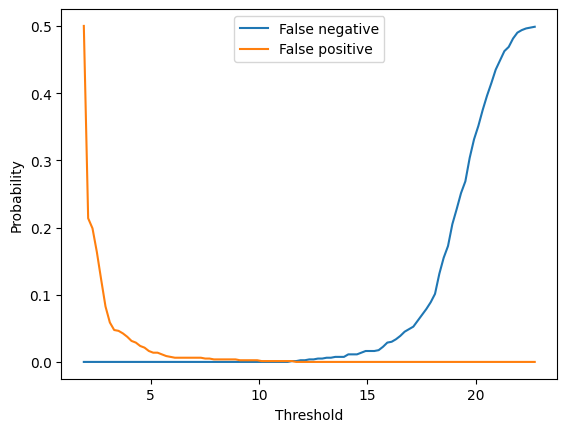

In [27]:
plt.plot(values_th,false_neg,label="False negative")
plt.plot(values_th,false_pos,label="False positive")
plt.xlabel("Threshold")
plt.ylabel("Probability")
plt.legend()
plt.show()

In [28]:
pred=[]
for im in tqdm(test):
    
    img= im.reshape(1,50,1024,1)
    error=model.evaluate(img,img,batch_size=1)
    if(error<normal_values[0]+normal_values[1]): ## mean+sdtv of the normal matrixes
      pred.append(0)
    else:
      pred.append(1)

correct=np.array(pred)==labels_test

## make predictions on the test set and create a mask where we can see if the prediction was correct for a given threshold

  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step - loss: 18.8973


  0%|          | 2/800 [00:00<00:56, 14.05it/s]

1/1 [==============================] - 0s 27ms/step - loss: 19.5731


  0%|          | 4/800 [00:00<00:56, 13.97it/s]

1/1 [==============================] - 0s 26ms/step - loss: 3.7547


  1%|          | 6/800 [00:00<00:52, 15.21it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.2122


  1%|          | 8/800 [00:00<00:58, 13.64it/s]

1/1 [==============================] - 0s 22ms/step - loss: 19.7154


  1%|▏         | 10/800 [00:00<00:54, 14.56it/s]

1/1 [==============================] - 0s 24ms/step - loss: 19.8594


  2%|▏         | 12/800 [00:00<00:54, 14.47it/s]

1/1 [==============================] - 0s 22ms/step - loss: 2.0202


  2%|▏         | 14/800 [00:00<00:51, 15.20it/s]

1/1 [==============================] - 0s 21ms/step - loss: 19.2041


  2%|▏         | 16/800 [00:01<00:50, 15.55it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.0072


  2%|▏         | 18/800 [00:01<00:54, 14.35it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.5555


  2%|▎         | 20/800 [00:01<00:54, 14.30it/s]

1/1 [==============================] - 0s 22ms/step - loss: 2.5805


  3%|▎         | 22/800 [00:01<00:50, 15.35it/s]

1/1 [==============================] - 0s 21ms/step - loss: 2.0000


  3%|▎         | 24/800 [00:01<00:47, 16.24it/s]

1/1 [==============================] - 0s 22ms/step - loss: 1.9905


  3%|▎         | 26/800 [00:01<00:49, 15.58it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9942


  4%|▎         | 28/800 [00:01<00:50, 15.22it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.1606


  4%|▍         | 30/800 [00:01<00:49, 15.43it/s]

1/1 [==============================] - 0s 22ms/step - loss: 1.9740


  4%|▍         | 32/800 [00:02<00:47, 16.21it/s]

1/1 [==============================] - 0s 23ms/step - loss: 16.4624


  4%|▍         | 34/800 [00:02<00:47, 16.26it/s]

1/1 [==============================] - 0s 22ms/step - loss: 2.5515


  4%|▍         | 36/800 [00:02<00:46, 16.32it/s]

1/1 [==============================] - 0s 22ms/step - loss: 17.1389


  5%|▍         | 38/800 [00:02<00:46, 16.41it/s]

1/1 [==============================] - 0s 22ms/step - loss: 1.9598


  5%|▌         | 40/800 [00:02<00:46, 16.36it/s]

1/1 [==============================] - 0s 21ms/step - loss: 19.0575


  5%|▌         | 42/800 [00:02<00:44, 16.97it/s]

1/1 [==============================] - 0s 22ms/step - loss: 16.9424


  6%|▌         | 44/800 [00:02<00:45, 16.58it/s]

1/1 [==============================] - 0s 24ms/step - loss: 19.7838


  6%|▌         | 46/800 [00:02<00:46, 16.33it/s]

1/1 [==============================] - 0s 22ms/step - loss: 13.4979


  6%|▌         | 48/800 [00:03<00:45, 16.35it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9958


  6%|▋         | 50/800 [00:03<00:45, 16.32it/s]

1/1 [==============================] - 0s 22ms/step - loss: 1.9780


  6%|▋         | 52/800 [00:03<00:44, 16.69it/s]

1/1 [==============================] - 0s 28ms/step - loss: 18.8231


  7%|▋         | 54/800 [00:03<00:44, 16.59it/s]

1/1 [==============================] - 0s 22ms/step - loss: 2.5103


  7%|▋         | 56/800 [00:03<00:44, 16.75it/s]

1/1 [==============================] - 0s 22ms/step - loss: 19.8604


  7%|▋         | 58/800 [00:03<00:44, 16.69it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0163


  8%|▊         | 60/800 [00:03<00:45, 16.31it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9714


  8%|▊         | 62/800 [00:03<00:45, 16.33it/s]

1/1 [==============================] - 0s 23ms/step - loss: 18.5883


  8%|▊         | 64/800 [00:04<00:46, 15.96it/s]

1/1 [==============================] - 0s 23ms/step - loss: 19.8105


  8%|▊         | 66/800 [00:04<00:45, 16.17it/s]

1/1 [==============================] - 0s 23ms/step - loss: 17.9178


  8%|▊         | 68/800 [00:04<00:46, 15.90it/s]

1/1 [==============================] - 0s 24ms/step - loss: 18.6550


  9%|▉         | 70/800 [00:04<00:45, 15.90it/s]

1/1 [==============================] - 0s 22ms/step - loss: 2.0047


  9%|▉         | 72/800 [00:04<00:45, 15.86it/s]

1/1 [==============================] - 0s 23ms/step - loss: 20.2008


  9%|▉         | 74/800 [00:04<00:44, 16.20it/s]

1/1 [==============================] - 0s 22ms/step - loss: 19.9051


 10%|▉         | 76/800 [00:04<00:44, 16.20it/s]

1/1 [==============================] - 0s 24ms/step - loss: 18.1435


 10%|▉         | 78/800 [00:04<00:44, 16.09it/s]

1/1 [==============================] - 0s 35ms/step - loss: 20.3547


 10%|█         | 80/800 [00:05<00:50, 14.17it/s]

1/1 [==============================] - 0s 34ms/step - loss: 18.4810


 10%|█         | 82/800 [00:05<00:53, 13.48it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.9553


 10%|█         | 84/800 [00:05<01:00, 11.91it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.0046


 11%|█         | 86/800 [00:05<00:59, 11.96it/s]

1/1 [==============================] - 0s 34ms/step - loss: 15.7245


 11%|█         | 88/800 [00:05<00:59, 12.01it/s]

1/1 [==============================] - 0s 35ms/step - loss: 20.4889


 11%|█▏        | 90/800 [00:05<01:00, 11.78it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.4856


 12%|█▏        | 92/800 [00:06<00:59, 11.93it/s]

1/1 [==============================] - 0s 35ms/step - loss: 20.0468


 12%|█▏        | 94/800 [00:06<01:01, 11.56it/s]

1/1 [==============================] - 0s 46ms/step - loss: 19.6758


 12%|█▏        | 96/800 [00:06<01:00, 11.64it/s]

1/1 [==============================] - 0s 33ms/step - loss: 19.6467


 12%|█▏        | 98/800 [00:06<01:00, 11.60it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.0246


 12%|█▎        | 100/800 [00:06<01:00, 11.56it/s]

1/1 [==============================] - 0s 34ms/step - loss: 21.2644


 13%|█▎        | 102/800 [00:07<01:00, 11.46it/s]

1/1 [==============================] - 0s 23ms/step - loss: 18.8818


 13%|█▎        | 104/800 [00:07<00:58, 11.99it/s]

1/1 [==============================] - 0s 26ms/step - loss: 18.1055


 13%|█▎        | 106/800 [00:07<00:54, 12.83it/s]

1/1 [==============================] - 0s 24ms/step - loss: 21.1959


 14%|█▎        | 108/800 [00:07<00:51, 13.34it/s]

1/1 [==============================] - 0s 24ms/step - loss: 20.6261


 14%|█▍        | 110/800 [00:07<00:48, 14.18it/s]

1/1 [==============================] - 0s 21ms/step - loss: 21.5869


 14%|█▍        | 112/800 [00:07<00:45, 15.24it/s]

1/1 [==============================] - 0s 22ms/step - loss: 1.9973


 14%|█▍        | 114/800 [00:07<00:44, 15.34it/s]

1/1 [==============================] - 0s 24ms/step - loss: 15.9028


 14%|█▍        | 116/800 [00:07<00:44, 15.52it/s]

1/1 [==============================] - 0s 23ms/step - loss: 18.8440


 15%|█▍        | 118/800 [00:08<00:43, 15.82it/s]

1/1 [==============================] - 0s 23ms/step - loss: 20.1710


 15%|█▌        | 120/800 [00:08<00:42, 15.95it/s]

1/1 [==============================] - 0s 23ms/step - loss: 12.6105


 15%|█▌        | 122/800 [00:08<00:41, 16.20it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.8747


 16%|█▌        | 124/800 [00:08<00:41, 16.29it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.3858


 16%|█▌        | 126/800 [00:08<00:42, 15.81it/s]

1/1 [==============================] - 0s 22ms/step - loss: 1.9942


 16%|█▌        | 128/800 [00:08<00:43, 15.59it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.6611


 16%|█▋        | 130/800 [00:08<00:43, 15.54it/s]

1/1 [==============================] - 0s 24ms/step - loss: 19.1830


 16%|█▋        | 132/800 [00:08<00:43, 15.22it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9856


 17%|█▋        | 134/800 [00:09<00:44, 15.02it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.0318


 17%|█▋        | 136/800 [00:09<00:43, 15.28it/s]

1/1 [==============================] - 0s 22ms/step - loss: 19.3906


 17%|█▋        | 138/800 [00:09<00:43, 15.22it/s]

1/1 [==============================] - 0s 21ms/step - loss: 1.9983


 18%|█▊        | 140/800 [00:09<00:43, 15.25it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.0107


 18%|█▊        | 142/800 [00:09<00:43, 15.27it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9945


 18%|█▊        | 144/800 [00:09<00:42, 15.50it/s]

1/1 [==============================] - 0s 30ms/step - loss: 21.8861


 18%|█▊        | 146/800 [00:09<00:43, 14.95it/s]

1/1 [==============================] - 0s 25ms/step - loss: 3.7519


 18%|█▊        | 148/800 [00:10<00:43, 14.91it/s]

1/1 [==============================] - 0s 22ms/step - loss: 18.1608


 19%|█▉        | 150/800 [00:10<00:41, 15.61it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9869


 19%|█▉        | 152/800 [00:10<00:40, 15.89it/s]

1/1 [==============================] - 0s 26ms/step - loss: 20.9977


 19%|█▉        | 154/800 [00:10<00:39, 16.18it/s]

1/1 [==============================] - 0s 22ms/step - loss: 19.5291


 20%|█▉        | 156/800 [00:10<00:39, 16.20it/s]

1/1 [==============================] - 0s 23ms/step - loss: 19.5561


 20%|█▉        | 158/800 [00:10<00:38, 16.47it/s]

1/1 [==============================] - 0s 23ms/step - loss: 20.3154


 20%|██        | 160/800 [00:10<00:40, 15.65it/s]

1/1 [==============================] - 0s 22ms/step - loss: 18.3256


 20%|██        | 162/800 [00:10<00:39, 16.09it/s]

1/1 [==============================] - 0s 22ms/step - loss: 2.0204


 20%|██        | 164/800 [00:10<00:39, 16.23it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9983


 21%|██        | 166/800 [00:11<00:39, 16.04it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9256


 21%|██        | 168/800 [00:11<00:40, 15.69it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9610


 21%|██▏       | 170/800 [00:11<00:41, 15.07it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.7414


 22%|██▏       | 172/800 [00:11<00:39, 15.73it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0273


 22%|██▏       | 174/800 [00:11<00:39, 15.75it/s]

1/1 [==============================] - 0s 22ms/step - loss: 19.1723


 22%|██▏       | 176/800 [00:11<00:39, 15.89it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.8754


 22%|██▏       | 178/800 [00:11<00:40, 15.49it/s]

1/1 [==============================] - 0s 23ms/step - loss: 18.0464


 22%|██▎       | 180/800 [00:12<00:39, 15.56it/s]

1/1 [==============================] - 0s 22ms/step - loss: 21.3635


 23%|██▎       | 182/800 [00:12<00:39, 15.48it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0001


 23%|██▎       | 184/800 [00:12<00:39, 15.75it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.0171


 23%|██▎       | 186/800 [00:12<00:38, 15.99it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.4713


 24%|██▎       | 188/800 [00:12<00:39, 15.64it/s]

1/1 [==============================] - 0s 21ms/step - loss: 4.2144


 24%|██▍       | 190/800 [00:12<00:39, 15.54it/s]

1/1 [==============================] - 0s 23ms/step - loss: 19.7673


 24%|██▍       | 192/800 [00:12<00:38, 15.99it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9686


 24%|██▍       | 194/800 [00:12<00:37, 16.12it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.0210


 24%|██▍       | 196/800 [00:13<00:38, 15.60it/s]

1/1 [==============================] - 0s 24ms/step - loss: 3.1800


 25%|██▍       | 198/800 [00:13<00:38, 15.69it/s]

1/1 [==============================] - 0s 22ms/step - loss: 12.1262


 25%|██▌       | 200/800 [00:13<00:37, 15.94it/s]

1/1 [==============================] - 0s 22ms/step - loss: 18.9634


 25%|██▌       | 202/800 [00:13<00:37, 15.87it/s]

1/1 [==============================] - 0s 23ms/step - loss: 18.7720


 26%|██▌       | 204/800 [00:13<00:39, 15.17it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.6535


 26%|██▌       | 206/800 [00:13<00:38, 15.50it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.5360


 26%|██▌       | 208/800 [00:13<00:38, 15.56it/s]

1/1 [==============================] - 0s 25ms/step - loss: 18.8912


 26%|██▋       | 210/800 [00:13<00:39, 15.07it/s]

1/1 [==============================] - 0s 24ms/step - loss: 19.5199


 26%|██▋       | 212/800 [00:14<00:38, 15.09it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.0401


 27%|██▋       | 214/800 [00:14<00:38, 15.35it/s]

1/1 [==============================] - 0s 23ms/step - loss: 19.3398


 27%|██▋       | 216/800 [00:14<00:37, 15.60it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.9525


 27%|██▋       | 218/800 [00:14<00:37, 15.51it/s]

1/1 [==============================] - 0s 22ms/step - loss: 18.5260


 28%|██▊       | 220/800 [00:14<00:36, 16.08it/s]

1/1 [==============================] - 0s 23ms/step - loss: 16.4622


 28%|██▊       | 222/800 [00:14<00:36, 15.90it/s]

1/1 [==============================] - 0s 22ms/step - loss: 2.9657


 28%|██▊       | 224/800 [00:14<00:36, 15.66it/s]

1/1 [==============================] - 0s 27ms/step - loss: 5.4327


 28%|██▊       | 226/800 [00:14<00:36, 15.91it/s]

1/1 [==============================] - 0s 22ms/step - loss: 18.3981


 28%|██▊       | 228/800 [00:15<00:34, 16.50it/s]

1/1 [==============================] - 0s 23ms/step - loss: 18.3798


 29%|██▉       | 230/800 [00:15<00:34, 16.58it/s]

1/1 [==============================] - 0s 21ms/step - loss: 17.8259


 29%|██▉       | 232/800 [00:15<00:34, 16.53it/s]

1/1 [==============================] - 0s 25ms/step - loss: 14.0629


 29%|██▉       | 234/800 [00:15<00:33, 16.70it/s]

1/1 [==============================] - 0s 28ms/step - loss: 20.8773


 30%|██▉       | 236/800 [00:15<00:34, 16.20it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9636


 30%|██▉       | 238/800 [00:15<00:35, 15.62it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.5640


 30%|███       | 240/800 [00:15<00:35, 15.63it/s]

1/1 [==============================] - 0s 24ms/step - loss: 19.9676


 30%|███       | 242/800 [00:15<00:34, 16.02it/s]

1/1 [==============================] - 0s 23ms/step - loss: 10.0961


 30%|███       | 244/800 [00:16<00:34, 15.90it/s]

1/1 [==============================] - 0s 21ms/step - loss: 18.7579


 31%|███       | 246/800 [00:16<00:34, 16.29it/s]

1/1 [==============================] - 0s 23ms/step - loss: 4.8190


 31%|███       | 248/800 [00:16<00:34, 15.94it/s]

1/1 [==============================] - 0s 23ms/step - loss: 18.5916


 31%|███▏      | 250/800 [00:16<00:34, 15.97it/s]

1/1 [==============================] - 0s 23ms/step - loss: 3.6321


 32%|███▏      | 252/800 [00:16<00:34, 15.80it/s]

1/1 [==============================] - 0s 22ms/step - loss: 2.4750


 32%|███▏      | 254/800 [00:16<00:33, 16.20it/s]

1/1 [==============================] - 0s 23ms/step - loss: 16.7780


 32%|███▏      | 256/800 [00:16<00:34, 15.89it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.2993


 32%|███▏      | 258/800 [00:16<00:34, 15.67it/s]

1/1 [==============================] - 0s 20ms/step - loss: 21.5926


 32%|███▎      | 260/800 [00:17<00:34, 15.62it/s]

1/1 [==============================] - 0s 35ms/step - loss: 18.1689


 33%|███▎      | 262/800 [00:17<00:37, 14.25it/s]

1/1 [==============================] - 0s 35ms/step - loss: 1.9966


 33%|███▎      | 264/800 [00:17<00:40, 13.26it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9872


 33%|███▎      | 266/800 [00:17<00:41, 12.82it/s]

1/1 [==============================] - 0s 31ms/step - loss: 11.5042


 34%|███▎      | 268/800 [00:17<00:41, 12.72it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.8835


 34%|███▍      | 270/800 [00:17<00:42, 12.45it/s]

1/1 [==============================] - 0s 34ms/step - loss: 20.3403


 34%|███▍      | 272/800 [00:18<00:42, 12.29it/s]

1/1 [==============================] - 0s 35ms/step - loss: 18.7567


 34%|███▍      | 274/800 [00:18<00:44, 11.88it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.5905


 34%|███▍      | 276/800 [00:18<00:43, 12.11it/s]

1/1 [==============================] - 0s 33ms/step - loss: 19.1972


 35%|███▍      | 278/800 [00:18<00:43, 11.91it/s]

1/1 [==============================] - 0s 32ms/step - loss: 19.9543


 35%|███▌      | 280/800 [00:18<00:43, 11.84it/s]

1/1 [==============================] - 0s 34ms/step - loss: 21.5199


 35%|███▌      | 282/800 [00:18<00:45, 11.50it/s]

1/1 [==============================] - 0s 32ms/step - loss: 3.0115


 36%|███▌      | 284/800 [00:19<00:44, 11.69it/s]

1/1 [==============================] - 0s 33ms/step - loss: 18.1301


 36%|███▌      | 286/800 [00:19<00:44, 11.58it/s]

1/1 [==============================] - 0s 26ms/step - loss: 19.7487


 36%|███▌      | 288/800 [00:19<00:41, 12.25it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.0078


 36%|███▋      | 290/800 [00:19<00:39, 12.79it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9600


 36%|███▋      | 292/800 [00:19<00:38, 13.29it/s]

1/1 [==============================] - 0s 23ms/step - loss: 18.5701


 37%|███▋      | 294/800 [00:19<00:35, 14.09it/s]

1/1 [==============================] - 0s 23ms/step - loss: 21.2089


 37%|███▋      | 296/800 [00:19<00:34, 14.58it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9775


 37%|███▋      | 298/800 [00:20<00:33, 14.80it/s]

1/1 [==============================] - 0s 25ms/step - loss: 20.0922


 38%|███▊      | 300/800 [00:20<00:35, 14.19it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0185


 38%|███▊      | 302/800 [00:20<00:34, 14.62it/s]

1/1 [==============================] - 0s 23ms/step - loss: 4.4860


 38%|███▊      | 304/800 [00:20<00:33, 14.98it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.9051


 38%|███▊      | 306/800 [00:20<00:32, 14.99it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0077


 38%|███▊      | 308/800 [00:20<00:33, 14.87it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9192


 39%|███▉      | 310/800 [00:20<00:32, 15.03it/s]

1/1 [==============================] - 0s 22ms/step - loss: 1.9606


 39%|███▉      | 312/800 [00:21<00:31, 15.30it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0071


 39%|███▉      | 314/800 [00:21<00:31, 15.39it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9843


 40%|███▉      | 316/800 [00:21<00:31, 15.56it/s]

1/1 [==============================] - 0s 23ms/step - loss: 20.0040


 40%|███▉      | 318/800 [00:21<00:31, 15.41it/s]

1/1 [==============================] - 0s 22ms/step - loss: 2.5217


 40%|████      | 320/800 [00:21<00:30, 15.92it/s]

1/1 [==============================] - 0s 21ms/step - loss: 2.0092


 40%|████      | 322/800 [00:21<00:29, 15.94it/s]

1/1 [==============================] - 0s 22ms/step - loss: 20.2792


 40%|████      | 324/800 [00:21<00:30, 15.73it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.7604


 41%|████      | 326/800 [00:21<00:30, 15.68it/s]

1/1 [==============================] - 0s 24ms/step - loss: 21.5970


 41%|████      | 328/800 [00:22<00:29, 15.81it/s]

1/1 [==============================] - 0s 25ms/step - loss: 15.6601


 41%|████▏     | 330/800 [00:22<00:30, 15.45it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0292


 42%|████▏     | 332/800 [00:22<00:30, 15.49it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9923


 42%|████▏     | 334/800 [00:22<00:31, 15.03it/s]

1/1 [==============================] - 0s 23ms/step - loss: 18.1349


 42%|████▏     | 336/800 [00:22<00:30, 15.37it/s]

1/1 [==============================] - 0s 23ms/step - loss: 19.2658


 42%|████▏     | 338/800 [00:22<00:29, 15.44it/s]

1/1 [==============================] - 0s 23ms/step - loss: 20.8173


 42%|████▎     | 340/800 [00:22<00:30, 15.29it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.9448


 43%|████▎     | 342/800 [00:22<00:29, 15.32it/s]

1/1 [==============================] - 0s 27ms/step - loss: 20.8031


 43%|████▎     | 344/800 [00:23<00:29, 15.27it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9898


 43%|████▎     | 346/800 [00:23<00:29, 15.43it/s]

1/1 [==============================] - 0s 21ms/step - loss: 19.7608


 44%|████▎     | 348/800 [00:23<00:29, 15.48it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.8539


 44%|████▍     | 350/800 [00:23<00:29, 15.34it/s]

1/1 [==============================] - 0s 22ms/step - loss: 2.8350


 44%|████▍     | 352/800 [00:23<00:29, 15.32it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9908


 44%|████▍     | 354/800 [00:23<00:28, 15.51it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9840


 44%|████▍     | 356/800 [00:23<00:28, 15.46it/s]

1/1 [==============================] - 0s 22ms/step - loss: 18.2989


 45%|████▍     | 358/800 [00:23<00:28, 15.71it/s]

1/1 [==============================] - 0s 26ms/step - loss: 18.4770


 45%|████▌     | 360/800 [00:24<00:28, 15.19it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.7201


 45%|████▌     | 362/800 [00:24<00:28, 15.21it/s]

1/1 [==============================] - 0s 22ms/step - loss: 20.0734


 46%|████▌     | 364/800 [00:24<00:27, 15.65it/s]

1/1 [==============================] - 0s 22ms/step - loss: 17.7739


 46%|████▌     | 366/800 [00:24<00:27, 15.95it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.8672


 46%|████▌     | 368/800 [00:24<00:26, 16.04it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.5717


 46%|████▋     | 370/800 [00:24<00:27, 15.62it/s]

1/1 [==============================] - 0s 23ms/step - loss: 17.1737


 46%|████▋     | 372/800 [00:24<00:27, 15.83it/s]

1/1 [==============================] - 0s 22ms/step - loss: 1.9906


 47%|████▋     | 374/800 [00:25<00:26, 15.87it/s]

1/1 [==============================] - 0s 24ms/step - loss: 17.8430


 47%|████▋     | 376/800 [00:25<00:27, 15.63it/s]

1/1 [==============================] - 0s 23ms/step - loss: 17.4659


 47%|████▋     | 378/800 [00:25<00:27, 15.37it/s]

1/1 [==============================] - 0s 24ms/step - loss: 16.1285


 48%|████▊     | 380/800 [00:25<00:26, 15.67it/s]

1/1 [==============================] - 0s 25ms/step - loss: 18.1855


 48%|████▊     | 382/800 [00:25<00:25, 16.10it/s]

1/1 [==============================] - 0s 22ms/step - loss: 18.7754


 48%|████▊     | 384/800 [00:25<00:26, 15.85it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9866


 48%|████▊     | 386/800 [00:25<00:26, 15.66it/s]

1/1 [==============================] - 0s 22ms/step - loss: 21.6443


 48%|████▊     | 388/800 [00:25<00:26, 15.67it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.7791


 49%|████▉     | 390/800 [00:26<00:25, 16.00it/s]

1/1 [==============================] - 0s 23ms/step - loss: 19.7129


 49%|████▉     | 392/800 [00:26<00:25, 16.04it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0041


 49%|████▉     | 394/800 [00:26<00:25, 15.78it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9772


 50%|████▉     | 396/800 [00:26<00:26, 15.53it/s]

1/1 [==============================] - 0s 22ms/step - loss: 22.9613


 50%|████▉     | 398/800 [00:26<00:26, 15.23it/s]

1/1 [==============================] - 0s 23ms/step - loss: 18.0099


 50%|█████     | 400/800 [00:26<00:25, 15.52it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0211


 50%|█████     | 402/800 [00:26<00:26, 15.30it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9863


 50%|█████     | 404/800 [00:26<00:26, 15.05it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.7559


 51%|█████     | 406/800 [00:27<00:25, 15.28it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9903


 51%|█████     | 408/800 [00:27<00:25, 15.44it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9941


 51%|█████▏    | 410/800 [00:27<00:25, 15.44it/s]

1/1 [==============================] - 0s 23ms/step - loss: 4.8873


 52%|█████▏    | 412/800 [00:27<00:25, 15.19it/s]

1/1 [==============================] - 0s 24ms/step - loss: 4.9365


 52%|█████▏    | 414/800 [00:27<00:25, 15.42it/s]

1/1 [==============================] - 0s 23ms/step - loss: 5.1129


 52%|█████▏    | 416/800 [00:27<00:25, 15.34it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0034


 52%|█████▏    | 418/800 [00:27<00:24, 15.33it/s]

1/1 [==============================] - 0s 24ms/step - loss: 20.9337


 52%|█████▎    | 420/800 [00:27<00:24, 15.28it/s]

1/1 [==============================] - 0s 25ms/step - loss: 3.1487


 53%|█████▎    | 422/800 [00:28<00:24, 15.15it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9733


 53%|█████▎    | 424/800 [00:28<00:24, 15.21it/s]

1/1 [==============================] - 0s 24ms/step - loss: 18.2672


 53%|█████▎    | 426/800 [00:28<00:24, 15.19it/s]

1/1 [==============================] - 0s 22ms/step - loss: 2.0266


 54%|█████▎    | 428/800 [00:28<00:24, 15.41it/s]

1/1 [==============================] - 0s 22ms/step - loss: 19.8066


 54%|█████▍    | 430/800 [00:28<00:24, 15.24it/s]

1/1 [==============================] - 0s 26ms/step - loss: 3.0082


 54%|█████▍    | 432/800 [00:28<00:24, 15.27it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9731


 54%|█████▍    | 434/800 [00:28<00:23, 15.47it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.4227


 55%|█████▍    | 436/800 [00:29<00:22, 15.86it/s]

1/1 [==============================] - 0s 32ms/step - loss: 19.4077


 55%|█████▍    | 438/800 [00:29<00:23, 15.73it/s]

1/1 [==============================] - 0s 24ms/step - loss: 21.7647


 55%|█████▌    | 440/800 [00:29<00:22, 15.74it/s]

1/1 [==============================] - 0s 30ms/step - loss: 19.6127


 55%|█████▌    | 442/800 [00:29<00:22, 15.67it/s]

1/1 [==============================] - 0s 34ms/step - loss: 20.2014


 56%|█████▌    | 444/800 [00:29<00:24, 14.28it/s]

1/1 [==============================] - 0s 41ms/step - loss: 20.6021


 56%|█████▌    | 446/800 [00:29<00:28, 12.47it/s]

1/1 [==============================] - 0s 35ms/step - loss: 1.9595


 56%|█████▌    | 448/800 [00:29<00:29, 12.08it/s]

1/1 [==============================] - 0s 34ms/step - loss: 14.5957


 56%|█████▋    | 450/800 [00:30<00:29, 11.70it/s]

1/1 [==============================] - 0s 32ms/step - loss: 16.6563


 56%|█████▋    | 452/800 [00:30<00:29, 11.66it/s]

1/1 [==============================] - 0s 29ms/step - loss: 19.0650


 57%|█████▋    | 454/800 [00:30<00:29, 11.55it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9636


 57%|█████▋    | 456/800 [00:30<00:30, 11.37it/s]

1/1 [==============================] - 0s 37ms/step - loss: 19.0803


 57%|█████▋    | 458/800 [00:30<00:29, 11.44it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.9573


 57%|█████▊    | 460/800 [00:31<00:29, 11.46it/s]

1/1 [==============================] - 0s 34ms/step - loss: 1.9915


 58%|█████▊    | 462/800 [00:31<00:29, 11.47it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.0268


 58%|█████▊    | 464/800 [00:31<00:29, 11.47it/s]

1/1 [==============================] - 0s 35ms/step - loss: 18.0910


 58%|█████▊    | 466/800 [00:31<00:29, 11.47it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9687


 58%|█████▊    | 468/800 [00:31<00:28, 11.48it/s]

1/1 [==============================] - 0s 47ms/step - loss: 1.9680


 59%|█████▉    | 470/800 [00:31<00:29, 11.29it/s]

1/1 [==============================] - 0s 24ms/step - loss: 18.4086


 59%|█████▉    | 472/800 [00:32<00:27, 12.04it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.9530


 59%|█████▉    | 474/800 [00:32<00:25, 12.78it/s]

1/1 [==============================] - 0s 21ms/step - loss: 20.2305


 60%|█████▉    | 476/800 [00:32<00:23, 13.55it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0034


 60%|█████▉    | 478/800 [00:32<00:23, 13.98it/s]

1/1 [==============================] - 0s 21ms/step - loss: 18.5036


 60%|██████    | 480/800 [00:32<00:22, 14.07it/s]

1/1 [==============================] - 0s 24ms/step - loss: 20.2150


 60%|██████    | 482/800 [00:32<00:21, 14.65it/s]

1/1 [==============================] - 0s 25ms/step - loss: 19.9421


 60%|██████    | 484/800 [00:32<00:21, 14.89it/s]

1/1 [==============================] - 0s 23ms/step - loss: 19.2310


 61%|██████    | 486/800 [00:32<00:21, 14.65it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9711


 61%|██████    | 488/800 [00:33<00:21, 14.80it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9914


 61%|██████▏   | 490/800 [00:33<00:20, 14.98it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0042


 62%|██████▏   | 492/800 [00:33<00:20, 14.85it/s]

1/1 [==============================] - 0s 25ms/step - loss: 19.8101


 62%|██████▏   | 494/800 [00:33<00:20, 14.75it/s]

1/1 [==============================] - 0s 25ms/step - loss: 15.9631


 62%|██████▏   | 496/800 [00:33<00:20, 14.73it/s]

1/1 [==============================] - 0s 24ms/step - loss: 15.4216


 62%|██████▏   | 498/800 [00:33<00:20, 14.98it/s]

1/1 [==============================] - 0s 24ms/step - loss: 18.4265


 62%|██████▎   | 500/800 [00:33<00:19, 15.35it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0163


 63%|██████▎   | 502/800 [00:34<00:19, 15.05it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.6302


 63%|██████▎   | 504/800 [00:34<00:19, 15.48it/s]

1/1 [==============================] - 0s 25ms/step - loss: 19.4001


 63%|██████▎   | 506/800 [00:34<00:19, 15.19it/s]

1/1 [==============================] - 0s 29ms/step - loss: 19.0554


 64%|██████▎   | 508/800 [00:34<00:19, 14.74it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.7395


 64%|██████▍   | 510/800 [00:34<00:20, 14.31it/s]

1/1 [==============================] - 0s 24ms/step - loss: 3.1908


 64%|██████▍   | 512/800 [00:34<00:19, 14.64it/s]

1/1 [==============================] - 0s 25ms/step - loss: 20.6002


 64%|██████▍   | 514/800 [00:34<00:19, 14.62it/s]

1/1 [==============================] - 0s 27ms/step - loss: 3.1294


 64%|██████▍   | 516/800 [00:34<00:19, 14.72it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.7254


 65%|██████▍   | 518/800 [00:35<00:18, 14.93it/s]

1/1 [==============================] - 0s 21ms/step - loss: 1.9605


 65%|██████▌   | 520/800 [00:35<00:18, 15.41it/s]

1/1 [==============================] - 0s 21ms/step - loss: 20.3506


 65%|██████▌   | 522/800 [00:35<00:17, 15.56it/s]

1/1 [==============================] - 0s 24ms/step - loss: 19.3244


 66%|██████▌   | 524/800 [00:35<00:17, 15.68it/s]

1/1 [==============================] - 0s 28ms/step - loss: 4.4029


 66%|██████▌   | 526/800 [00:35<00:18, 15.09it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9754


 66%|██████▌   | 528/800 [00:35<00:17, 15.33it/s]

1/1 [==============================] - 0s 34ms/step - loss: 20.9554


 66%|██████▋   | 530/800 [00:35<00:18, 14.99it/s]

1/1 [==============================] - 0s 24ms/step - loss: 18.6124


 66%|██████▋   | 532/800 [00:36<00:18, 14.70it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9898


 67%|██████▋   | 534/800 [00:36<00:18, 14.62it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0422


 67%|██████▋   | 536/800 [00:36<00:17, 14.73it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.9168


 67%|██████▋   | 538/800 [00:36<00:17, 15.02it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0109


 68%|██████▊   | 540/800 [00:36<00:17, 15.09it/s]

1/1 [==============================] - 0s 26ms/step - loss: 15.6892


 68%|██████▊   | 542/800 [00:36<00:17, 14.68it/s]

1/1 [==============================] - 0s 22ms/step - loss: 2.4209


 68%|██████▊   | 544/800 [00:36<00:17, 14.85it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.0120


 68%|██████▊   | 546/800 [00:36<00:17, 14.93it/s]

1/1 [==============================] - 0s 21ms/step - loss: 16.5055


 68%|██████▊   | 548/800 [00:37<00:16, 15.06it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.6182


 69%|██████▉   | 550/800 [00:37<00:16, 15.12it/s]

1/1 [==============================] - 0s 22ms/step - loss: 1.9722


 69%|██████▉   | 552/800 [00:37<00:16, 15.01it/s]

1/1 [==============================] - 0s 23ms/step - loss: 20.2698


 69%|██████▉   | 554/800 [00:37<00:15, 15.56it/s]

1/1 [==============================] - 0s 24ms/step - loss: 18.7927


 70%|██████▉   | 556/800 [00:37<00:15, 15.43it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0019


 70%|██████▉   | 558/800 [00:37<00:15, 15.60it/s]

1/1 [==============================] - 0s 27ms/step - loss: 7.3250


 70%|███████   | 560/800 [00:37<00:15, 15.20it/s]

1/1 [==============================] - 0s 29ms/step - loss: 17.2620


 70%|███████   | 562/800 [00:38<00:15, 15.42it/s]

1/1 [==============================] - 0s 20ms/step - loss: 2.4752


 70%|███████   | 564/800 [00:38<00:15, 15.48it/s]

1/1 [==============================] - 0s 24ms/step - loss: 16.5406


 71%|███████   | 566/800 [00:38<00:14, 15.76it/s]

1/1 [==============================] - 0s 26ms/step - loss: 16.5583


 71%|███████   | 568/800 [00:38<00:14, 15.78it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.5938


 71%|███████▏  | 570/800 [00:38<00:14, 15.39it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0189


 72%|███████▏  | 572/800 [00:38<00:15, 14.94it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9809


 72%|███████▏  | 574/800 [00:38<00:14, 15.14it/s]

1/1 [==============================] - 0s 28ms/step - loss: 17.6954


 72%|███████▏  | 576/800 [00:38<00:15, 14.93it/s]

1/1 [==============================] - 0s 24ms/step - loss: 18.3063


 72%|███████▏  | 578/800 [00:39<00:14, 14.84it/s]

1/1 [==============================] - 0s 24ms/step - loss: 3.3823


 72%|███████▎  | 580/800 [00:39<00:14, 14.81it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9588


 73%|███████▎  | 582/800 [00:39<00:14, 15.12it/s]

1/1 [==============================] - 0s 24ms/step - loss: 18.9327


 73%|███████▎  | 584/800 [00:39<00:14, 15.04it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.5332


 73%|███████▎  | 586/800 [00:39<00:14, 14.82it/s]

1/1 [==============================] - 0s 25ms/step - loss: 20.8313


 74%|███████▎  | 588/800 [00:39<00:14, 14.94it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.5019


 74%|███████▍  | 590/800 [00:39<00:13, 15.26it/s]

1/1 [==============================] - 0s 24ms/step - loss: 20.4432


 74%|███████▍  | 592/800 [00:39<00:13, 15.05it/s]

1/1 [==============================] - 0s 27ms/step - loss: 21.7885


 74%|███████▍  | 594/800 [00:40<00:13, 14.81it/s]

1/1 [==============================] - 0s 26ms/step - loss: 3.2801


 74%|███████▍  | 596/800 [00:40<00:13, 14.76it/s]

1/1 [==============================] - 0s 31ms/step - loss: 19.9546


 75%|███████▍  | 598/800 [00:40<00:13, 15.05it/s]

1/1 [==============================] - 0s 21ms/step - loss: 19.4685


 75%|███████▌  | 600/800 [00:40<00:13, 15.29it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9834


 75%|███████▌  | 602/800 [00:40<00:13, 14.83it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.7920


 76%|███████▌  | 604/800 [00:40<00:13, 14.95it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.8361


 76%|███████▌  | 606/800 [00:40<00:12, 15.25it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0022


 76%|███████▌  | 608/800 [00:41<00:12, 15.34it/s]

1/1 [==============================] - 0s 26ms/step - loss: 18.3094


 76%|███████▋  | 610/800 [00:41<00:12, 15.39it/s]

1/1 [==============================] - 0s 24ms/step - loss: 18.1750


 76%|███████▋  | 612/800 [00:41<00:12, 15.04it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9637


 77%|███████▋  | 614/800 [00:41<00:12, 15.05it/s]

1/1 [==============================] - 0s 21ms/step - loss: 1.9991


 77%|███████▋  | 616/800 [00:41<00:12, 15.26it/s]

1/1 [==============================] - 0s 25ms/step - loss: 15.7280


 77%|███████▋  | 618/800 [00:41<00:11, 15.28it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1121


 78%|███████▊  | 620/800 [00:41<00:12, 14.65it/s]

1/1 [==============================] - 0s 34ms/step - loss: 1.9813


 78%|███████▊  | 622/800 [00:42<00:12, 13.89it/s]

1/1 [==============================] - 0s 204ms/step - loss: 21.9050


 78%|███████▊  | 624/800 [00:42<00:25,  6.91it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9832


 78%|███████▊  | 626/800 [00:42<00:22,  7.70it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.9288


 78%|███████▊  | 628/800 [00:43<00:20,  8.56it/s]

1/1 [==============================] - 0s 67ms/step - loss: 4.6251


 79%|███████▉  | 630/800 [00:43<00:19,  8.54it/s]

1/1 [==============================] - 0s 36ms/step - loss: 1.9867


 79%|███████▉  | 632/800 [00:43<00:31,  5.40it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9722


 79%|███████▉  | 634/800 [00:44<00:26,  6.38it/s]

1/1 [==============================] - 0s 33ms/step - loss: 16.9273


 80%|███████▉  | 636/800 [00:44<00:22,  7.27it/s]

1/1 [==============================] - 0s 53ms/step - loss: 19.5733


 80%|███████▉  | 638/800 [00:44<00:21,  7.59it/s]

1/1 [==============================] - 0s 32ms/step - loss: 19.3664


 80%|███████▉  | 639/800 [00:44<00:20,  7.87it/s]

1/1 [==============================] - 0s 35ms/step - loss: 1.9723


 80%|████████  | 641/800 [00:44<00:18,  8.78it/s]

1/1 [==============================] - 0s 29ms/step - loss: 21.6521


 80%|████████  | 643/800 [00:44<00:16,  9.50it/s]

1/1 [==============================] - 0s 25ms/step - loss: 21.2038


 81%|████████  | 645/800 [00:45<00:15,  9.87it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.5708


 81%|████████  | 647/800 [00:45<00:14, 10.88it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9712


 81%|████████  | 649/800 [00:45<00:12, 11.91it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.2144


 81%|████████▏ | 651/800 [00:45<00:11, 12.66it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9948


 82%|████████▏ | 653/800 [00:45<00:10, 13.44it/s]

1/1 [==============================] - 0s 23ms/step - loss: 20.6852


 82%|████████▏ | 655/800 [00:45<00:10, 13.53it/s]

1/1 [==============================] - 0s 32ms/step - loss: 18.1240


 82%|████████▏ | 657/800 [00:46<00:10, 13.75it/s]

1/1 [==============================] - 0s 24ms/step - loss: 18.1117


 82%|████████▏ | 659/800 [00:46<00:09, 14.19it/s]

1/1 [==============================] - 0s 22ms/step - loss: 19.7208


 83%|████████▎ | 661/800 [00:46<00:09, 14.28it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.9265


 83%|████████▎ | 663/800 [00:46<00:09, 14.53it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.0109


 83%|████████▎ | 665/800 [00:46<00:09, 14.58it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9868


 83%|████████▎ | 667/800 [00:46<00:08, 14.90it/s]

1/1 [==============================] - 0s 23ms/step - loss: 16.8452


 84%|████████▎ | 669/800 [00:46<00:08, 15.06it/s]

1/1 [==============================] - 0s 27ms/step - loss: 20.1380


 84%|████████▍ | 671/800 [00:46<00:08, 15.34it/s]

1/1 [==============================] - 0s 31ms/step - loss: 18.3884


 84%|████████▍ | 673/800 [00:47<00:08, 15.01it/s]

1/1 [==============================] - 0s 22ms/step - loss: 1.9733


 84%|████████▍ | 675/800 [00:47<00:08, 15.16it/s]

1/1 [==============================] - 0s 24ms/step - loss: 19.0299


 85%|████████▍ | 677/800 [00:47<00:08, 15.03it/s]

1/1 [==============================] - 0s 23ms/step - loss: 18.1852


 85%|████████▍ | 679/800 [00:47<00:08, 15.10it/s]

1/1 [==============================] - 0s 21ms/step - loss: 1.9646


 85%|████████▌ | 681/800 [00:47<00:07, 14.92it/s]

1/1 [==============================] - 0s 25ms/step - loss: 19.1041


 85%|████████▌ | 683/800 [00:47<00:07, 14.81it/s]

1/1 [==============================] - 0s 21ms/step - loss: 1.9643


 86%|████████▌ | 685/800 [00:47<00:07, 14.97it/s]

1/1 [==============================] - 0s 21ms/step - loss: 4.8473


 86%|████████▌ | 687/800 [00:47<00:07, 15.30it/s]

1/1 [==============================] - 0s 23ms/step - loss: 17.4979


 86%|████████▌ | 689/800 [00:48<00:07, 15.67it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.6970


 86%|████████▋ | 691/800 [00:48<00:07, 15.09it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.8101


 87%|████████▋ | 693/800 [00:48<00:06, 15.42it/s]

1/1 [==============================] - 0s 24ms/step - loss: 20.9365


 87%|████████▋ | 695/800 [00:48<00:06, 15.69it/s]

1/1 [==============================] - 0s 26ms/step - loss: 4.1844


 87%|████████▋ | 697/800 [00:48<00:06, 15.45it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.5161


 87%|████████▋ | 699/800 [00:48<00:06, 15.18it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9834


 88%|████████▊ | 701/800 [00:48<00:06, 15.32it/s]

1/1 [==============================] - 0s 23ms/step - loss: 5.6498


 88%|████████▊ | 703/800 [00:49<00:06, 15.35it/s]

1/1 [==============================] - 0s 23ms/step - loss: 22.2730


 88%|████████▊ | 705/800 [00:49<00:06, 15.26it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9680


 88%|████████▊ | 707/800 [00:49<00:06, 14.91it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0202


 89%|████████▊ | 709/800 [00:49<00:05, 15.33it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9415


 89%|████████▉ | 711/800 [00:49<00:05, 15.38it/s]

1/1 [==============================] - 0s 22ms/step - loss: 20.0520


 89%|████████▉ | 713/800 [00:49<00:05, 15.28it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0332


 89%|████████▉ | 715/800 [00:49<00:05, 15.17it/s]

1/1 [==============================] - 0s 24ms/step - loss: 5.4632


 90%|████████▉ | 717/800 [00:49<00:05, 14.93it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.1283


 90%|████████▉ | 719/800 [00:50<00:05, 15.15it/s]

1/1 [==============================] - 0s 30ms/step - loss: 14.8954


 90%|█████████ | 721/800 [00:50<00:05, 14.79it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.3603


 90%|█████████ | 723/800 [00:50<00:05, 14.68it/s]

1/1 [==============================] - 0s 24ms/step - loss: 19.5940


 91%|█████████ | 725/800 [00:50<00:05, 14.90it/s]

1/1 [==============================] - 0s 26ms/step - loss: 21.6261


 91%|█████████ | 727/800 [00:50<00:04, 15.09it/s]

1/1 [==============================] - 0s 23ms/step - loss: 18.3999


 91%|█████████ | 729/800 [00:50<00:04, 15.06it/s]

1/1 [==============================] - 0s 26ms/step - loss: 18.6416


 91%|█████████▏| 731/800 [00:50<00:04, 15.13it/s]

1/1 [==============================] - 0s 25ms/step - loss: 20.2648


 92%|█████████▏| 733/800 [00:51<00:04, 14.55it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9370


 92%|█████████▏| 735/800 [00:51<00:04, 14.49it/s]

1/1 [==============================] - 0s 29ms/step - loss: 15.6958


 92%|█████████▏| 737/800 [00:51<00:04, 14.66it/s]

1/1 [==============================] - 0s 25ms/step - loss: 20.7261


 92%|█████████▏| 739/800 [00:51<00:04, 14.79it/s]

1/1 [==============================] - 0s 25ms/step - loss: 19.2286


 93%|█████████▎| 741/800 [00:51<00:03, 15.08it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.6426


 93%|█████████▎| 743/800 [00:51<00:03, 14.84it/s]

1/1 [==============================] - 0s 26ms/step - loss: 20.3659


 93%|█████████▎| 745/800 [00:51<00:03, 14.97it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9777


 93%|█████████▎| 747/800 [00:51<00:03, 15.08it/s]

1/1 [==============================] - 0s 24ms/step - loss: 19.3742


 94%|█████████▎| 749/800 [00:52<00:03, 15.13it/s]

1/1 [==============================] - 0s 21ms/step - loss: 17.5151


 94%|█████████▍| 751/800 [00:52<00:03, 15.09it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.5734


 94%|█████████▍| 753/800 [00:52<00:03, 14.88it/s]

1/1 [==============================] - 0s 20ms/step - loss: 2.3753


 94%|█████████▍| 755/800 [00:52<00:02, 15.02it/s]

1/1 [==============================] - 0s 24ms/step - loss: 21.3883


 95%|█████████▍| 757/800 [00:52<00:02, 15.31it/s]

1/1 [==============================] - 0s 22ms/step - loss: 18.8698


 95%|█████████▍| 759/800 [00:52<00:02, 15.08it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.7648


 95%|█████████▌| 761/800 [00:52<00:02, 14.84it/s]

1/1 [==============================] - 0s 22ms/step - loss: 2.0030


 95%|█████████▌| 763/800 [00:53<00:02, 14.98it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0152


 96%|█████████▌| 765/800 [00:53<00:02, 14.94it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.1234


 96%|█████████▌| 767/800 [00:53<00:02, 15.05it/s]

1/1 [==============================] - 0s 26ms/step - loss: 18.7387


 96%|█████████▌| 769/800 [00:53<00:02, 14.50it/s]

1/1 [==============================] - 0s 30ms/step - loss: 20.4665


 96%|█████████▋| 771/800 [00:53<00:01, 14.62it/s]

1/1 [==============================] - 0s 25ms/step - loss: 18.6863


 97%|█████████▋| 773/800 [00:53<00:01, 14.63it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.0890


 97%|█████████▋| 775/800 [00:53<00:01, 14.93it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9732


 97%|█████████▋| 777/800 [00:53<00:01, 14.83it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.3230


 97%|█████████▋| 779/800 [00:54<00:01, 14.60it/s]

1/1 [==============================] - 0s 27ms/step - loss: 19.1981


 98%|█████████▊| 781/800 [00:54<00:01, 14.68it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9729


 98%|█████████▊| 783/800 [00:54<00:01, 14.58it/s]

1/1 [==============================] - 0s 23ms/step - loss: 19.3947


 98%|█████████▊| 785/800 [00:54<00:01, 14.70it/s]

1/1 [==============================] - 0s 32ms/step - loss: 20.7341


 98%|█████████▊| 787/800 [00:54<00:00, 13.53it/s]

1/1 [==============================] - 0s 32ms/step - loss: 18.5135


 99%|█████████▊| 789/800 [00:54<00:00, 13.06it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.8969


 99%|█████████▉| 791/800 [00:55<00:00, 12.62it/s]

1/1 [==============================] - 0s 34ms/step - loss: 20.3947


 99%|█████████▉| 793/800 [00:55<00:00, 12.40it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.0138


 99%|█████████▉| 795/800 [00:55<00:00, 12.07it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.0221


100%|█████████▉| 797/800 [00:55<00:00, 12.00it/s]

1/1 [==============================] - 0s 34ms/step - loss: 1.9990


100%|█████████▉| 799/800 [00:55<00:00, 11.50it/s]

1/1 [==============================] - 0s 31ms/step - loss: 18.4448


100%|██████████| 800/800 [00:55<00:00, 14.32it/s]


In [29]:
print("The overall accuracy of the predictor is:",np.sum(correct)/len(pred)*100,"%") ## print the overall accuracy of our predictor 

The overall accuracy of the predictor is: 95.375 %


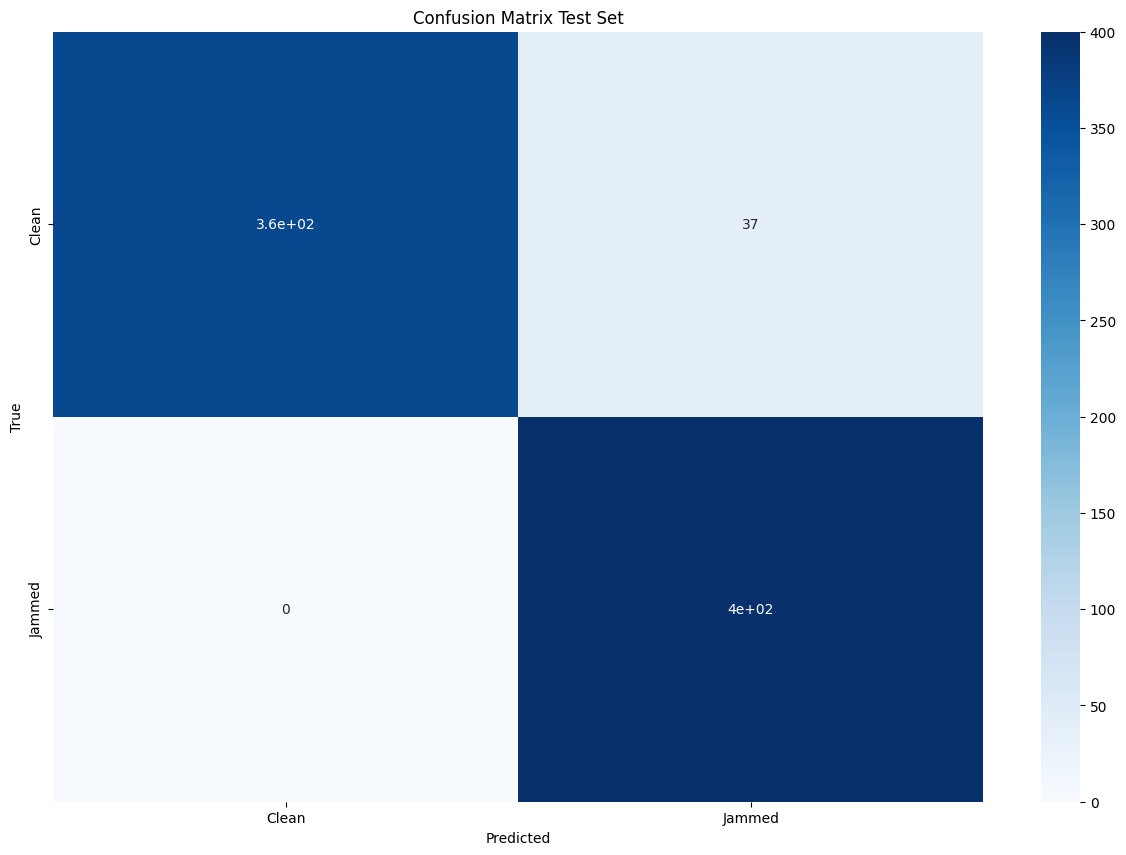

In [30]:
def print_confusion_matrix(gt, pred):
    class_names= {0: "Clean", 1:"Jammed"}
    num_classes = 2
    cm = confusion_matrix(y_true=gt, y_pred=pred)
    df_cm = pd.DataFrame(cm, index = class_names.values(), columns = class_names.values())
    plt.figure(figsize = (15,10))
    sn.heatmap(df_cm, annot=True, cmap='Blues')
    plt.title('Confusion Matrix Test Set')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

print_confusion_matrix(labels_test,pred) ## print the confusion matrix of our predictor for a given threshold

In [31]:
def plot_heatmap(matrix, vmin=None, vmax=None):
    plt.imshow(matrix, cmap="coolwarm", vmin=vmin, vmax=vmax)
    ##plt.colorbar() i dont like the colorbar in the image
    plt.axis("off")
    plt.show()

In [41]:
num=random.randint(0,len(test))
original_matrix=test[num].reshape(1,50,1024,1) ## take the image
label_mat=labels_test[num] ## corresponding label
if(label_mat==0):
  print("The matrix is NOT an anomaly")
elif(label_mat==1):
  print("The matrix is an anomaly")


The matrix is an anomaly


1/1 [==============================] - 0s 27ms/step


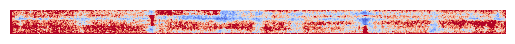

In [42]:
predicted_matrix=model.predict(original_matrix)
mse_mat=(original_matrix-predicted_matrix)**2 ##mse
plot_heatmap(mse_mat.reshape(50,1024),0,25)

In [45]:
num=random.randint(0,len(test))
original_matrix=test[num].reshape(1,50,1024,1) ## take the image
label_mat=labels_test[num] ## corresponding label
if(label_mat==0):
  print("The matrix is NOT an anomaly")
elif(label_mat==1):
  print("The matrix is an anomaly")


The matrix is NOT an anomaly


1/1 [==============================] - 0s 30ms/step


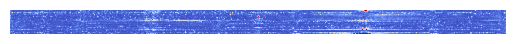

In [46]:
predicted_matrix=model.predict(original_matrix)
mse_mat=(original_matrix-predicted_matrix)**2 ##mse
plot_heatmap(mse_mat.reshape(50,1024),0,25)